# This Notebook is forked from the 1st Place Winner of ARC Prize 2024

## Dark AGI's ARC-2025 Open Source Commitment: All submissions in this competition will be open-sourced to help the community explore AGI capable of achieving 85%+ scores.

**Competition Link:** [ARC Prize 2024](https://www.kaggle.com/competitions/arc-prize-2024)  
**Original Notebook:** [arc-prize-2024-solution-by-the-architects](https://www.kaggle.com/code/dfranzen/arc-prize-2024-solution-by-the-architects?scriptVersionId=211637468)

---

## Modifications Implemented

1. **4-GPU Support**
   - Extended multi-GPU implementation from 2 to 4 GPUs
   - Modified dataset splitting logic in `prepare_dataset` to evenly distribute work
   - Added training and inference processes for GPU 2 and GPU 3
   - Updated subprocess monitoring to wait for all 8 processes (4 training + 4 inference)
   - Improved resource utilization and inference throughput by 2x

2. **Enhanced Reproducibility**
   - Added global seed control (GLOBAL_SEED = 42) with per-GPU deterministic seeding
   - Applied consistent seed values to all randomized operations for reproducible results
   - Disabled non-deterministic algorithms to ensure consistent outputs across runs
   - Implemented seed-based task distribution for consistent GPU workloads

3. **Comprehensive Visualization**
   - Implemented data visualization for both training and inference phases:
     - Color-coded grid displays for ARC tasks with intuitive color mapping
     - Side-by-side comparisons of inputs, ground truth, and model predictions
   - Added multi-GPU result comparison showing prediction quality across all GPUs
   - Created task-specific visualizations showing training examples, test inputs, and prediction attempts
   - Calculated detailed accuracy metrics with statistical breakdowns:
     - Per-attempt success rates for first and second predictions
     - Overall accuracy percentages for both individual attempts
     - Combined success rate for either prediction attempt
     - Shape and value distribution analysis for predictions vs ground truth
     - Non-zero prediction completion rate and zero-prediction filtering

In [1]:
# Copyright 2024 Daniel Franzen and Jan Disselhoff
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# This notebook contains our winning submission to the ARC Prize 2024 Kaggle competition,
# scoring 53.5 points on the private evaluation set.
# the ARChitects (Daniel Franzen and Jan Disselhoff)

# Model Runner Module Explanation

This Python module (`model_runner.py`) is a comprehensive toolkit for working with language models, focusing on efficiency and performance optimization. The code is designed to handle various aspects of model management including loading, training, inference, and optimization.

## Key Components

### Tokenizer Optimization
The module provides several functions for optimizing tokenizers:
- `indices_required_for_merges` identifies necessary token IDs for BPE merges
- `remove_unused_merges` cleans up unused merge rules
- `shrink_tokenizer_vocab` reduces vocabulary size while maintaining model functionality
- `remove_tokenizer_normalizer` removes normalizer components when not needed

### Model Size Reduction
The code includes specialized functionality for reducing model size:
- `shrink_model_embeddings` resizes embedding tables to match reduced vocabularies
- `shrink_embeddings` orchestrates the entire embedding reduction process
- Support for 4-bit quantization through `transformers_4bit` and `unsloth_4bit` loading modes

### Model Management
Several utilities handle model loading and manipulation:
- `prepare_model` provides a unified interface for model loading with various options
- `merge_peft_into_base` merges fine-tuned adapters into base models
- `fix_dtypes` ensures consistent data types across model components
- `save_model` handles model saving with options for merging adapters

### Training Functions
The module supports efficient fine-tuning:
- `training_run` handles the training process with support for both standard and optimized trainers
- The `Retrainer` class enables retraining with data augmentation
- Support for gradient accumulation fixes and packing optimizations

### Inference
Comprehensive inference capabilities:
- `inference_run_v2` orchestrates inference runs across datasets
- `inference_turbo_dfs` implements a depth-first search approach for higher quality outputs
- `inference_step` handles token generation with various decoding strategies

### Result Processing
The `Decoder` class provides extensive functionality:
- Tracks and evaluates generated outputs against reference solutions
- Calculates accuracy metrics based on exact matches
- Supports probability tracking for solution ranking
- Benchmarks different selection algorithms

### Utilities
Helpful utilities include:
- Compressed storage for inference results via `inference_save`/`inference_load` 
- PEFT weight management functions
- GPU memory tracking via `mem_info`

This module appears to be built for competitive or research applications where optimizing model efficiency and generation quality is critical.

In [3]:
%%writefile model_runner.py
import json
import os, sys
import bz2
import pickle
import numpy as np
from tqdm import tqdm

def indices_required_for_merges(keep_indices, vocab, merges):
    merges_lookup = {}
    for m in merges:
        a, b = m.split(' ') if isinstance(m, str) else m
        key = vocab[f'{a}{b}']
        if key not in merges_lookup: merges_lookup[key] = set()
        merges_lookup[key].add(vocab[a])
        merges_lookup[key].add(vocab[b])
    to_process = list(keep_indices)
    while len(to_process):
        for w in merges_lookup.get(to_process.pop(), []):
            if w not in keep_indices:
                keep_indices[w] = None
                to_process.append(w)
    return keep_indices

def remove_unused_merges(merges, vocab):
    return [f'{a} {b}' for a, b in [m.split(' ') if isinstance(m, str) else m for m in merges] if all(w in vocab for w in [a, b, a + b])]

def map_special_tokens(data, mapping=None):
    tokens = set()
    if isinstance(data, dict):
        special = data.get('special_tokens')
        if special is not None:
            for v in special.values():
                tokens.update(v['ids'])
                if mapping is not None:
                    v['ids'] = [mapping.get(i) for i in v['ids'] if i in mapping]
    for v in (data.values() if isinstance(data, dict) else data if isinstance(data, list) else []):
        tokens.update(map_special_tokens(v, mapping))
    return tokens

def remove_tokenizer_normalizer(tokenizer):
    from tokenizers import Tokenizer
    assert tokenizer.is_fast
    tokenizer_json = json.loads(tokenizer._tokenizer.to_str())
    if tokenizer_json.get('normalizer') is not None:
        tokenizer_json['normalizer'] = None
        tokenizer._tokenizer = Tokenizer.from_str(json.dumps(tokenizer_json))

def shrink_tokenizer_vocab(tokenizer, keep_indices, keep_special_tokens, keep_token_order):
    from tokenizers import Tokenizer
    assert tokenizer.is_fast
    tokenizer_json = json.loads(tokenizer._tokenizer.to_str())
    assert tokenizer_json['model']['type'] == "BPE"
    if keep_special_tokens:
        keep_indices.update({k: None for k in tokenizer.all_special_ids})
        keep_indices.update({k: None for k in map_special_tokens(tokenizer_json.get('post_processor'))})
    keep_indices = indices_required_for_merges(keep_indices, tokenizer_json['model']['vocab'], tokenizer_json['model']['merges'])
    if keep_token_order: keep_indices = sorted(keep_indices)
    mapping = {old: new for new, old in enumerate(keep_indices)}
    tokenizer_json['model']['vocab'] = {k: mapping[v] for k, v in tokenizer_json['model']['vocab'].items() if v in mapping}
    tokenizer_json['model']['merges'] = remove_unused_merges(tokenizer_json['model']['merges'], tokenizer_json['model']['vocab'])
    special_tokens_order = [t['id'] for t in tokenizer_json['added_tokens']]
    assert special_tokens_order==sorted(special_tokens_order)
    tokenizer_json['added_tokens'] = sorted([{**t, 'id': mapping[t['id']]} for t in tokenizer_json['added_tokens'] if t['id'] in mapping], key=lambda t: t['id'])
    map_special_tokens(tokenizer_json.get('post_processor'), mapping)
    tokenizer._tokenizer = Tokenizer.from_str(json.dumps(tokenizer_json))
    return mapping, keep_indices

def shrink_model_embeddings(model, keep_indices, mapping):
    import torch
    with torch.no_grad():
        row_select = torch.tensor(list(keep_indices))
        new_embed_t = torch.index_select(model.get_input_embeddings().weight.data, 0, row_select.to(model.get_input_embeddings().weight.data.device))
        new_lm_head = torch.index_select(model.get_output_embeddings().weight.data, 0, row_select.to(model.get_output_embeddings().weight.data.device))
        model.resize_token_embeddings(len(keep_indices))
        model.get_input_embeddings().weight.data[:] = new_embed_t
        model.get_output_embeddings().weight.data[:] = new_lm_head
        for config in [model.config, model.generation_config]:
            for k, v in list(config.to_dict().items()):
                if k.endswith('token_id'):
                    setattr(config, k, [mapping.get(t) for t in v] if isinstance(v, list) else mapping.get(v))

def shrink_embeddings(model, tokenizer, corpus=None, keep_token_ids=[], keep_tokens=[], remove_token_ids=[], keep_model_tokens=True, keep_special_tokens=True, keep_normalizer=False, keep_token_order=True):
    if not keep_normalizer: remove_tokenizer_normalizer(tokenizer)
    from collections import OrderedDict  # use as OrderedSet
    keep_indices = OrderedDict()
    keep_indices.update({k: None for k in keep_token_ids})
    keep_indices.update({tokenizer.vocab[t]: None for t in keep_tokens})
    if corpus is not None: keep_indices.update({k: None for k in tokenizer(corpus)['input_ids']})
    if keep_model_tokens:
        for config in [model.config, model.generation_config]:
            for k, v in config.to_dict().items():
                if k.endswith('token_id'):
                    keep_indices.update({k: None for k in (v if isinstance(v, list) else [v])})
    keep_indices.pop(None, None)
    for idx in remove_token_ids: keep_indices.pop(idx, None)
    mapping, keep_indices = shrink_tokenizer_vocab(tokenizer, keep_indices, keep_special_tokens, keep_token_order)
    shrink_model_embeddings(model, keep_indices, mapping=mapping)
    return mapping

def fix_dtypes(model, fix_weights=True, fix_quant_states=True):
    import torch
    for module in model.modules():
        weight = getattr(module, 'weight', None)
        if weight is not None:
            if torch.is_floating_point(weight):
                if fix_weights and weight.dtype!=model.dtype:
                    module.to(model.dtype)
            else:
                qs = getattr(weight, 'quant_state', None)
                if qs is not None:
                    if fix_quant_states and qs.dtype!=model.dtype:
                        qs.dtype = model.dtype
    return model

def merge_peft_into_base(model):
    print('*** Merge peft model into base model...')
    assert is_peft_model(model)
    return fix_dtypes(model.merge_and_unload())

def save_model(store_path, model=None, tokenizer=None, merge=False):
    if merge: model = merge_peft_into_base(model)
    if store_path is not None:
        assert model is not None or tokenizer is not None
        print(f"*** Saving{' merged' if merge else ''} model/tokenizer to '{store_path}'...")
        if model is not None: model.save_pretrained(store_path)
        if tokenizer is not None:
            tokenizer.save_pretrained(store_path)
            to_delete = os.path.join(store_path, 'tokenizer.model')
            if os.path.isfile(to_delete): os.remove(to_delete)
    return model

def is_unsloth_model(model):
    return model.model_tags is not None and 'unsloth' in model.model_tags

def is_peft_model(model):
    return hasattr(model, 'peft_type')

def download_model(repo_id, store_path, get_name=lambda n: os.path.join(n.replace('/', '--'), 'transformers', 'default', '1')):
    import os
    if os.path.exists(repo_id): return repo_id
    model_path = os.path.join(store_path, get_name(repo_id))
    if not os.path.exists(model_path):
        from huggingface_hub import snapshot_download
        download_path = snapshot_download(repo_id=repo_id)
        os.makedirs(os.path.split(model_path)[0], exist_ok=True)
        os.symlink(download_path, model_path, target_is_directory=True)
    return model_path

def get_and_fix_peft_weights(store):
    print(f"*** Load peft state_dict from '{store}'...")
    from peft import load_peft_weights
    state_dict = load_peft_weights(store)
    for k in list(state_dict.keys()):
        if 'modules_to_save' in k:
            del state_dict[k]
            original_module_key = k.replace('.modules_to_save.', '.original_module.')
            if original_module_key in state_dict: del state_dict[original_module_key]
            assert k.replace('.modules_to_save.', '.') in state_dict
    return state_dict

def set_peft_weights(model, state_dict):
    print(f"*** Set model state_dict...")
    from peft import set_peft_model_state_dict
    res = set_peft_model_state_dict(model, state_dict)
    assert not res.unexpected_keys

def load_peft_state(model, store):
    set_peft_weights(model, get_and_fix_peft_weights(store))

def prepare_model(model, mode, tokenizer=None, formatter=None, shrink_embedding=False, dequantize=False, peft=[], local_files_only=False, add_special_tokens={}, set_pad_token=None, keep_tokens=[], keep_normalizer=None, peft_trainable=True, device_map=None, tf_grad_cp=True, tf_use_fa2=True, **kwargs):
    if isinstance(model, str):
        assert tokenizer is None
        print(f"*** Load base model and tokenizer from '{model}'...")
        if mode=='unsloth_4bit':
            assert device_map is None, 'unsupported'
            from unsloth import FastLanguageModel
            model, tokenizer = FastLanguageModel.from_pretrained(model_name=model, dtype=None, load_in_4bit=True, local_files_only=local_files_only, **kwargs)
        elif mode in ['transformers', 'transformers_bf16', 'transformers_4bit', 'transformers_bf16_4bit', 'tokenizer_only']:
            import torch
            model_load_args = {}
            if device_map is not None: model_load_args['device_map'] = device_map
            if tf_use_fa2: model_load_args['attn_implementation'] = 'flash_attention_2'
            if mode in ['transformers_bf16', 'transformers_bf16_4bit']: model_load_args['torch_dtype'] = torch.bfloat16
            elif mode in ['transformers_4bit', 'transformers_bf16_4bit']:
                from transformers import BitsAndBytesConfig
                nf4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type='nf4', bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)
                model_load_args['quantization_config'] = nf4_config
            from transformers import AutoTokenizer, AutoModelForCausalLM
            tokenizer = AutoTokenizer.from_pretrained(model, local_files_only=local_files_only, **kwargs)
            model = AutoModelForCausalLM.from_pretrained(model, **model_load_args) if mode!='tokenizer_only' else None
            if tf_grad_cp and model is not None: model.gradient_checkpointing_enable()
        else: raise NotImplementedError('Unknown mode.')
    if add_special_tokens: tokenizer.add_special_tokens(add_special_tokens)
    if set_pad_token is not None: tokenizer.pad_token = set_pad_token
    if formatter is not None and not hasattr(formatter, 'corpus'):
        formatter = formatter(tokenizer=tokenizer)
    if (shrink_embedding<len(tokenizer.vocab) if type(shrink_embedding)==int else shrink_embedding) or keep_normalizer is False:
        print('*** Shrink embedding...')
        embedding_size_before_shrink = len(tokenizer.vocab)
        mapping = shrink_embeddings(model, tokenizer, formatter.get_corpus(), keep_tokens=keep_tokens, keep_normalizer=keep_normalizer)
        print(f'*** -> Reduced embedding size from {embedding_size_before_shrink} to {len(mapping)} words.')
    if dequantize:
        print(f'*** Dequantize model...')
        model = model.dequantize()
    if len(peft):
        peft_trained = True if is_peft_model(model) else None
        for i, m in enumerate(peft):
            if peft_trained is True: model, peft_trained = merge_peft_into_base(model), None
            if isinstance(m, str):
                if peft_trained is False:
                    _, peft_trained = load_peft_state(model, m), True
                else:
                    print(f"*** Load peft model from '{m}'...")
                    # be careful when using unsloth - using PeftModel to load the model will not apply unsloth optimizations
                    from peft import PeftModel
                    model, peft_trained = PeftModel.from_pretrained(model, m, trainable=peft_trainable), True
            else:
                assert peft_trained is None
                if isinstance(m, dict):
                    print('*** Create new peft model...')
                    if is_unsloth_model(model):
                        from unsloth import FastLanguageModel
                        my_get_peft_model = FastLanguageModel.get_peft_model
                    else:
                        from peft import LoraConfig, get_peft_model
                        my_get_peft_model = lambda model, **kwargs: get_peft_model(model, LoraConfig(**kwargs))
                    model, peft_trained = my_get_peft_model(model, **m), False
                else: assert m is None
    return model, tokenizer, formatter

def training_run(model, formatter, dataset, train_args, max_seq_length, merge=False, store=None, packing=False, grad_acc_fix=False, optimizers=None):
    assert merge is False, "merge after training does not seen to work (at least with unsloth, saved merged model will cointain the untrained weights!)"
    import torch
    from datasets import Dataset
    add_train_args = {}
    if is_unsloth_model(model):
        from unsloth import FastLanguageModel
        from unsloth import UnslothTrainer as Trainer
        from unsloth import UnslothTrainingArguments as TrainingArguments
        from unsloth import is_bfloat16_supported
        FastLanguageModel.for_training(model)
        add_train_args.update(fp16=not is_bfloat16_supported(), bf16=is_bfloat16_supported())
    else:
        from trl import SFTConfig as TrainingArguments
        from trl import SFTTrainer as Trainer
        model.train()
        add_train_args.update(bf16=True)

    formatter.tokenizer.padding_side = 'right'
    if is_unsloth_model(model):
        for convert_to_float in [model.get_input_embeddings(), model.get_output_embeddings()]:
            if convert_to_float.weight.dtype!=torch.float32: convert_to_float.to(torch.float32)

    add_args = {}
    if optimizers is not None: add_args['optimizers'] = optimizers

    trainer = Trainer(
        model=model,
        tokenizer=formatter.tokenizer,
        data_collator=formatter.get_data_collator(),
        train_dataset=Dataset.from_list(dataset.as_list(formatter)),
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        dataset_num_proc=None,
        packing=packing,  # Can make training 5x faster for short sequences.
        **add_args,
        args=TrainingArguments(
            **add_train_args,
            **train_args
        ),
    )

    print('*** Start training run...')
    if grad_acc_fix and is_unsloth_model(model):
        from unsloth import unsloth_train
        trainer_stats = unsloth_train(trainer)
    else:
        if is_unsloth_model(model) and train_args['gradient_accumulation_steps']>1: print('*** WARNING: using faulty unsloth gradient accumulation')
        trainer_stats = trainer.train()
    try: print(f'*** -> Training took {trainer_stats.metrics["train_runtime"]} seconds.')
    except: pass
    if store is not None: save_model(store, model, formatter.tokenizer, merge=merge)
    return model, trainer_stats

def inference_load(store, keys=True, result_dict=None, always_read_from_file=False):
    if result_dict is None: result_dict = {}
    if store is not None:
        if keys is True: keys = os.listdir(store)
        for key in keys:
            if always_read_from_file or key not in result_dict:
                try:
                    with bz2.BZ2File(os.path.join(store, key)) as f: result_dict[key] = pickle.load(f)
                except: continue
    return result_dict

def inference_save(store, key, outputs):
    if store is not None:
        os.makedirs(store, exist_ok=True)
        with bz2.BZ2File(os.path.join(store, key), 'w') as f: pickle.dump(outputs, f)

class Decoder(object):
    def __init__(self, formatter, dataset, n_guesses, max_outputs=None, frac_score=False, quiet=False, name='', additional_decoders=None, prob_baseline=None):
        self.formatter = formatter
        self.dataset = dataset
        self.n_guesses = n_guesses
        self.decoded_results = {}
        self.correct_solutions = {}
        self.keys_lim = set()
        self.keys_all = set()
        self.mult_cnt = {}
        self.keys_cnt = {}
        self.frac_score = frac_score
        self.max_outputs = max_outputs
        self.quiet = quiet
        self.input_len = [{} if formatter is not None and formatter.tokenizer is None else ds.get_lengths(formatter, name='input') for ds in [dataset, dataset.mod(np.transpose, keep_key=True)]]
        self.reply_len = [{} if formatter is not None and formatter.tokenizer is None else ds.get_lengths(formatter, name='reply') for ds in [dataset, dataset.mod(np.transpose, keep_key=True)]]
        self.additional_decoders = additional_decoders
        self.name = name
        self.prob_tracker = {}
        self.prob_tracker_best = {}
        self.prob_baseline = prob_baseline

    def score(self, *to_score):
        scores = [(sum(1/self.mult_cnt[k.split('_')[0]] for k in s) if self.frac_score else len(s)) for s in to_score]
        score_cnt = len(self.mult_cnt if self.frac_score else self.keys_cnt)
        return scores, score_cnt

    def from_store(self, store, **kwargs):
        for key, outputs in inference_load(store).items():
            self.process(key, outputs, **kwargs)
        return self

    def score_fmt(self, v):
        return f'{v:5.1f}' if self.frac_score else f'{v:3}'

    def process_single_output(self, key, output_len, decoded, print_func=print, len_info=None, device_info=None):
        import numpy as np
        inv_mod = {k: v if k.endswith('val') else self.dataset.invert_mod(v, key, inv_perm=(k.startswith('output') or k.startswith('score_all'))) for k, v in decoded.items()}
        base_key = key.split('.')[0]
        self.decoded_results[base_key] = self.decoded_results.get(base_key, {})
        self.decoded_results[base_key][key] = inv_mod
        output = inv_mod.get('output')
        score = inv_mod.get('score')

        # quick scoring
        self.keys_cnt[base_key] = self.keys_cnt.get(base_key, 0) + 1
        mult_key, mult_sub = (base_key.split('_') + ['0'])[:2]
        self.mult_cnt[mult_key] = max(self.mult_cnt.get(mult_key, 0), int(mult_sub) + 1)
        if len(self.dataset.replies):
            correct_solution = self.dataset.replies.get(base_key)
            if correct_solution is not None:
                correct_solution = correct_solution[0]
                self.correct_solutions[base_key] = correct_solution
                is_correct = correct_solution is not None and np.array_equal(correct_solution, output)
                if is_correct:
                    self.keys_all.add(base_key)
                    if self.keys_cnt[base_key] <= self.n_guesses: self.keys_lim.add(base_key)
            corr_str = 'cant_decode' if output is None else 'sol_unknown' if correct_solution is None else 'ALL_CORRECT' if is_correct else 'bad_xy_size' if np.shape(correct_solution)!=np.shape(output) else 'bad_content'
            (score_lim, score_all), score_cnt = self.score(self.keys_lim, self.keys_all)

            tp_arr = (key.count('transpose') + key.count('rot90')) % 2
            msc = None if score is None else np.sum(score)
            fsc = inv_mod.get('score_val')
            if output is not None and fsc is not None:
                pt = self.prob_tracker[base_key] = self.prob_tracker.get(base_key, {})
                hash = tuple(map(tuple, output))
                prob = pt[hash] = pt.get(hash, 0) + (np.exp(fsc) if self.prob_baseline is None else fsc - np.log(self.prob_baseline))
                current_best = self.prob_tracker_best.get(base_key)
                if current_best is None or current_best[0]<prob:
                    self.prob_tracker_best[base_key] = (prob, output)
            fmt_name = f'{self.name}: ' if self.name else ''
            msc_print = f'{min(-msc, 9.99999):7.5f}' if msc is not None else 'unknown'
            fsc_print = f'{min(-fsc, 9.99999):7.5f}' if fsc is not None else 'unknown'
            if not self.quiet: print_func(f" {fmt_name}acc: {self.score_fmt(score_lim)}/{score_cnt:3}={min(score_lim/score_cnt, 0.999):5.1%} (2-guess), {self.score_fmt(score_all)}/{score_cnt:3}={min(score_all/score_cnt, 0.999):5.1%} (any);{f' {device_info}' if device_info else ''} tok:{self.input_len[tp_arr].get(base_key, '?'):>4}+{self.reply_len[tp_arr].get(base_key, '?'):>3}>{'n/a' if output_len is None else output_len:>3} {corr_str}:{msc_print}|{fsc_print} [{key}]")

    def get_current_best(self, base_key):
        current_best = self.prob_tracker_best.get(base_key)
        return None if current_best is None else current_best[1]

    def process_single_decode(self, key, de_tokenized, print_func=print, **kwargs):
        if len(de_tokenized)==3 and not isinstance(de_tokenized[1], float):  # for backwards compatibility
            output_len, *data = de_tokenized
            score_val = None
        else: output_len, score_val, *data = de_tokenized
        if self.formatter is None:
            assert len(data) == 1
            decoded = [data[0]]
        else: decoded = self.formatter.decode_to_array(*data)
        #if len(decoded)==2:
        #    same = np.array_equal(decoded[0].get('output'), decoded[1].get('output'))
        #    print_func(f"is_identical: {same}")
        #    if not same: for i in range(2): print_func(str(decoded[i].get('output')))
        for d in decoded: d['score_val'] = score_val
        for i, dec in enumerate(decoded):
            if i==0: self.process_single_output(key, output_len, dec, print_func=print_func, **kwargs)
            elif self.additional_decoders:
                if i-1<len(self.additional_decoders): self.additional_decoders[i-1].process_single_output(key, output_len, dec, print_func=print_func, **kwargs)
                else: print_func(f'{key} no decoder available for output #{i}')
            else: self.process_single_output(f'{key}.fix{i}', output_len, dec, print_func=print_func, **kwargs)

    def process(self, key, de_tokenized, **kwargs):
        for i, d in enumerate(de_tokenized):
            if self.max_outputs is None or i<=self.max_outputs:
                self.process_single_decode(f'{key}.out{i}', d, **kwargs)

    def get_unsolved_keys(self):
        unsolved = []
        for base_key, reply in self.dataset.replies.items():
            if not any(np.array_equal(reply[0], s.get('output')) for s in self.decoded_results.get(base_key, {}).values()):
                unsolved.append(base_key)
        return unsolved

    def run_selection_algo(self, selection_algorithm):
        return {bk: (selection_algorithm({k: g for k, g in v.items() if g.get('output') is not None}) if any(g.get('output') is not None for g in v.values()) else []) for bk, v in self.decoded_results.items()}

    def benchmark_selection_algos(self, selection_algorithms, skip_failed=True):
        import numpy as np
        results = {}
        print('*** Benchmark selection algorithms...')
        for selection_algorithm in selection_algorithms:
            name = selection_algorithm.__name__
            try:
                selected = self.run_selection_algo(selection_algorithm)
                if self.formatter is not None:
                    for sols in selected.values():
                        for s in sols:
                            assert self.formatter.is_valid_solution(s), f'found invalid solutions {s}'
                correct_keys = {k for k, v in selected.items() if self.correct_solutions.get(k) is not None and any(np.array_equal(guess, self.correct_solutions[k]) for guess in v[:self.n_guesses])}
                (score,), score_cnt = self.score(correct_keys)
                results[name] = score
                print(f" acc: {score:5.1f}/{score_cnt:3}={score/score_cnt:6.2%} ('{name}')")
            except:
                print(f" {'execution failed':>21} ('{name}')")
                if not skip_failed: raise
        return results

    def calc_augmented_scores(self, model, base_keys=None, store=None, seed=0, max_len=None, make_unique=True, quiet=False, **kwargs):
        if base_keys is None: base_keys = list(self.decoded_results.keys())
        if store is not None: store = f'{store}_new'  # new format is not backwards compatible, so use new folder
        for bk in (base_keys if quiet else tqdm(base_keys, desc='calculate augmented scores', file=sys.stdout)):
            res = self.decoded_results.get(bk, {})
            known_scores = {}
            for k, v in sorted(res.items()):
                if 'output' in v:
                    k_store = None if store is None else os.path.join(store, k)
                    id = tuple(map(tuple, v['output']))
                    if not (make_unique and id in known_scores):
                        try:
                            assert k_store is not None
                            with bz2.BZ2File(k_store) as f: known_scores[id] = pickle.load(f)
                            if isinstance(known_scores[id], list): known_scores[id] = dict(score_multi=known_scores[id])  # for backwards compatibility
                            k_store = None
                        except:
                            temp_dataset = self.dataset.__class__(
                                keys=[bk],
                                queries={bk: self.dataset.queries.get(bk)},
                                replies={bk: [v['output'].tolist()]},
                            )
                            temp_decoder = self.__class__(self.formatter, temp_dataset, n_guesses=self.n_guesses, quiet=True)
                            temp_dataset = temp_dataset.augment(**kwargs, seed=(seed+hash(k)+hash(id)) % 1024**2, quiet=True)
                            if max_len is not None: temp_dataset = temp_dataset.cut_to_len(formatter=self.formatter, name='input', max_len=max_len, quiet=True)
                            for x in temp_dataset.as_list(self.formatter): calc_score(**x, formatter=self.formatter, model=model, decoder=temp_decoder)
                            known_scores[id] = dict(
                                score_multi=[np.sum(x['score']) for x in temp_decoder.decoded_results[bk].values()],
                                score_multi_nl=[x['score_val'] for x in temp_decoder.decoded_results[bk].values()],
                                score_multi_array=np.array([x['score'] for x in temp_decoder.decoded_results[bk].values()]),
                                score_multi_array_cum=np.array([x['score_cum'] for x in temp_decoder.decoded_results[bk].values()]),
                                score_multi_array_all=np.array([x['score_all'] for x in temp_decoder.decoded_results[bk].values()]),
                                score_multi_array_all_cum=np.array([x['score_all_cum'] for x in temp_decoder.decoded_results[bk].values()]),
                            )
                            if k_store is not None:
                                os.makedirs(store, exist_ok=True)
                                with bz2.BZ2File(k_store, 'w') as f: pickle.dump(known_scores[id], f)
                    v.update(known_scores[id])

def turbo_dfs(model, logits, path, eos_token_id, max_new_tokens, max_score, max_score_greedy, temperature, suppress_tokens, torch, score=0.0, pos=0, cache=None):
    logits, next_logits = logits[0], (logits[1:] if len(logits)>1 else None)
    nll = -(logits / temperature).detach().float().log_softmax(-1).cpu().numpy()
    greedy_index = nll.argmin(-1).item()
    nll = list(enumerate(nll))
    if path: nll[0], nll[path[0]], path = nll[path[0]], nll[0], path[1:]  # follow precomputed path first
    suffixes = []
    for i, s in nll:
        next_score = score + s
        allowed_max_score = max_score_greedy if i==greedy_index else max_score
        if next_score < allowed_max_score:
            if i==eos_token_id: next_suffixes = [(next_score, [], [])]
            elif max_new_tokens>1:
                if next_logits is None:
                    if pos<cache[0][0][0].shape[2]: cache[0] = tuple(tuple(c[:, :, :pos] for c in l) for l in cache[0])
                    next_logits, cache[0] = model(
                        input_ids= torch.full((1,1), i, device=model.device),
                        position_ids=torch.full((1,1), pos, device=model.device),
                        past_key_values=cache[0],
                    )[:2]
                    next_logits = next_logits[0]  # unbatch
                next_suffixes = turbo_dfs(model, logits=next_logits, path=path, eos_token_id=eos_token_id, max_new_tokens=max_new_tokens-1, max_score=max_score, max_score_greedy=allowed_max_score, temperature=temperature, suppress_tokens=suppress_tokens, torch=torch, score=next_score, pos=pos+1, cache=cache)
            else: next_suffixes = []
            for suffix in next_suffixes:
                suffix[1].append(i)
                suffix[2].append(logits)
            suffixes.extend(next_suffixes)
        next_logits = None
    return suffixes

def inference_turbo_dfs(model, input_ids, eos_token_id, max_new_tokens, min_prob, min_prob_greedy=1, temperature=1.0, suppress_tokens=[], path=[], attention_mask=None):
    import torch
    with torch.no_grad():
        assert attention_mask is None or attention_mask.all(), 'not implemented'
        input_ids = torch.as_tensor(input_ids, device=model.device, dtype=int)
        if input_ids.ndim==2: input_ids = input_ids.squeeze(0)
        assert input_ids.ndim==1, 'batching not supported'
        max_score = -np.log(min_prob)
        max_score_greedy = (-np.log(min_prob_greedy)) if min_prob_greedy>0 else float('inf')  # avoid throwing numpy error
        max_score_greedy = max(max_score, max_score_greedy)
        if path is None: path = []
        if len(path) and path[-1]==eos_token_id: path = path[:-1]
        with torch.no_grad():
            full_path = input_ids
            if len(path): full_path = torch.cat([full_path, torch.as_tensor(path, device=model.device)])
            logits, cache = model(input_ids=full_path[np.newaxis])[:2]
            logits = logits[0, len(input_ids)-1:]
        result = turbo_dfs(model, logits=logits, path=path, eos_token_id=eos_token_id, max_new_tokens=max_new_tokens, max_score=max_score, max_score_greedy=max_score_greedy, temperature=temperature, suppress_tokens=suppress_tokens, torch=torch, score=0.0, pos=len(input_ids), cache=[cache])
        return sorted([(score_val, np.array(suffix[::-1]), torch.stack(score_arr[::-1]).float().cpu().numpy()) for score_val, suffix, score_arr in result], key=lambda x:x[0])

def inference_step(tokenized, model, remove_token_type_ids=True, num_beams=1, formatter=None, min_prob=None, current_best=None, **kwargs):
    import torch
    if remove_token_type_ids: tokenized.pop('token_type_ids', None)
    if min_prob is not None:
        assert num_beams==1
        gen = inference_turbo_dfs(model, **tokenized.to(model.device), path=current_best, min_prob=min_prob, eos_token_id=formatter.tokenizer.eos_token_id, **kwargs)
        tokens_out = [[g[1] for g in gen]]
        scores_out = [[g[2] for g in gen]]
    elif is_unsloth_model(model) and num_beams > 1:
        assert False, 'unsloth does not support beam search'
    else:
        gen = model.generate(**tokenized.to(model.device), return_dict_in_generate=True, output_logits=True, use_cache=True, **kwargs)
        tokens_out = gen['sequences'][:, torch.newaxis, tokenized['input_ids'].shape[-1]:].cpu().numpy().copy()
        scores_out = torch.stack(gen['logits'], axis=-2)[:, torch.newaxis].float().cpu().numpy().copy()
    return tokens_out, scores_out

def process_inference_output(key, outputs, formatter, store=None, decoder=None, decoder_args={}):
    de_tokenized = [formatter.de_tokenize(*output) for output in zip(*outputs)]
    inference_save(store, key, de_tokenized)
    if decoder is not None: decoder.process(key, de_tokenized, **decoder_args)
    return de_tokenized

def inference_run_v2(model, formatter, dataset, decoder=None, max_new_tokens=None, max_batch_size=1, store=None, result_dict=None, rerun_empty=False, retrain=None, use_turbo=False, group_multi_output=True, **kwargs):
    import torch
    assert max_batch_size==1, 'unsupported'

    with torch.no_grad():
        print('*** Load stored data...')
        if result_dict is None: result_dict = {}
        result_dict = inference_load(store, dataset.keys, result_dict)
        by_base_key = {}
        needs_rerun = {}
        base_key_list = []
        for key in dataset.keys:
            base_key = key.split('.')[0]
            if group_multi_output: base_key = base_key.split('_')[0]
            if base_key not in by_base_key: base_key_list.append(base_key)
            bk_list = by_base_key[base_key] = by_base_key.get(base_key, [])
            bk_list.append(key)
        for base_key, keys in by_base_key.items():
            for key in keys:
                de_tokenized = result_dict.get(key)
                if de_tokenized is None or (rerun_empty and not de_tokenized):
                    bk_list = needs_rerun[base_key] = needs_rerun.get(base_key, [])
                    bk_list.append(key)
                elif decoder is not None: decoder.process(key, de_tokenized)

        formatter.tokenizer.padding_side = 'left'
        if max_new_tokens is None: max_new_tokens = formatter.max_new_tokens()
        if is_unsloth_model(model):
            from unsloth import FastLanguageModel
            FastLanguageModel.for_inference(model)
        else: model.eval()

        print('*** Start inference run...')
    try:
        with tqdm(base_key_list, file=sys.stdout) as pbar:
            for base_key in pbar:
                run_keys = needs_rerun.get(base_key)
                if run_keys:
                    if retrain is not None:
                        retrain_dataset = dataset.keep_key_startswith(base_key)
                        print(f"retraining model for key '{base_key}' (retrain_dataset_size={len(retrain_dataset.keys)})")
                        retrain(model, retrain_dataset)
                        if is_unsloth_model(model): FastLanguageModel.for_inference(model)
                    with torch.no_grad():
                        for key in run_keys:
                            input_text = dataset.get(key, formatter)['input']
                            batch = formatter.tokenizer([input_text], return_tensors='pt')
                            current_best = decoder.get_current_best(key.split('.')[0]) if use_turbo else None
                            if current_best is not None:
                                current_best = dataset.forward_mod(current_best, key)
                                current_best = formatter.fmt_reply([current_best])
                                current_best = formatter.tokenizer(input_text+current_best)['input_ids'][batch['input_ids'].shape[-1]:]
                            batch_out = inference_step(batch, model, formatter=formatter, max_new_tokens=max_new_tokens, current_best=current_best, **kwargs)
                            outputs = [x[0] for x in batch_out]
                            result_dict[key] = process_inference_output(key, outputs, formatter, store=store, decoder=decoder, decoder_args=dict(print_func=pbar.write))
        print('*** Completed inference run.')
    except KeyboardInterrupt: print('*** Ctrl+C pressed, stopping inference run.')
    return result_dict

class Retrainer(object):
    def __init__(self, n, aug_opts, reload_state_dict=None, **kwargs):
        self.n = n
        self.aug_opts = aug_opts
        self.reload_state_dict = reload_state_dict
        self.kwargs = kwargs

    def preprocess(self, dataset):
        ds = [dataset.augment(quiet=True, shfl_keys=True, **self.aug_opts) for _ in range((self.n-1)//dataset.length()+1)]
        ds = ds[0] if len(ds)==1 else ds[0].append(*ds[1:])
        ds, _ = ds.split_at_pos(self.n)
        return ds

    def __call__(self, model, dataset):
        if self.reload_state_dict is not None: set_peft_weights(model, self.reload_state_dict)
        assert is_unsloth_model(model), 'not implemented'
        if is_unsloth_model(model):
            from unsloth import FastLanguageModel
            FastLanguageModel.for_training(model)
        else: model.train()
        training_run(model, dataset=self.preprocess(dataset), **self.kwargs)

def calc_score(key, input, reply, formatter, model, store=None, decoder=None, **_):
    import torch
    with torch.no_grad():
        input_len = len(formatter.tokenizer(input)['input_ids'])
        tokenized = formatter.tokenizer([input+reply], return_tensors='pt')
        reply_tok = tokenized['input_ids'][0][input_len:].cpu().numpy().copy()
        reply_log = model.forward(**tokenized.to(model.device))['logits'][0, input_len-1: -1].float().cpu().numpy().copy()
        process_inference_output(key, (reply_tok[torch.newaxis], reply_log[torch.newaxis]), formatter, store=store, decoder=decoder)

def mem_info(gpu_id=0):
    import torch
    try:
        gpu_stats = torch.cuda.get_device_properties(gpu_id)
        usage = torch.cuda.max_memory_reserved() / 1024**3
        avail = gpu_stats.total_memory / 1024**3
        print(f"*** GPU: {gpu_stats.name}, used {usage:.3} / {avail:.3} GB.")
    except: print('*** Exception occured when getting memory stats.')

Writing model_runner.py


# ARC Dataset Processing and Formatting Library

This code defines a comprehensive library for working with the Abstraction and Reasoning Corpus (ARC) dataset, providing utilities for data loading, manipulation, augmentation, and formatting for machine learning models. Here's an explanation of the main components:

## Core Functionality

1. **Data Manipulation Utilities**
   - `cut_at_token`: Truncates arrays at specified token positions
   - `shuffled`: Randomizes array elements with NumPy's permutation
   - `permute_mod`: Applies number permutations to arrays with inversion control
   - Various permutation strategies (random, frequency-based) for data augmentation

2. **ArcDataset Class**
   - Handles loading and processing of ARC challenge datasets
   - Provides comprehensive dataset manipulation methods:
     - Data augmentation (rotation, transposition, permutation)
     - Task filtering and sorting
     - Example shuffling and selection
     - Dataset splitting and concatenation
   - Includes utilities for submission creation and validation

3. **ArcFormatter Class**
   - Converts grid-based ARC tasks into text format for language models
   - Configurable formatting with options for prefixes, separators, and tokenization
   - Handles decoding model outputs back into valid grid solutions
   - Supports scoring and evaluation of predictions
   - Includes methods for formatting train-test examples and queries

4. **Custom Data Collator**
   - Implements special handling for training language models on ARC tasks
   - Supports advanced techniques like output masking and controlled fault injection
   - Configurable through options like `fault_freq` and `mask_first_output`

## Key Features

- **Data Augmentation**: Extensive options for task transformation to increase training data variety
- **Formatting Flexibility**: Customizable text representations for different model preferences
- **Length Management**: Methods to filter and truncate tasks to fit model context windows
- **Submission Handling**: Tools for generating and validating competition submissions
- **Predefined Formatters**: Ready-to-use configurations like `ArcFormatter_pretext2` with different masking strategies

This library provides the infrastructure needed to process ARC tasks for machine learning models, handling the conversion between grid-based puzzle representations and the text formats needed by language models.

In [4]:
%%writefile arc_loader.py
import json
import numpy as np
import hashlib
import os, sys
from tqdm import tqdm
from glob import glob
import itertools
import random

def cut_at_token(output, token_id):
    eos_positions = (output==token_id).nonzero()[0]
    return output[:eos_positions[0]] if len(eos_positions) else output

def shuffled(data_list):
    return np.random.permutation(data_list).tolist()

def permute_mod(a, descriptor, invert=False):
    permutation = [int(i) for i in descriptor if str(i).isdigit()]
    assert sorted(permutation)==list(range(10))
    a = np.asarray(a)
    if a.ndim==3:
        if not invert: permutation = np.argsort(permutation)
        a = a[..., permutation]
    else:
        assert a.ndim==2
        if invert: permutation = np.argsort(permutation)
        a = np.asarray(permutation)[a]
    return a

def permute_rnd_col_(query):
    permutation = [0]+(1+np.random.permutation(9)).tolist()
    return 'permute' + ''.join(map(str, permutation))

def permute_rnd_all_(query):
    permutation = np.random.permutation(10).tolist()
    return 'permute' + ''.join(map(str, permutation))

def permute_cnt_col_(query):
    elements, frequency = np.unique(np.concatenate([list(range(10))]+[np.array(x['input']).ravel() for x in query['train']]), return_counts=True)
    permutation = [0]+sorted(np.random.permutation(9)+1, key=lambda i: frequency[i], reverse=True)  # randomness as tie breaker
    return 'permute' + ''.join(map(str, permutation))

def permute_cnt_all_(query):
    elements, frequency = np.unique(np.concatenate([list(range(10))]+[np.array(x['input']).ravel() for x in query['train']]), return_counts=True)
    permutation = sorted(np.random.permutation(10), key=lambda i: frequency[i], reverse=True)  # randomness as tie breaker
    return 'permute' + ''.join(map(str, permutation))

permute_rnd_col = (permute_mod, permute_rnd_col_)
permute_rnd_all = (permute_mod, permute_rnd_all_)
permute_cnt_col = (permute_mod, permute_cnt_col_)
permute_cnt_all = (permute_mod, permute_cnt_all_)
permute_None = (np.copy, None)

class ArcDataset(object):
    @staticmethod
    def forward_mod(a, key, use_perm=True, is_output=True):
        if a is None: return a
        for op in key.split('.')[1:]:
            if op.startswith('I'):
                if is_output: continue
                op = op[1:]
            if   op=='rot90':              a = np.rot90(a)
            elif op=='transpose':          a = np.swapaxes(a, 0, 1)
            elif op.startswith('permute'): a = permute_mod(a, op, invert=False) if use_perm else a
            elif op.startswith('copy'):    a = np.copy(a)
            elif op.startswith('out'):     a = a
            elif op.startswith('ex'):      a = a
            elif op.startswith('fix'):     a = a
            elif op.startswith('ice'):     a = a  # for adding icecuber solutions
            else: raise NotImplementedError(f"Inversion of operation '{op}' unknown.")
        return a

    @staticmethod
    def invert_mod(a, key, inv_perm=True, is_output=True):
        if a is None: return a
        for op in key.split('.')[1:][::-1]:
            if op.startswith('I'):
                if is_output: continue
                op = op[1:]
            if   op=='rot90':              a = np.rot90(np.rot90(np.rot90(a)))
            elif op=='transpose':          a = np.swapaxes(a, 0, 1)
            elif op.startswith('permute'): a = permute_mod(a, op, invert=True) if inv_perm else a
            elif op.startswith('copy'):    a = np.copy(a)
            elif op.startswith('out'):     a = a
            elif op.startswith('ex'):      a = a
            elif op.startswith('fix'):     a = a
            elif op.startswith('ice'):     a = a  # for adding icecuber solutions
            else: raise NotImplementedError(f"Inversion of operation '{op}' unknown.")
        return a

    def __init__(self, queries, replies={}, keys=None, is_orig=False, is_fake=False):
        if keys is not None: keys = [k for k in keys if k is not None]
        self.queries = queries if keys is None else {k: queries[k] for k in keys}
        self.replies = replies if keys is None else {k: replies[k] for k in keys if k in replies}
        self.is_orig = is_orig
        self.is_fake = is_fake
        self.keys = sorted(queries.keys()) if keys is None else keys
        self.faulty = {}
        self.transposed_dataset = None

    @classmethod
    def empty(cls):
        return cls(queries={}, replies={}, keys=[])

    def change_keys(self, keys, keep_flags=False):
        flags = dict(is_fake=self.is_fake, is_orig=self.is_orig) if keep_flags else {}
        return self.__class__(queries=self.queries, replies=self.replies, keys=keys, **flags)

    @classmethod
    def from_file(cls, queries_file):
        print(f"*** Load challanges from '{queries_file}'...")
        with open(queries_file) as f: queries = f.read()
        import os
        if os.getenv('KAGGLE_IS_COMPETITION_RERUN'): #Real submit
            is_fake = False
        else: #Fake run
            is_fake = True
        #is_fake = hashlib.md5(queries.encode('utf-8')).hexdigest().lower()=='a6b7dac3cab03abf2eb333e16610d6dc'
        if is_fake: print("*** -> Fake test set detected, setting flag 'is_fake' to True.")
        return cls(
            queries=json.loads(queries),
            is_fake=is_fake,
            is_orig=True,
        )

    def load_replies(self, replies_file):
        print(f"*** Load solutions from '{replies_file}'...")
        with open(replies_file) as f: replies = f.read()
        replies_parsed = json.loads(replies)
        self.replies = {k: replies_parsed[k] for k in self.keys}
        return self

    def split_multi_replies(self):
        key_indices = [(k, i) for k in self.keys for i in range(len(self.queries[k]['test']))]
        return self.__class__(
            keys=[f'{k}_{i}' for k, i in key_indices],
            queries={f'{k}_{i}': {'train': self.queries[k]['train'], 'test': [self.queries[k]['test'][i]]} for k, i in key_indices},
            replies={f'{k}_{i}': [self.replies[k][i]] for k, i in key_indices if k in self.replies},
        )

    def move_test_to_train(self):
        new_queries = {k: {'train': self.queries[k]['train'] + [{**t, 'output': self.replies[k][i]} for i, t in enumerate(self.queries[k]['test'])], 'test': []} for k in self.keys}
        return self.__class__(queries=new_queries, keys=[k for k in self.keys])

    def last_train_ex_for_test(self):
        assert not self.replies
        new_queries = {k: {'train': self.queries[k]['train'][:-1], 'test': [{'input': self.queries[k]['train'][-1]['input']}]} for k in self.keys}
        new_replies = {k: [self.queries[k]['train'][-1]['output']] for k in self.keys}
        return self.__class__(queries=new_queries, replies=new_replies, keys=[k for k in self.keys])

    def length(self):
        return len(self.keys)

    def shuffled(self, seed=None):
        if seed is not None: np.random.seed(seed)
        return self.__class__(queries=self.queries, replies=self.replies, keys=shuffled(self.keys))

    def sorted(self, **kwargs):
        return self.__class__(queries=self.queries, replies=self.replies, keys=sorted(self.keys, **kwargs))

    def append(*datasets):
        return datasets[0].__class__(
            queries={k: v for d in datasets for k, v in d.queries.items()},
            replies={k: v for d in datasets for k, v in d.replies.items()},
            keys   =[k    for d in datasets for k    in d.keys           ],
        )

    def sort_ex_by_input_size(self, seed=42, reverse=False):
        np.random.seed(seed)
        sort_key = lambda ex: np.prod(np.shape(ex['input']))
        new_queries = {k2: {k: (sorted(np.random.permutation(np.array(v, dtype=object)), key=sort_key, reverse=reverse) if k=='train' else v) for k, v in v2.items()} for k2, v2 in self.queries.items()}
        return self.__class__(queries=new_queries, replies=self.replies, keys=[k for k in self.keys])

    def interleave(self, block_size, num_gpus=None):
        keys = np.reshape(self.keys, (-1, block_size)).T
        if num_gpus is None: return self.change_keys(keys.ravel().tolist())
        ret, num_gpus = (None, num_gpus) if isinstance(num_gpus, int) else num_gpus
        keys = np.concatenate([keys, np.full((-keys.shape[0]%num_gpus, keys.shape[1]), None)])
        keys = np.reshape(keys, (keys.shape[0]//num_gpus, num_gpus, -1)).swapaxes(0, 1).reshape(num_gpus, -1)
        new_datasets = [self.change_keys(gpu_keys.tolist()) for gpu_keys in keys]
        return new_datasets if ret is None else new_datasets[ret]

    def remove(self, *datasets):
        remove_keys = {k for d in datasets for k in d.keys}
        new_keys = [k for k in self.keys if k not in remove_keys]
        return self.change_keys(new_keys)

    def keep_key_startswith(self, key_start):
        new_keys = [k for k in self.keys if k.startswith(key_start)]
        return self.change_keys(new_keys)

    def mod_single(self, mod_func, descriptor, i, keep_key, inputs_only):
        queries = {}
        replies = {}
        keys    = []
        for k0 in self.keys:
            desc = (('copy{i}' if mod_func is np.copy else mod_func.__name__) if descriptor is None else descriptor if isinstance(descriptor, str) else descriptor(self.queries[k0])).format(i=i)
            func = lambda a, d: np.asarray(mod_func(a) if descriptor is None else mod_func(a, d)).tolist()
            k1 = k0 if keep_key else f"{k0}.{'I' if inputs_only else ''}{desc}"
            keys.append(k1)
            queries[k1] = {m: [{t: (func(a, desc) if t=='input' or not inputs_only else a) for t, a in x.items()} for x in e] for m, e in self.queries[k0].items()}
            if k0 in self.replies:
                replies[k1] = [func(a, desc) for a in self.replies[k0]]
        ret = self.__class__(queries=queries, replies=replies, keys=keys)
        return ret

    def mod(self, mod_func, descriptor=None, n=1, stack=None, keep=False, keep_key=False, shuffle=False, join=True, inputs_only=False):
        assert not (keep and keep_key)
        cur = self
        ret = [cur.shuffled() if shuffle else cur] if keep else []
        if stack is None: stack = mod_func.__name__.startswith('rot')
        for i in range(n):
            cur = (cur if stack else self).mod_single(mod_func, descriptor, i=i, keep_key=keep_key, inputs_only=inputs_only)
            ret.append(cur.shuffled() if shuffle else cur)
        return self.__class__.append(*ret) if join else ret

    def get(self, key, formatter):
        assert formatter.out2_token is None or key in self.replies
        train = formatter.fmt_train(self.queries[key]['train'])
        query = formatter.fmt_query(self.queries[key]['test'], i=len(self.queries[key]['train']))
        reply = formatter.fmt_reply(self.replies[key], self.faulty.get(key)) if key in self.replies else ''
        text = train+query+reply if reply else formatter.fmt_train(self.queries[key]['train'], last_is_challenge=True)
        return dict(key=key, train=train, query=query, reply=reply, input=train+query, text=text)

    def as_list(self, formatter):
        return [self.get(key, formatter) for key in self.keys]

    def as_dataset(self):
        from datasets import Dataset
        return Dataset.from_list([{'key': k, 'query': self.queries[k], 'reply': self.replies[k]} for k in self.keys])

    def get_length(self, key, formatter, name, max_of_transposed=False):
        if formatter is None:
            if   name=='input': return sum(np.prod(np.shape(v)) for v3 in self.queries[key].values() for v2 in v3 for v in v2.values())
            elif name=='reply': return sum(np.prod(np.shape(v)) for v in self.replies[key])
            else: assert False
        else:
            datasets = [self]
            if max_of_transposed:
                if self.transposed_dataset is None: self.transposed_dataset = self.mod(np.transpose, keep=False, keep_key=True)
                datasets.append(self.transposed_dataset)
            return max(len(formatter.tokenizer(ds.get(key, formatter=formatter)[name])['input_ids']) for ds in datasets)

    def get_lengths(self, formatter, name, max_of_transposed=False):
        return {key: self.get_length(key, formatter=formatter, name=name, max_of_transposed=max_of_transposed) for key in self.keys}

    def sorted_by_len(self, reverse=False, **kwargs):
        new_keys = [key for _, key in sorted([(v, k) for k, v in self.get_lengths(**kwargs).items()], reverse=reverse)]
        return self.change_keys(new_keys)

    def filter_by_len(self, min_len=0, max_len=float('inf'), **kwargs):
        new_keys = [k for k, v in self.get_lengths(**kwargs).items() if min_len<=v<=max_len]
        return self.change_keys(new_keys)

    def cut_to_query_count(self, max_count, from_end=False):
        new_queries = {}
        for k in self.keys:
            new_queries[k] = q = self.queries[k]
            while len(q['train'])>max_count: q['train'] = q['train'][:-1] if from_end else q['train'][1:]
        return self.__class__(queries=new_queries, replies=self.replies, keys=[k for k in self.keys])

    def cut_to_len(self, formatter, name, max_len, max_new_tokens='auto', from_end=False, quiet=False, **kwargs):
        if max_new_tokens:
            if max_new_tokens=='auto': max_new_tokens = formatter.max_new_tokens()
            max_len_old, max_len = max_len, max_len - max_new_tokens
            if not quiet: print(f'*** Reducing task size to max. {max_len_old} tokens ({max_len} input + {max_new_tokens} generated)...')
        elif not quiet: print(f'*** Reducing task size to max. {max_len} tokens...')
        temp_ds = self.change_keys(self.keys)
        new_keys = []
        new_queries = {}
        new_replies = {}
        for key in (self.keys if quiet else tqdm(self.keys, file=sys.stdout)):
            reply = temp_ds.replies.get(key)
            while max_len<temp_ds.get_length(key, formatter=formatter, name=name, **kwargs):
                query = temp_ds.queries[key]
                if not key.split('.')[-1].startswith('ex'): key = f"{key}.ex{''.join(map(str, range(len(query['train']))))}"
                key_split = key.split('.')
                assert key_split[-1].startswith('ex')
                key = '.'.join(key_split[:-1] + [f'ex{key_split[-1][2:-1] if from_end else key_split[-1][3:]}'])
                temp_ds.queries[key] = {k: ((v[:-1] if from_end else v[1:]) if k=='train' else v) for k, v in query.items()}
                if reply is not None: temp_ds.replies[key] = reply
            new_keys.append(key)
            new_queries[key] = temp_ds.queries[key]
            if reply is not None: new_replies[key] = reply
        return self.__class__(keys=new_keys, queries=new_queries, replies=new_replies)

    def shuffle_ex(self, perm=None, keep_max=None):
        new_keys = []
        new_queries = {}
        new_replies = {}
        for key in self.keys:
            n = len(self.queries[key]['train'])
            p = np.random.permutation(n) if perm is None else perm
            if keep_max is not None: p = p[:keep_max]
            new_key = f'{key}.ex' + ('-' if (p.max()>9) else '').join(map(str, p.tolist()))
            new_keys.append(new_key)
            new_queries[new_key] = {k: (np.array(v, dtype=object)[p].tolist() if k=='train' else v) for k, v in self.queries[key].items()}
            if key in self.replies: new_replies[new_key] = self.replies[key]
        return self.__class__(queries=new_queries, replies=new_replies, keys=new_keys)

    def shuffle_rp(self, keep_max=None):
        new_keys = []
        new_queries = {}
        new_replies = {}
        for key in self.keys:
            n = len(self.queries[key]['test'])
            p = np.random.permutation(n)
            if keep_max is not None: p = p[:keep_max]
            new_key = f'{key}.rp' + ('-' if (p.max()>9) else '').join(map(str, p.tolist()))
            new_keys.append(new_key)
            new_queries[new_key] = {k: (np.array(v, dtype=object)[p].tolist() if k=='test' else v) for k, v in self.queries[key].items()}
            if key in self.replies: new_replies[new_key] = np.array(self.replies[key], dtype=object)[p].tolist()
        return self.__class__(queries=new_queries, replies=new_replies, keys=new_keys)

    def append_to_keys(self, test):
        return self.change_keys([f'{k}{text}' for k in self.keys])

    def random_select(self, n):
        keys = np.array(self.keys).reshape(n, -1).T
        choice = np.random.randint(0, n, size=[len(keys)])
        return self.change_keys(keys[np.arange(len(keys)), choice])

    def augment(self, tp=False, rot=False, n=1, perm=None, perm_append=False, shfl_keys=False, shfl_ex=False, seed=None, quiet=False, inputs_only=False):
        if not quiet: print(f"*** Augment dataset{' (inputs only)' if inputs_only else ''}...")
        np.random.seed(seed)
        d = self
        if tp: d = d.mod(np.transpose, keep=True, inputs_only=inputs_only)
        if tp=='rand': d = d.random_select(n=2)
        if rot: d = d.mod(np.rot90, n=3, keep=True, inputs_only=inputs_only)
        if rot=='rand': d = d.random_select(n=4)
        if perm is None and n<=1: d = d.shuffled() if shfl_keys else d
        else: d = d.mod(*([np.copy] if perm is None else globals()[f"permute_{perm}"]), n=n, shuffle=shfl_keys, keep=perm_append, inputs_only=inputs_only)
        np.random.seed(seed)
        if shfl_ex: d = d.shuffle_ex()
        return d

    def remove_replies(self):
        return self.__class__(queries=self.queries, replies={}, keys=[k for k in self.keys])

    def split_at_pos(self, pos, random_seed=None):
        keys = self.keys
        if random_seed is not None:
            np.random.seed(random_seed)
            keys = np.random.permutation(keys)
        if isinstance(pos, float): pos = int(pos * len(self.keys) + 0.5)
        keys_split = [keys[:pos], keys[pos:]]
        return tuple(self.change_keys(new_keys, keep_flags=True) for new_keys in keys_split)

    def get_submission(self, results=None):
        assert self.is_orig==True, 'Must be run on original dataset.'
        submission = {k: [{f'attempt_{i+1}': [[0]] for i in range(2)} for _ in range(len(self.queries[k]['test']))] for k in self.keys}
        if results is not None: self.fill_submission(results, submission)
        return submission

    @staticmethod
    def fill_submission(results, submission):
        print(f'*** Generating submission for {len(results)} outputs...')
        for k, v in results.items():
            base_id, base_nr = k.split('_')
            target_dict = submission[base_id][int(base_nr)]
            for i, g in enumerate(v[:len(target_dict)]):
                target_dict[f'attempt_{i+1}'] = g.tolist()

    def validate_submission(self, submission):
        assert self.is_orig==True, 'Must be run on original dataset.'
        score = 0
        for k, v in self.replies.items():
            for i, r in enumerate(v):
                for attempt in ['attempt_1', 'attempt_2']:
                    if np.array_equal(r, submission[k][i][attempt]):
                        score += 1 / len(v)
                        break
        return score
def get_class_MyDataCollator(cache=[]):
    if not cache:
        from trl import DataCollatorForCompletionOnlyLM
        class MyDataCollator(DataCollatorForCompletionOnlyLM):
            def setup(self, out2_token_id=None, fault_token_id=None, fault_freq=0, sample_tries=8, mask_first_output=False):
                self.out2_token_id = out2_token_id
                self.fault_token_id = fault_token_id
                self.fault_freq = fault_freq
                self.sample_tries = sample_tries
                self.mask_first_output = mask_first_output
                return self

            def torch_call(self, examples):
                batch = super().torch_call(examples)
                if self.out2_token_id is not None:
                    assert not self.fault_freq
                    for i in range(len(batch['input_ids'])):
                        end_pos = ((batch['labels'][i] != -100              ).nonzero().max()).item() + 1
                        mid_pos = ((batch['labels'][i] == self.out2_token_id).nonzero().max()).item() + 1
                        beg_pos = mid_pos - (end_pos - mid_pos)
                        batch['labels'][i][beg_pos:mid_pos] = batch['labels'][i][mid_pos:end_pos]
                elif self.fault_freq:
                    for i in range(len(batch['input_ids'])):
                        end_pos = ((batch['labels'][i] != -100).nonzero().max()).item() + 1
                        if not isinstance(self.fault_freq, float):
                            eos_token_id = batch['labels'][i][end_pos - 1]
                            num_examples = (batch['labels'][i] == eos_token_id).sum().item() - 1
                            fault_freq = self.fault_freq[num_examples]
                        else: fault_freq = self.fault_freq
                        if random.random() < fault_freq:
                            beg_pos = ((batch['labels'][i][:end_pos]==-100).nonzero().max()).item() + 1
                            fault_pos = random.randint(beg_pos, end_pos-2)
                            fault_tok = batch['labels'][i][fault_pos].item()
                            for t in range(self.sample_tries):
                                new_tok = batch['labels'][i][random.randint(beg_pos, end_pos-2)].item()
                                if fault_tok!=new_tok:
                                    batch['input_ids'][i][fault_pos] = new_tok
                                    batch['labels'][i][fault_pos+1:end_pos] = self.fault_token_id
                                    break
                for i in range(len(batch['labels'])):
                    for _ in range(self.mask_first_output):
                        beg_pos = ((batch['labels'][i] != -100).nonzero().min()).item()
                        mid_pos = ((batch['labels'][i][beg_pos:] == -100).nonzero().min()).item() + beg_pos
                        end_pos = ((batch['labels'][i] != -100).nonzero().max()).item() + 1
                        if mid_pos<end_pos: batch['labels'][i][beg_pos:mid_pos] = -100
                return batch
        cache.append(MyDataCollator)
    return cache[0]

class ArcFormatter(object):
    def __init__(self, inp_prefix, out_prefix, arr_sep, out2_use=False, out2_token=None, arr_beg='', arr_end='', pretext='', pre_out=None, exa_sep='', exa_end='', qry_prefix=None, rpl_prefix=None, rpl_sep=None, dec_sep=None, min_wid=0, min_pad='', pretext_corpus_split='', masking=0, tokenizer=None, collator_kwargs={}, repeat_input_aug=None, repeat_input_pre=None):
        self.tokenizer = tokenizer
        self.inp_prefix = inp_prefix
        self.out_prefix = out_prefix
        self.out2_token = out2_token
        self.out2_use = out2_use
        assert not out2_use or out2_token is not None
        assert not out2_use or masking in [1, 2]
        assert masking!=2 or out2_use or rpl_prefix is not None
        self.qry_prefix = qry_prefix if qry_prefix is not None else inp_prefix
        self.rpl_prefix = rpl_prefix if rpl_prefix is not None else out_prefix
        self.rpl_sep = rpl_sep if rpl_sep is not None else self.rpl_prefix
        self.arr_sep = arr_sep
        self.arr_beg = arr_beg
        self.arr_end = arr_end
        self.pretext = pretext
        self.pre_out = pre_out
        self.pre_out_empty = ['']*99
        self.pretext_corpus_split = pretext_corpus_split
        self.exa_sep = exa_sep
        self.exa_end = exa_end
        self.dec_sep = arr_sep if dec_sep is None else dec_sep
        self.min_wid = min_wid
        self.min_pad = min_pad
        self.masking = masking
        self.collator_kwargs = collator_kwargs
        self.repeat_input_aug = repeat_input_aug
        self.repeat_input_pre = repeat_input_pre

    def fmt_array(self, array):
        return self.arr_beg + self.arr_sep.join(str(row).replace(' ', '').replace(',', '').replace('[', '').replace(']', '')+self.min_pad*max(0, self.min_wid-len(row)) for row in array) + self.arr_end

    def get_pre_out(self, pretext_split):
        if self.pre_out is None: return self.pre_out_empty
        if pretext_split: return [self.pretext_corpus_split.join(list(p) + ['']) for p in self.pre_out]
        return self.pre_out

    def fmt_train(self, train, last_is_challenge=False, pretext_split=False):
        po = self.get_pre_out(pretext_split=pretext_split)
        ex = [(f"{self.fmt_query([x], i, pretext_split=pretext_split)}{self.fmt_reply([x['output']])}" if last_is_challenge and i+1==len(train) else
               f"{self.inp_prefix}{self.fmt_array(x['input'])}{self.repeat_input(x, no_aug=pretext_split)}{po[i]}{self.out_prefix}{self.fmt_array(x['output'])}") for i, x in enumerate(train)]
        pre = self.pretext_corpus_split.join(list(self.pretext)+['']) if pretext_split else self.pretext
        end = '' if last_is_challenge else (self.exa_end + self.tokenizer.eos_token)
        return pre + (self.exa_end + self.tokenizer.eos_token + self.exa_sep).join(ex) + end

    def fmt_query(self, query, i, pretext_split=False):
        po = self.get_pre_out(pretext_split=pretext_split)
        return ''.join(f"{self.qry_prefix}{self.fmt_array(x['input'])}{self.repeat_input(x, no_aug=pretext_split)}{po[i]}{self.rpl_prefix}" for x in query[:1])

    def repeat_input(self, x, no_aug=False):
        if self.repeat_input_aug is None: return ''
        return f"{self.repeat_input_pre}{self.fmt_array(((lambda x: x) if no_aug else self.repeat_input_aug)(x['input']))}"

    def fmt_reply(self, reply, fault=None):
        ids = self.fmt_array(reply[0]) + self.exa_end + self.tokenizer.eos_token
        if self.out2_use:
            if fault is None: fault = reply
            ids = self.fmt_array(fault[0]) + self.exa_end + self.out2_token + ids
        return ids

    def quick_test(self, decoded, done):
        sp = decoded.split(self.tokenizer.eos_token)[0].split(self.dec_sep)
        sl = len(sp[0])
        is_prefix = sl>0 and len(sp[-1])<=sl and (len(sp)==1 or len(sp[-2])==sl) and all(x.isdigit() for x in sp[-1])
        return is_prefix and (not done or len(sp[-1])==0 or len(sp[-1])==sl)

    @staticmethod
    def is_valid_solution(guess):
        return isinstance(guess, np.ndarray) and guess.ndim == 2 and all(0 < x <= 30 for x in guess.shape)

    def max_new_tokens(self, safety_margin=1):
        max_sized_reply = np.zeros([30, 30], dtype=int)
        tokenized = self.tokenizer(self.fmt_reply([max_sized_reply]))['input_ids']
        max_new_tokens = len(tokenized)
        if tokenized[0]==self.tokenizer.bos_token_id: max_new_tokens -= 1
        return max_new_tokens + safety_margin

    def de_tokenize(self, tokens, scores=None):
        import torch
        tokens_cut = cut_at_token(tokens, self.tokenizer.eos_token_id)
        de_tokenized = self.tokenizer.batch_decode([tokens_cut])[0]
        score_val = None
        if scores is not None:
            tokens_with_eos = tokens[:len(tokens_cut)+1]
            score_val = torch.nn.functional.log_softmax(torch.tensor(scores), dim=-1).numpy().copy()[np.arange(len(tokens_with_eos)), tokens_with_eos].sum()
            number_token_ids = [self.tokenizer.vocab[k] for k in map(str, range(10))]
            fault_token_id = self.collator_kwargs.get('fault_token_id')
            if fault_token_id is not None: number_token_ids.append(fault_token_id)
            number_token_ids = np.array(number_token_ids)
            number_positions = (tokens_cut[..., np.newaxis] == number_token_ids).any(-1)
            scores = scores[:len(tokens_cut), number_token_ids][number_positions]
            scores = torch.nn.functional.log_softmax(torch.tensor(scores), dim=-1)[:, :10].numpy().copy()
        return max(len(tokens)+1, len(tokens_cut)), score_val, de_tokenized, scores

    def decode_to_array_single(self, text, score=None, limit_rows=30):
        try:
            by_rows = [row for row in [[int(x) for x in line if x.isdigit()] for line in text.split(self.dec_sep)] if len(row)]
            if limit_rows and len(by_rows) > limit_rows:
                by_rows = by_rows[:limit_rows]
                limited = True
            else: limited = False
            decoded = np.array(by_rows, dtype=int)
            if self.is_valid_solution(decoded):
                try:
                    assert score is not None
                    decoded_flat = decoded.ravel()
                    if limited: score = score[:len(decoded_flat)]
                    score_all = score.reshape(decoded.shape + score.shape[1:])
                    score_result = score[range(len(decoded_flat)), decoded_flat]
                    score_reshaped = score_result.reshape(decoded.shape)
                    score_cum_reshaped = score_result.cumsum().reshape(score_reshaped.shape)
                    score_all_cum = score_cum_reshaped[..., np.newaxis] - score_reshaped[..., np.newaxis] + score_all
                except: score_reshaped = score_cum_reshaped = np.full(decoded.shape, -float('inf'))
                return {'output': decoded, 'score': score_reshaped, 'score_cum': score_cum_reshaped, 'score_all': score_all, 'score_all_cum': score_all_cum}
        except: pass
        return {}

    def decode_to_array(self, text, score=None, limit_rows=30):
        if not self.out2_use: text, score = [text], [score]
        else:
            text = text.split(self.out2_token)
            if score is None: score = [None]*len(text)
            else:
                lengths = np.cumsum([len(list(filter(str.isdigit, t))) for t in text])
                score = [score[s:e] for s, e in zip([0]+lengths[:-1].tolist(), lengths)]
        return [self.decode_to_array_single(t, s) for t, s in zip(text, score)]

    def get_corpus(self):
        try:
            old_min_wid, self.min_wid = self.min_wid, min(self.min_wid, 2)
            return self.fmt_train([{'input': [[i] for i in range(10)], 'output': [[i] for i in range(10)]}]*3, last_is_challenge=True, pretext_split=True)
        finally: self.min_wid = old_min_wid

    def get_data_collator(self):
        if not self.masking: return None
        from transformers import DataCollatorForLanguageModeling
        collator_params = dict(tokenizer=self.tokenizer, mlm=False)
        pass_out2_token = self.tokenizer.vocab[self.out2_token] if self.out2_use and self.masking==1 else None
        if self.masking:
            assert not self.collator_kwargs.get('mask_first_output') or self.masking==1
            data_collator = get_class_MyDataCollator()(
                **collator_params,
                instruction_template=[self.inp_prefix, self.tokenizer.bos_token][self.masking - 1],
                response_template=[self.out_prefix, (self.out2_token if self.out2_use else self.rpl_sep)][self.masking - 1],
            ).setup(out2_token_id=pass_out2_token, **self.collator_kwargs)
        else:
            assert not self.collator_kwargs, 'only supported with masking on'
            data_collator = DataCollatorForLanguageModeling(**collator_params)
        return data_collator

    def get_output_token_ids(self):
        assert not self.out2_use
        num_tokens = [self.tokenizer.vocab[str(i)] for i in range(10)]
        sep_tokens = [tok for txt in [self.arr_beg, self.arr_sep, self.arr_end, self.exa_sep] if txt for tok in self.tokenizer(txt)['input_ids'][1:]]
        sep_tokens.append(self.tokenizer.eos_token_id)
        return num_tokens + sorted(set(sep_tokens))

ArcFormatter_pretext2 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZ', pretext_corpus_split='\n', **kwargs)
ArcFormatter_pretext3 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZabcdefghjklmnpqrstuvwxyz', pretext_corpus_split='\n', **kwargs)
ArcFormatter_premix_2 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZ', pre_out=['+/-=']*99, pretext_corpus_split='\n', **kwargs)
ArcFormatter_premix_3 = lambda **kwargs: ArcFormatter(masking=1, inp_prefix='I', out_prefix='O', arr_sep='\n', arr_end='\n', pretext='ABCDEFGHJKLMNPQRSTUVWXYZabcdefghjklmnpqrstuvwxyz', pre_out=['+/-=']*99, pretext_corpus_split='\n', **kwargs)

available_formatters = dict(
    ArcFormatter_pretext2=ArcFormatter_pretext2,
    ArcFormatter_pretext3=ArcFormatter_pretext3,
    ArcFormatter_premix_2=ArcFormatter_premix_2,
    ArcFormatter_premix_3=ArcFormatter_premix_3,
)

Writing arc_loader.py


# Selection Algorithms for ARC Competition Solutions

The code defines a collection of selection algorithms designed to choose optimal solutions from multiple model predictions for the Abstraction and Reasoning Corpus (ARC) competition. This is a critical component in the submission pipeline, as it determines which predictions will be submitted as final answers.

At its core, the selection module offers several strategies for filtering and ranking candidate solutions based on different criteria. The simplest approach is `first_only`, which simply takes the first prediction, reflecting a high confidence in the model's initial guess. The `keep_order` algorithm preserves all predictions in their original sequence, useful when the ordering already reflects confidence levels. For eliminating redundancy, `keep_order_unique` builds on this by removing duplicate solutions.

The more sophisticated selection strategies leverage scoring mechanisms. `get_best_shape_by_score` groups predictions by their output shape (dimensions) and identifies the most promising shape based on a scoring function. This is particularly valuable in ARC problems where correct solutions often share consistent dimensions. The `score_sum` function extends this concept by accumulating scores for unique outputs while optionally preferring answers that match the most common output shape.

Two notable scoring implementations are provided: `score_all_probsum`, which converts log probabilities to probabilities and sums them to rank solutions, and `score_full_probmul_3`, which incorporates both inference scores and augmented scores with a baseline offset of 3. This combined approach aims to balance the model's direct confidence (inference scores) with additional evaluation metrics (augmented scores) for more robust selection.

The code includes utility functions like `hashable` and `make_unique` to handle the array-based outputs, ensuring proper comparison and deduplication. All these algorithms are collected in `selection_algorithms`, allowing for benchmarking different strategies against each other to determine the optimal approach for the final submission.

In [5]:
%%writefile selection.py
import numpy as np

def hashable(guess):
    return tuple(map(tuple, guess))

def make_unique(guess_list, indices=None):
    used = set()
    out = []
    out_ind = []
    for i, g in enumerate(guess_list):
        h = hashable(g)
        if h not in used:
            used.add(h)
            out.append(np.array(g))
            if indices is not None: out_ind.append(indices[i])
    return out if indices is None else (out, out_ind)

def first_only(guesses):
    return [g['output'] for g in guesses.values()][:1]

def keep_order(guesses):
    return [g['output'] for g in guesses.values()]

def keep_order_unique(guesses):
    return make_unique(keep_order(guesses))

def get_best_shape_by_score(guess_list, getter, once_per_result=True):
    seen_outputs = set()
    shape_scores = {}
    for i, g in enumerate(guess_list):
        shape = tuple(g['output'].shape)
        scores = shape_scores[shape] = shape_scores.get(shape, [[], []])
        scores[1].append(i)
        h = hashable(g['output'])
        if h in seen_outputs: continue
        if once_per_result: seen_outputs.add(h)
        scores[0].append(g)
    shape_scores = [(getter(scores), shape, indices) for shape, (scores, indices) in shape_scores.items()]
    shape_scores = sorted(shape_scores, key=(lambda x: x[0]), reverse=True)
    return shape_scores[0]

def score_sum(guesses, getter, shape_getter=None, prefer_common_shape=True):
    if shape_getter is None: shape_getter = getter
    guess_list = list(guesses.values())
    common_shape_indices = set(get_best_shape_by_score(guess_list, shape_getter)[2]) if prefer_common_shape else []
    scores = {}
    for i, g in enumerate(guess_list):
        h = hashable(g['output'])
        x = scores[h] = scores.get(h, [i in common_shape_indices, [], g['output']])
        x[1].append(g)
    scores = [(cs, getter(sc), o) for cs, sc, o in scores.values()]
    scores = sorted(scores, key=(lambda x: x[:2]), reverse=True)
    ordered_outputs = [x[-1] for x in scores]
    return ordered_outputs

getter_all_probsum = lambda guesses: sum(np.exp(g['score_val']) for g in guesses)
def score_all_probsum(guesses): return score_sum(guesses, getter_all_probsum)

def getter_full_probmul(p):
    def _getter(guesses, baseline=p):
        inf_score = sum([g['score_val']+baseline for g in guesses])
        aug_score = np.mean([sum(s+baseline for s in g['score_multi_nl']) for g in guesses])
        return inf_score + aug_score
    return _getter

def score_full_probmul_3(guesses): return score_sum(guesses, getter_full_probmul(3), prefer_common_shape=False)

selection_algorithms = [
    first_only,
    keep_order,
    keep_order_unique,
    score_all_probsum,
    score_full_probmul_3,
]

Writing selection.py


# Asynchronous Subprocess Handling with Streaming Output

This code provides a set of asynchronous utilities for executing and monitoring subprocesses in Python. Built on top of Python's `asyncio` library, these functions enable efficient parallel execution of external processes while capturing their output streams in real-time.

The `stream_reader` function serves as the core component, continuously reading from a subprocess's output stream (either stdout or stderr) in manageable chunks of 4KB. It implements a clever buffering mechanism to ensure complete lines are processed properly. By appending a sentinel character ('X') and using Python's unpacking syntax, it elegantly separates complete lines from partial data that might be cut off mid-line. Each complete line is optionally prefixed with an identifier and directed to the specified output stream.

The `wait_for_subprocess` function builds on this foundation by simultaneously monitoring both the stdout and stderr streams of a single subprocess. It uses `asyncio.gather` to concurrently process both streams until completion, then waits for the subprocess to terminate and returns its exit code. The `print_output` parameter provides control over whether the subprocess output should be displayed, while the `id` parameter helps distinguish between outputs from different processes when multiple are running.

Finally, `wait_for_subprocesses` extends this capability to handle multiple subprocesses concurrently. It automatically assigns sequential numeric identifiers to each process when more than one is being monitored, making it easier to distinguish their outputs in a multiplexed console display.

This asynchronous approach is particularly valuable in data processing pipelines that might involve multiple external tools or long-running computations. Rather than blocking while waiting for each process to complete sequentially, these functions allow the Python program to efficiently manage multiple concurrent tasks, potentially improving overall throughput while maintaining organized output capture.

In [6]:
%%writefile async_tools.py
import sys
import asyncio

async def stream_reader(stream, id, to):
    id = '' if id is None else f'{id}. '
    data = b''
    while True:
        read = await stream.read(n=4096)
        if not read: break
        if to is not None:
            *complete_lines, data = (data + read + b'X').splitlines()
            data = data[:-1]
            for line in complete_lines:
                line = line.rstrip()
                if line: print(f"{id}{line.decode('utf-8')}", file=to, end='\n', flush=True)

async def wait_for_subprocess(subprocess, print_output=False, id=None):
    await asyncio.gather(
            stream_reader(subprocess.stdout, id, (sys.stdout if print_output else None)),
            stream_reader(subprocess.stderr, id, (sys.stderr if print_output else None)),
        )
    return await subprocess.wait()

async def wait_for_subprocesses(*processes, print_output=False):
    return await asyncio.gather(*[wait_for_subprocess(p, print_output=print_output, id=i if len(processes)>1 else None) for i, p in enumerate(processes)])

Writing async_tools.py


# Comprehensive Framework for ARC Challenge Solution Pipeline

This code defines a robust configuration and execution framework for tackling the Abstraction and Reasoning Corpus (ARC) challenge. It serves as the central orchestration module for the entire solution pipeline, connecting data loading, model training, inference, and result submission generation.

The file begins by establishing essential paths and configuration settings, including locations for the ARC challenge data and temporary storage directories for model weights and inference outputs. It then loads the test dataset and conditionally loads solution data if working with a "fake" test set (likely for validation purposes). The configuration specifies the use of a pre-trained NeMo Mini model with the specialized ArcFormatter_premix_3 for data processing.

At the heart of the implementation are two key preparation functions: `prepare_run` and `prepare_dataset`. The `prepare_run` function configures the model environment, including GPU assignment and model initialization with LoRA (Low-Rank Adaptation) fine-tuning parameters. It uses Unsloth's 4-bit quantization for efficient memory usage, applies parameter-efficient fine-tuning to various model components with carefully chosen hyperparameters (including rank-stabilized LoRA), and optimizes for long contexts with gradient checkpointing.

The `prepare_dataset` function handles dataset preparation with sophisticated pre-processing techniques. For multi-GPU training, it supports both random splitting and length-based distribution of tasks. The function applies different augmentation strategies depending on whether the dataset is being prepared for training or inference. Training data undergoes rotation, transformation, permutation, and sequence shuffling, while ensuring proper length constraints. Inference data is sorted by input length, augmented, and interleaved to optimize processing.

The pipeline continues with two execution functions: `start_training` and `start_inference`. The training function fine-tunes the model using a parameter-efficient approach with 8-bit optimization, cosine learning rate scheduling, and carefully tuned hyperparameters. The inference function applies the trained model to generate solutions, with optional task-specific fine-tuning through the Retrainer class and augmented scoring to enhance solution quality.

A notable protective mechanism is the `RemapCudaOOM` context manager, which gracefully handles CUDA out-of-memory errors by creating a placeholder submission file rather than failing catastrophically. This ensures that even under resource constraints, the system can produce a valid competition entry.

This comprehensive framework represents a sophisticated approach to the ARC challenge, incorporating advanced techniques in efficient model fine-tuning, data augmentation, and robust error handling to maximize performance within Kaggle's computational constraints.

In [7]:
%%writefile common_stuff.py
# common configuration for training and evaluation
from arc_loader import *
from model_runner import *
from selection import *
from async_tools import *
import time
import random
import numpy as np
import torch

# 设置全局随机种子
GLOBAL_SEED = 42

# 随机性控制函数
def set_all_seeds(seed=GLOBAL_SEED):
    """设置所有可能的随机种子来确保可重现性"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # 为了完全确定性，禁用CUDA的非确定性算法
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # 设置Python哈希种子
    os.environ['PYTHONHASHSEED'] = str(seed)

# 在最开始调用一次
set_all_seeds()

# paths
tmp_dir = '/kaggle/temp'
arc_challenge_file = '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'
arc_solutions_file = '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'
model_temp_storage = os.path.join(tmp_dir, 'finetuned_model')
infer_temp_storage = os.path.join(tmp_dir, 'inference_outputs')
score_temp_storage = os.path.join(tmp_dir, 'inference_scoring')

# load datasets
arc_test_set = ArcDataset.from_file(arc_challenge_file)
if arc_test_set.is_fake: arc_test_set.load_replies(arc_solutions_file)
#arc_test_set.is_fake = False  # force full run
#arc_train_set = ArcDataset.from_file('/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json')

# models
base_model, MyFormatter, perm_aug, max_seq_length_train, mask_first = '/kaggle/input/wb55l_nemomini_fulleval/transformers/default/1', ArcFormatter_premix_3, 'rnd_all', 4224, 0

# training & inference
train_epochs = 4
multi_gpu_train = True
multi_gpu_random_split = True
max_seq_length_infer = 8192
prime_on_single_task = False
infer_params = dict(min_prob=0.17, store=infer_temp_storage, use_turbo=True)

# scoring
use_aug_score = True
aug_score_params = dict(tp=True, rot=True, perm=perm_aug, shfl_ex=True, make_unique=True, max_len=max_seq_length_infer)
submission_select_algo = score_full_probmul_3 if use_aug_score else score_all_probsum

def prepare_run(model_path, load_lora=None, train=False, gpu=None, **kwargs):

    # 为当前进程设置随机种子（每个GPU进程有自己的种子）
    seed = GLOBAL_SEED + (0 if gpu is None else gpu)
    set_all_seeds(seed)
    
    if gpu is not None:
        os.environ["CUDA_DEVICE_ORDER"   ] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)

    model, tokenizer, formatter = prepare_model(  # base model configuration
        model=model_path,
        local_files_only=True,
        mode='unsloth_4bit',
        #shrink_embedding=8000,
        max_seq_length=max_seq_length_train,
        formatter=MyFormatter,
        peft=([dict(
            r=64,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
            target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'embed_tokens', 'lm_head'],
            lora_alpha=16,
            lora_dropout=0,  # Supports any, but = 0 is optimized
            bias="none",  # Supports any, but = "none" is optimized
            use_gradient_checkpointing=True,  # True or "unsloth" for very long context
            random_state=42,
            use_rslora=True,  # We support rank stabilized LoRA
            loftq_config=None,  # And LoftQ
        )] if train or load_lora else []) + ([load_lora] if load_lora else []),
        **kwargs
    )
    
    if train and mask_first: formatter.collator_kwargs.update(mask_first_output=mask_first)

    return model, formatter

def prepare_dataset(formatter, train, gpu=None):

    # 为数据集准备设置固定种子
    seed = GLOBAL_SEED + (0 if gpu is None else gpu)
    set_all_seeds(seed)

    ds = arc_test_set
    if multi_gpu_train and gpu is not None:
        if multi_gpu_random_split:
            ds = ds.shuffled(seed=123)
            # Split into 4 parts instead of 2
            quarter_size = len(ds.keys) // 4
            if gpu < 3:
                ds = ds.split_at_pos(quarter_size)[0]  # First quarter for GPU 0
                if gpu > 0:
                    ds = ds.split_at_pos(quarter_size * gpu // (gpu + 1))[1]  # Subsequent quarters
            else:
                ds = ds.split_at_pos(3 * quarter_size)[1]  # Last quarter for GPU 3
        else:
            ds = ds.sorted_by_len(formatter=formatter, name='input', max_of_transposed=True)
            # 4-GPU rotation pattern instead of 2-GPU
            assignment = ([0,1,2,3]*ds.length())[:ds.length()][::-1]
            ds = ds.change_keys((np.array(ds.keys)[np.array(assignment)==gpu]).tolist())
    
    # Rest of the function remains the same
    if train:
        ds = ds.remove_replies()
        ds = ds.augment(tp=True, rot=True, perm=perm_aug, n=(2 if arc_test_set.is_fake else train_epochs), shfl_ex=True, shfl_keys=True)
        ds = ds.cut_to_len(formatter=formatter, name='text', max_len=max_seq_length_train, max_new_tokens=0)
        if arc_test_set.is_fake: ds = ds.sorted_by_len(formatter=formatter, name='text', reverse=True)
    else:
        ds = ds.sorted_by_len(formatter=formatter, name='input', max_of_transposed=True)
        ds = ds.split_multi_replies()
        ds = ds.augment(tp=True, rot=True, n=2, seed=42, perm=perm_aug, shfl_ex=True).interleave(ds.length())
        ds = ds.cut_to_len(formatter=formatter, name='input', max_len=max_seq_length_infer)
        if arc_test_set.is_fake: ds.keys = ds.keys[:128]
    return ds

def start_training(gpu):
    # 设置当前GPU进程的随机种子
    seed = GLOBAL_SEED + gpu
    set_all_seeds(seed)

    try:
        storage_path = f'{model_temp_storage}_gpu{gpu}'
        if (gpu==0 or multi_gpu_train) and not os.path.exists(storage_path):
            with RemapCudaOOM():
                model, formatter = prepare_run(base_model, train=True, gpu=gpu)
                dataset = prepare_dataset(formatter, train=True, gpu=gpu if multi_gpu_train else None)
                model, trainer_stats = training_run(
                    model, formatter, dataset, store=storage_path,
                    max_seq_length=max_seq_length_train,
                    grad_acc_fix=False,
                    train_args=dict(
                        per_device_train_batch_size=8, #x4
                        gradient_accumulation_steps=1, #half
                        warmup_steps=100, 
                        num_train_epochs=1,
                        max_steps=5 if arc_test_set.is_fake else -1,
                        #max_steps=10 if arc_test_set.is_fake else 20,
                        learning_rate=2e-4, #double
                        embedding_learning_rate=1e-5, 
                        logging_steps=10,
                        optim="adamw_8bit",
                        weight_decay=0.01,  # 0.01,
                        lr_scheduler_type='cosine',  # "linear", "cosine",
                        seed=42,
                        output_dir=os.path.join(tmp_dir, 'checkpoints'),
                        save_strategy="no",
                        report_to='none',
                    ),
                )
                mem_info()
    finally: os.makedirs(f'{storage_path}_done', exist_ok=True)

def start_inference(gpu):
    # 设置当前GPU进程的随机种子
    seed = GLOBAL_SEED + gpu + 100  # 推理使用不同的种子基数
    set_all_seeds(seed)
    
    storage_path = f'{model_temp_storage}_gpu{gpu if multi_gpu_train else 0}'
    while not os.path.exists(f'{storage_path}_done'): time.sleep(15)
    with RemapCudaOOM():
        model, formatter = prepare_run(storage_path, gpu=gpu)
        dataset = prepare_dataset(formatter, train=False, gpu=gpu)
        retrainer = None if not prime_on_single_task else Retrainer(
            n=32,
            aug_opts=dict(perm=perm_aug, shfl_ex=True),
            reload_state_dict=get_and_fix_peft_weights(storage_path),
            formatter=formatter,
            max_seq_length=max_seq_length_infer,
            grad_acc_fix=False,
            train_args=dict(
                per_device_train_batch_size=8, #x4
                gradient_accumulation_steps=1, #half
                warmup_steps=8,
                num_train_epochs=2,
                learning_rate=5e-5,
                embedding_learning_rate=0,
                logging_steps=8,
                optim="adamw_8bit",
                weight_decay=0.00,  # 0.01,
                lr_scheduler_type='constant',  # "linear", "cosine",
                seed=42,
                output_dir='tmp_output',
                save_strategy='no',
                report_to='none',
            ),
        )
        decoder = Decoder(formatter, arc_test_set.split_multi_replies(), n_guesses=2, prob_baseline=0.05)
        inference_run_v2(model, formatter, dataset, decoder, retrain=retrainer, **infer_params)
        if use_aug_score or arc_test_set.is_fake: decoder.calc_augmented_scores(model=model, store=score_temp_storage, **aug_score_params)
        mem_info()

class RemapCudaOOM:
    def __enter__(self): pass
    def __exit__(self, exc_type, exc_value, traceback):
        oom_errors = ["CUDA out of memory", "Make sure you have enough GPU RAM", "does not fit any GPU's remaining memory"]
        if exc_value and any(x in str(exc_value) for x in oom_errors):
            with open('submission.json', 'w') as f: f.write('cause submission scoring error')

Writing common_stuff.py


# Environment Setup for ARC Challenge Pipeline

This code snippet represents the initialization phase of the ARC challenge solution pipeline. It performs critical setup tasks before the main training and inference processes begin. Let me walk through what's happening:

## Environment Configuration and Unsloth Installation

The code begins by importing all components from the `common_stuff` module, which contains the core functionality for the ARC solution pipeline as seen in previous sections. It then disables Weights & Biases logging by setting the `WANDB_DISABLED` environment variable to `"true"`.

A key component is the custom installation and patching of the Unsloth library. Unsloth provides efficient optimization techniques for large language models, but requires specific modifications to work properly in this environment:

1. The code checks if Unsloth is already installed by looking for a marker file
2. If not installed, it:
   - Uninstalls existing PyTorch and Accelerate packages to avoid conflicts
   - Installs Unsloth from a local wheel file (avoiding internet downloads, which is important in Kaggle environments)
   - Applies several patches to the Unsloth source code:
     - Disables the `get_statistics()` function to fix a delay bug
     - Removes multi-GPU detection restrictions to enable distributed training
   - Creates a marker file to indicate successful installation

This custom installation approach ensures compatibility with the Kaggle environment while enabling optimized training performance.

## Training Preparation and Cleanup

After setting up the environment, the code prepares for training by:

1. Removing any "done" signal files from previous runs for both GPUs (0 and 1)
   - This ensures that the training and inference processes won't mistakenly think a previous run completed successfully

2. For debugging scenarios (when using a "fake" test set), there are commented-out commands to remove previous model outputs and temporary files
   - These cleanup commands are disabled (commented out) but could be enabled for debugging purposes

This initialization routine establishes a clean, optimized environment for the subsequent model training and inference phases of the ARC challenge solution pipeline. The modified Unsloth library will enable efficient fine-tuning of the large language model with quantization and other optimizations tailored to this specific task.

In [8]:
from common_stuff import *
import os
os.environ["WANDB_DISABLED"] = "true"

if not os.path.exists(os.path.join(tmp_dir, 'unsloth_installed')):  # unsloth offline install - https://stackoverflow.com/a/51646354
    !pip uninstall --yes torch accelerate
    !pip install --no-index --find-links=/kaggle/input/unsloth-2024-9-post4/wheelhouse unsloth
    #!pip uninstall --yes accelerate fastai torch torchaudio transformers
    #!pip install --no-index --find-links=/kaggle/input/unsloth-2024-10-7/wheelhouse unsloth  # do not use grad_acc_fix - trains very slow
    #!sed -i 's/if ((post_check - pre_check) >= 1).sum() > 1:/if False:/g' /opt/conda/lib/python3.10/site-packages/unsloth/models/llama.py
    # fix delay bug in get_statistics()
    !sed -i 's/^def get_statistics():/def get_statistics():\n if False:/g' /opt/conda/lib/python3.10/site-packages/unsloth/models/_utils.py
    # fix faulty unsloth multi-gpu detection
    !sed -i "s/raise RuntimeError('Unsloth currently does not support multi GPU setups - but we are working on it!')/pass/g" /opt/conda/lib/python3.10/site-packages/unsloth/tokenizer_utils.py /opt/conda/lib/python3.10/site-packages/unsloth/models/llama.py /opt/conda/lib/python3.10/site-packages/unsloth/models/vision.py
    os.makedirs(os.path.join(tmp_dir, 'unsloth_installed'), exist_ok=True)
    print('Unsloth installed & patched.')

for gpu in [0, 1]: 
    signal_path = f'{model_temp_storage}_gpu{gpu}_done'
    if os.path.exists(signal_path): os.rmdir(signal_path)

if arc_test_set.is_fake:  # cleanup? (for debugging)
    #!rm -R /kaggle/temp/finetuned_model*
    #!rm -R /kaggle/temp/inference_outputs
    #!rm -R /kaggle/temp/inference_scoring
    #!ls /kaggle/temp
    pass

*** Load challanges from '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'...
*** -> Fake test set detected, setting flag 'is_fake' to True.
*** Load solutions from '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'...
Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
Found existing installation: accelerate 0.33.0
Uninstalling accelerate-0.33.0:
  Successfully uninstalled accelerate-0.33.0
Looking in links: /kaggle/input/unsloth-2024-9-post4/wheelhouse
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/unsloth-2024.9.post4-py3-none-any.whl
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl (from unsloth)
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/xformers-0.0.28.post1-cp310-cp310-manylinux_2_28_x86_64.whl (from unsloth)
Processing /kaggle/input/unsloth-2024-9-post4/wheelhouse/bitsandbytes-0.44.0-py3-none-manylinux_2_24_x86_64.whl (from un

# Asynchronous Training Process Initialization

This code cell initiates a background training process for the ARC challenge solution pipeline. Let me explain the critical aspects of what's happening here:

The cell uses a special Jupyter cell magic `%%python --bg --proc train_proc0` which instructs the notebook to run the Python code in a separate background process rather than within the main notebook execution thread. The `--proc train_proc0` parameter assigns a specific name to this process, making it identifiable for monitoring and management purposes.

Within this background process, the code imports all components from the `common_stuff` module, which contains the comprehensive framework for model configuration, dataset preparation, and training execution that we examined earlier. This module provides access to the model architecture, training parameters, data augmentation strategies, and other essential components of the solution pipeline.

The core action is the call to `start_training(gpu=0)`, which initiates the model training process on GPU 0. As detailed in the `common_stuff` module, this function will:

1. Establish a unique storage path for this GPU's model weights
2. Configure the base model with LoRA fine-tuning parameters
3. Prepare the dataset with appropriate augmentations for training
4. Execute the training process with carefully tuned hyperparameters
5. Create a signal file upon completion to indicate that training has finished

Running this process in the background allows the notebook to remain responsive while the computationally intensive training occurs. This approach is particularly valuable in a multi-GPU setup, as it enables the initiation of parallel training processes across available GPUs, potentially accelerating the overall solution development. The named process also facilitates monitoring or termination if needed during the potentially lengthy training process.

This background execution model is a sophisticated approach to managing computational resources in Jupyter environments, especially for the resource-intensive tasks involved in state-of-the-art AI competition solutions.


GPU 0 Training Data Samples
GPU 0 assigned 60 training tasks

Task: 12eac192


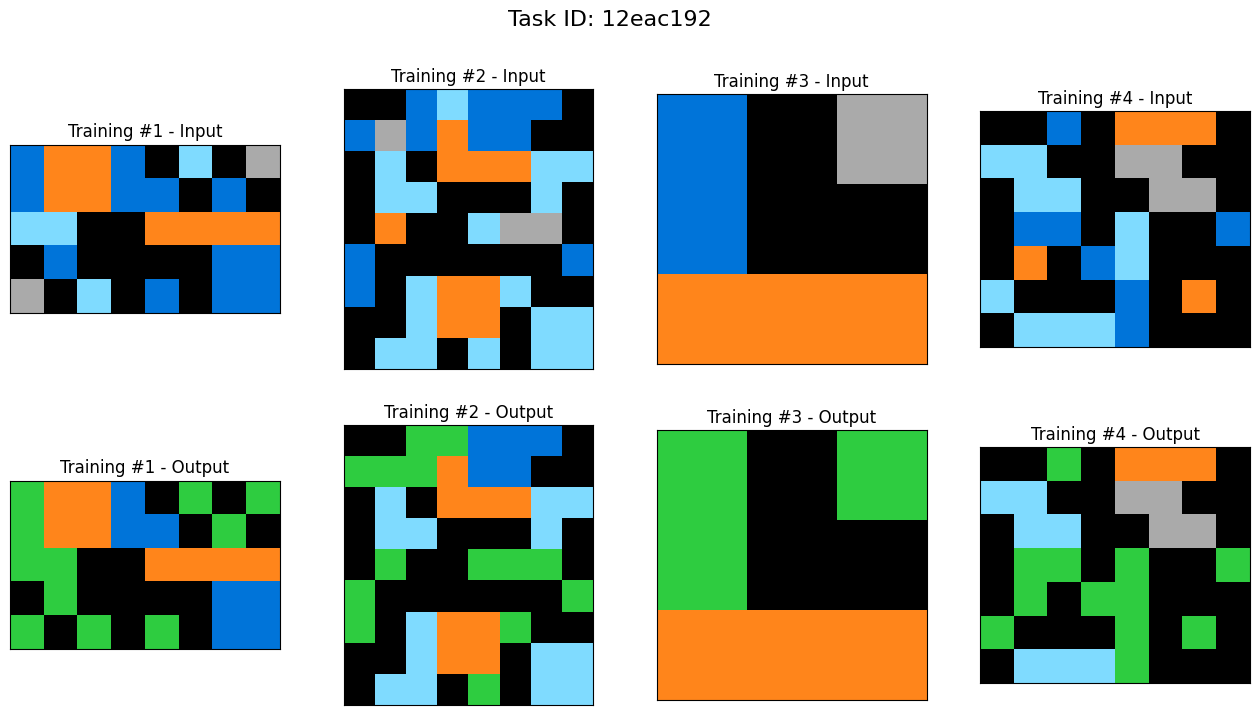

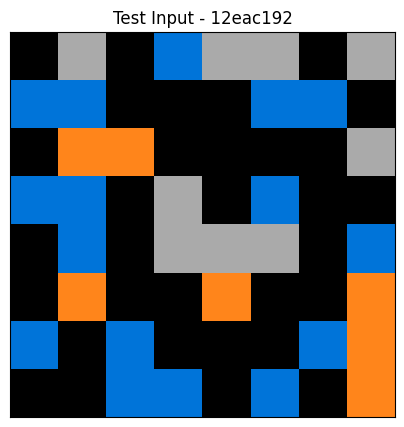

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[1 7 7 1 0 8 0 5]
 [1 7 7 1 1 0 1 0]
 [8 8 0 0 7 7 7 7]
 [0 1 0 0 0 0 1 1]
 [5 0 8 0 1 0 1 1]]

Training Output (first example):
[[3 7 7 1 0 3 0 3]
 [3 7 7 1 1 0 3 0]
 [3 3 0 0 7 7 7 7]
 [0 3 0 0 0 0 1 1]
 [3 0 3 0 3 0 1 1]]
----------------------------------------

Task: 22208ba4


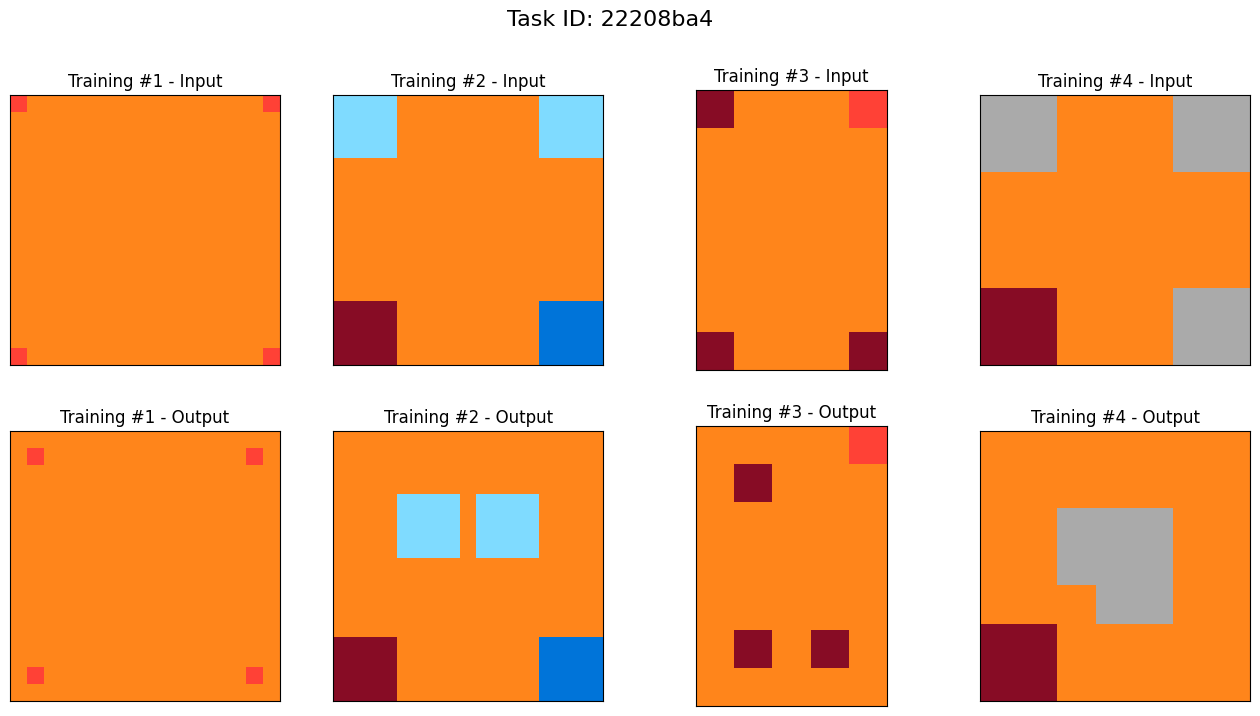

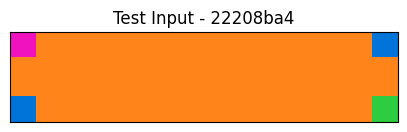

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2]]

Training Output (first example):
[[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 2 7 7 7 7 7 7 7 7 7 7 7 7 2 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7

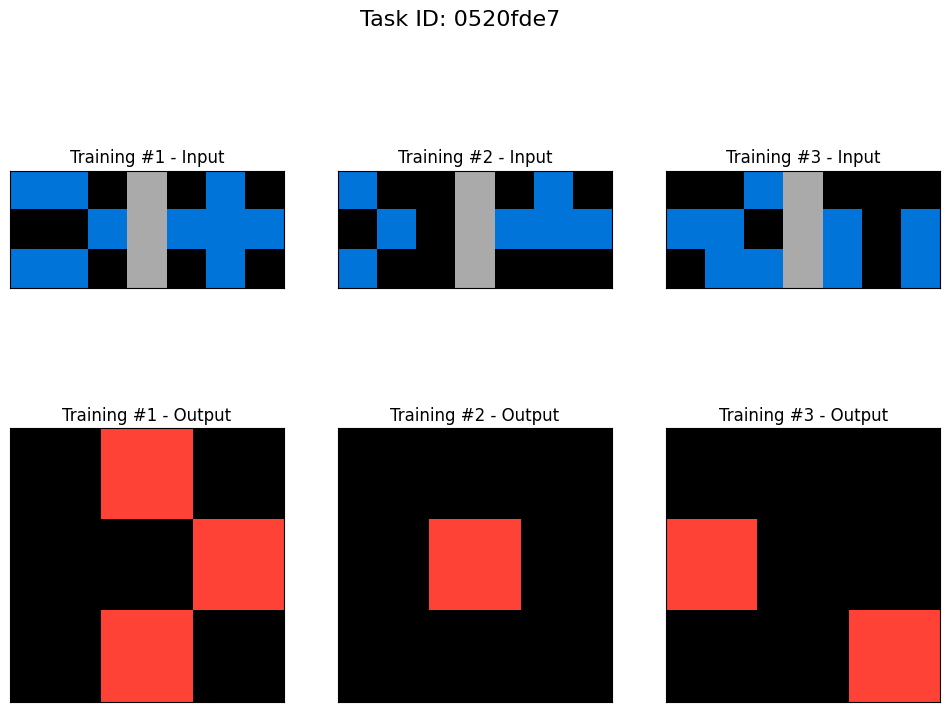

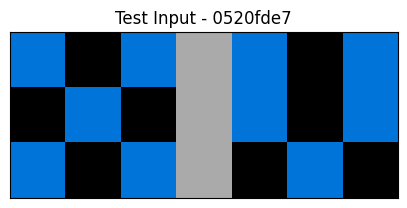

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[1 1 0 5 0 1 0]
 [0 0 1 5 1 1 1]
 [1 1 0 5 0 1 0]]

Training Output (first example):
[[0 2 0]
 [0 0 2]
 [0 2 0]]
----------------------------------------

GPU 1 Training Data Samples
GPU 1 assigned 60 training tasks

Task: 281123b4


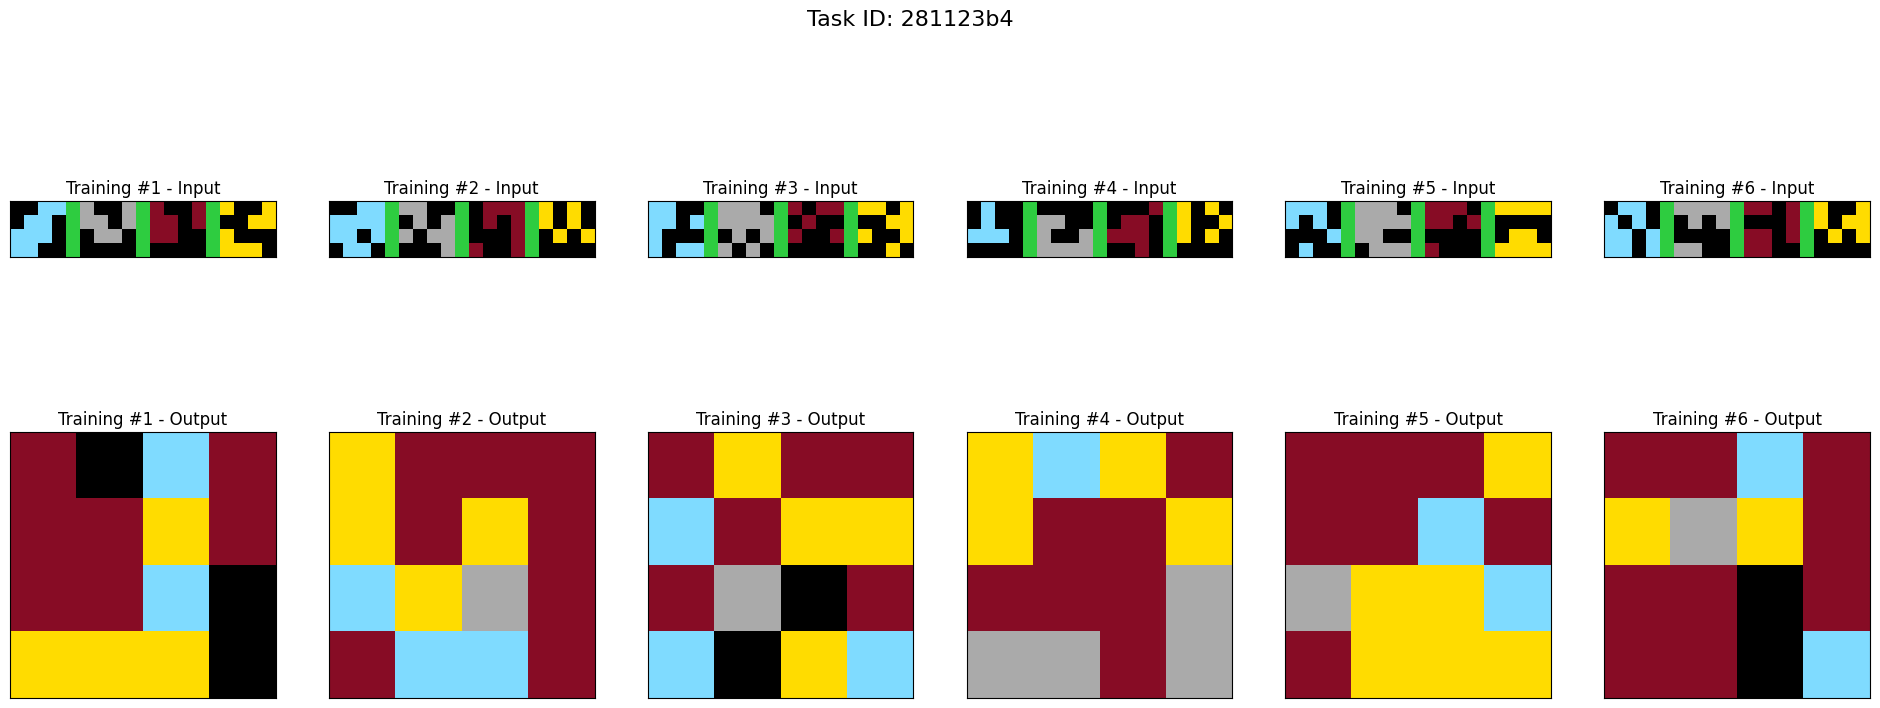

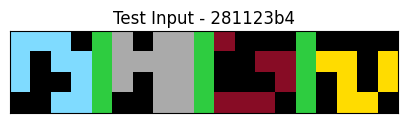

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[0 0 8 8 3 5 0 0 5 3 9 0 0 9 3 4 0 0 4]
 [0 8 8 0 3 5 5 0 5 3 9 9 0 9 3 0 0 4 4]
 [8 8 8 0 3 0 5 5 0 3 9 9 0 0 3 4 0 0 0]
 [8 8 0 0 3 0 0 0 0 3 0 0 0 0 3 4 4 4 0]]

Training Output (first example):
[[9 0 8 9]
 [9 9 4 9]
 [9 9 8 0]
 [4 4 4 0]]
----------------------------------------

Task: 342dd610


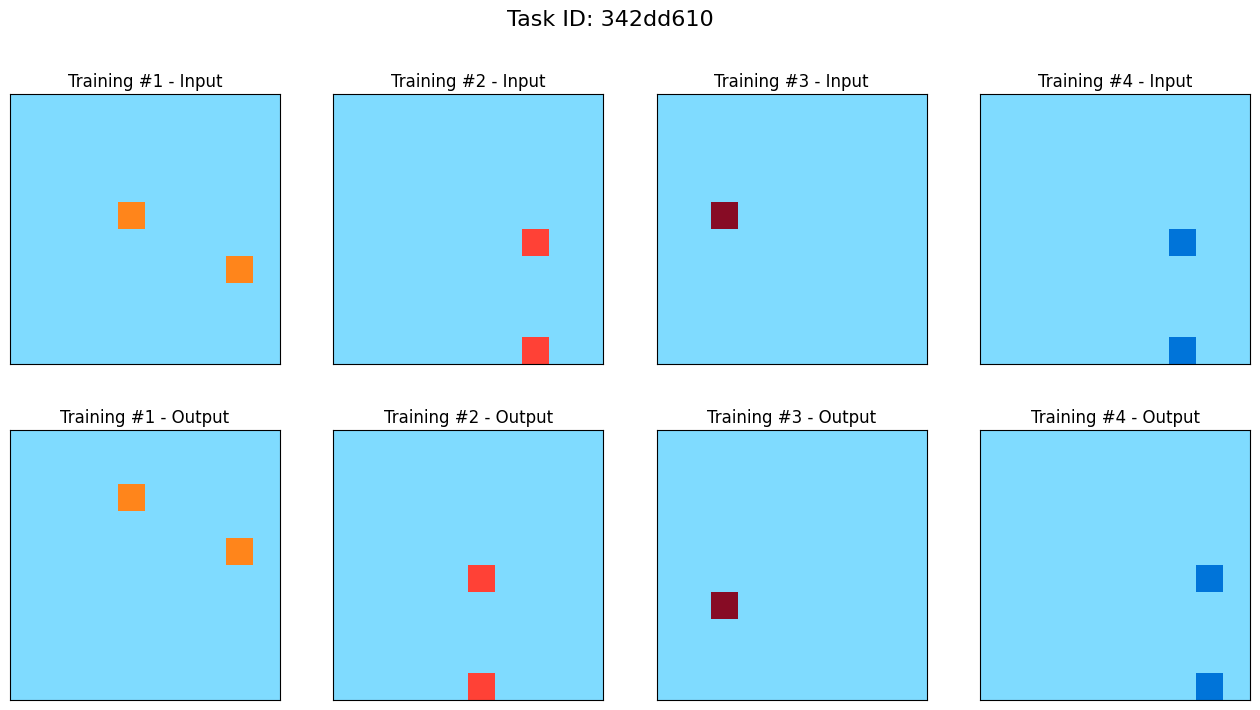

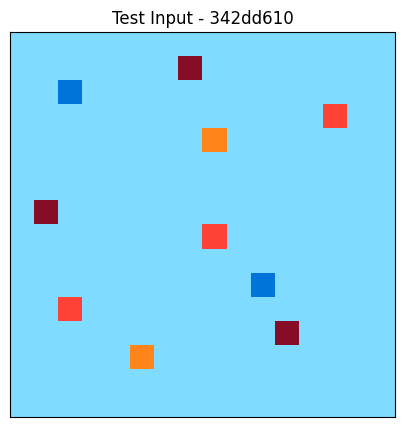

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 7 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 7 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]]

Training Output (first example):
[[8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 7 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 7 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 8 8 8 8]]
----------------------------------------

Task: 1f642eb9


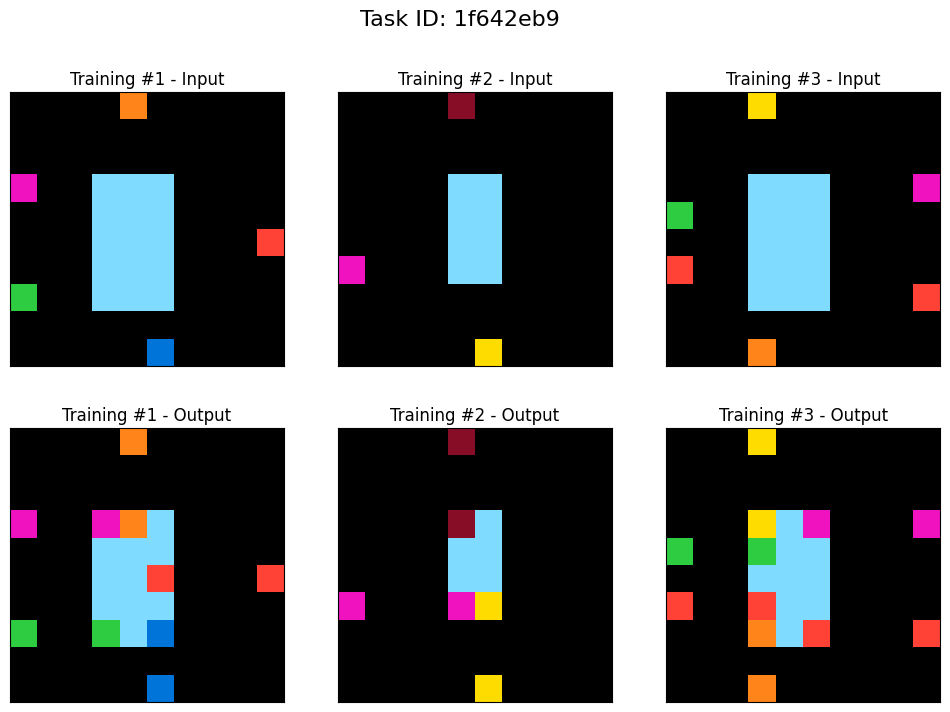

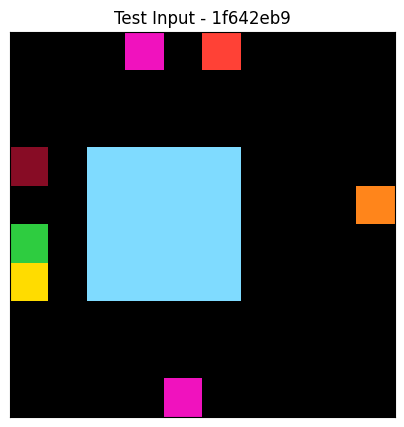

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[0 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [6 0 0 8 8 8 0 0 0 0]
 [0 0 0 8 8 8 0 0 0 0]
 [0 0 0 8 8 8 0 0 0 2]
 [0 0 0 8 8 8 0 0 0 0]
 [3 0 0 8 8 8 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]

Training Output (first example):
[[0 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [6 0 0 6 7 8 0 0 0 0]
 [0 0 0 8 8 8 0 0 0 0]
 [0 0 0 8 8 2 0 0 0 2]
 [0 0 0 8 8 8 0 0 0 0]
 [3 0 0 3 8 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
----------------------------------------

GPU 2 Training Data Samples
GPU 2 assigned 60 training tasks

Task: 13713586


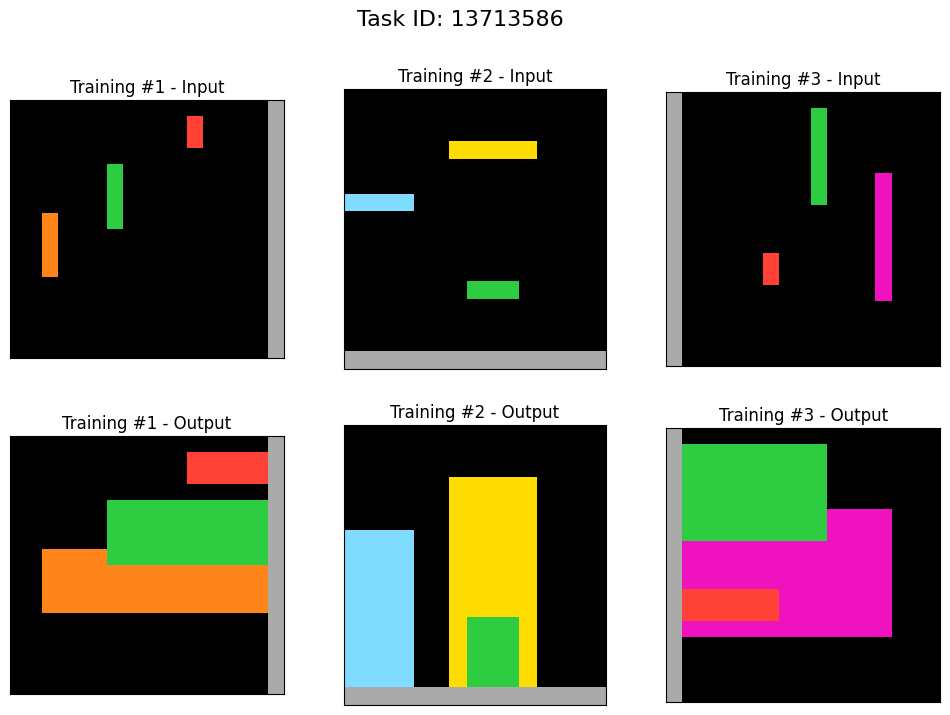

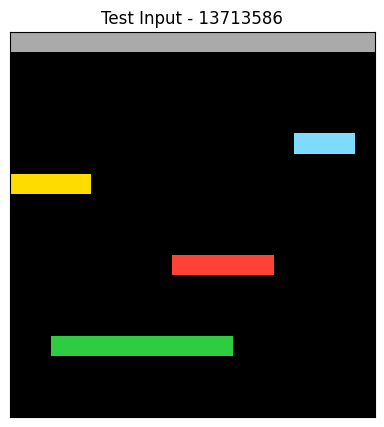

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 5]
 [0 0 7 0 0 0 3 0 0 0 0 0 0 0 0 0 5]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]

Training Output (first example):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 5]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 5]
 [0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 5]
 [0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 5]
 [0 0 7 7 7 7 3 3 3 3 3 3 3 3 3 3 5]
 [0 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5]
 [0 0 7 

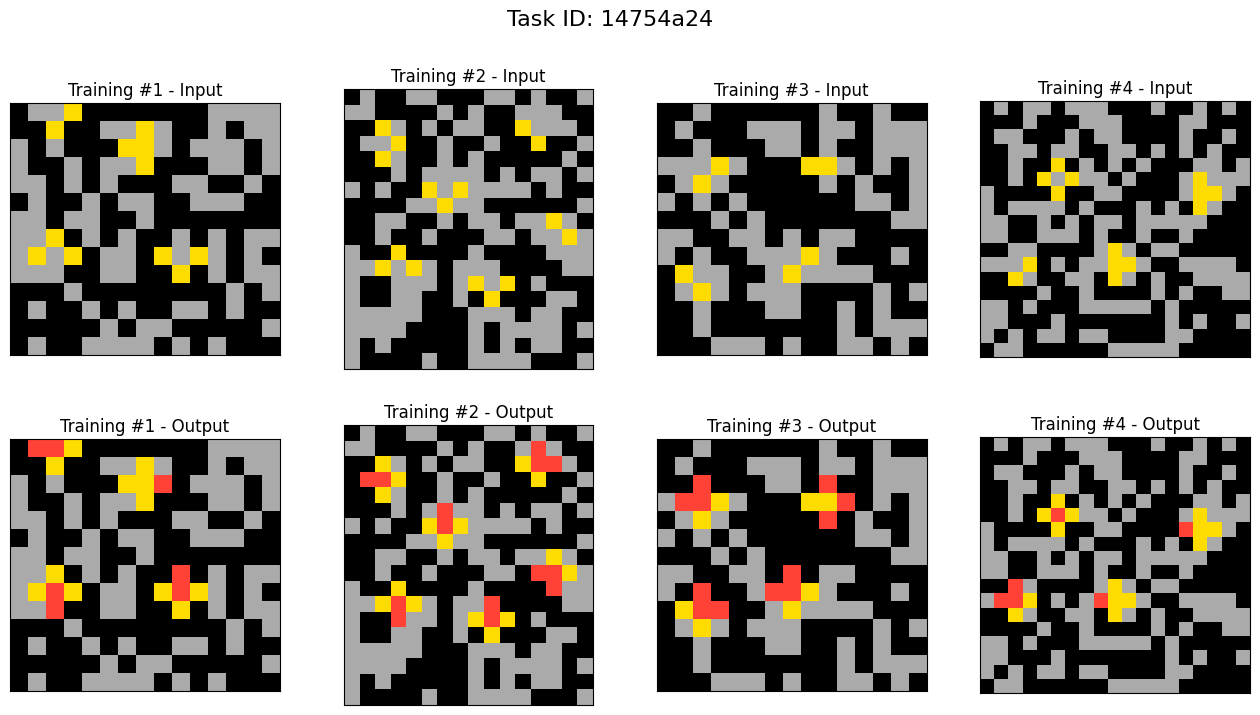

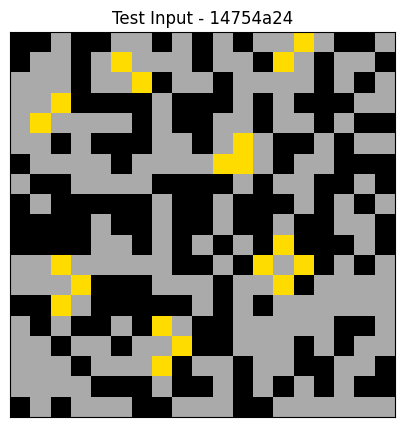

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[0 5 5 4 0 0 0 0 0 0 0 5 5 5 5]
 [0 0 4 0 0 5 5 4 5 0 0 5 0 5 5]
 [5 0 5 0 0 0 4 4 5 0 5 5 5 0 5]
 [5 0 0 5 0 5 5 4 0 0 0 5 5 0 5]
 [5 5 0 5 0 5 0 0 0 5 5 0 0 5 0]
 [0 5 0 0 5 0 5 5 0 0 5 5 5 0 0]
 [5 5 0 5 5 0 0 5 0 0 0 0 0 0 0]
 [5 5 4 0 5 0 5 0 0 5 0 5 0 5 5]
 [5 4 5 4 0 5 5 0 4 5 4 5 0 5 0]
 [5 5 5 0 0 5 5 0 0 4 0 5 0 5 5]
 [0 0 0 5 0 0 0 0 0 0 0 0 5 0 5]
 [0 5 0 0 5 0 5 0 0 5 5 0 5 0 0]
 [0 0 0 0 0 5 0 5 5 0 0 0 0 0 5]
 [0 5 0 0 5 5 5 5 0 5 0 5 0 0 0]]

Training Output (first example):
[[0 2 2 4 0 0 0 0 0 0 0 5 5 5 5]
 [0 0 4 0 0 5 5 4 5 0 0 5 0 5 5]
 [5 0 5 0 0 0 4 4 2 0 5 5 5 0 5]
 [5 0 0 5 0 5 5 4 0 0 0 5 5 0 5]
 [5 5 0 5 0 5 0 0 0 5 5 0 0 5 0]
 [0 5 0 0 5 0 5 5 0 0 5 5 5 0 0]
 [5 5 0 5 5 0 0 5 0 0 0 0 0 0 0]
 [5 5 4 0 5 0 5 0 0 2 0 5 0 5 5]
 [5 4 2 4 0 5 5 0 4 2 4 5 0 5 0]
 [5 5 2 0 0 5 5 0 0 4 0 5 0 5 5]
 [0 0 0 5 0 0 0 0 0 0 0 0 5 0 5]
 [0 5 0 0 5 0 5 0 0 5 5 0 5 0 0]
 [0 0 0 0 0 5 0 5 5 0 0 0 0 0 5]
 [0 5 0 0 5 5 5 5 0 5 0 5 0 0 0]]
--------

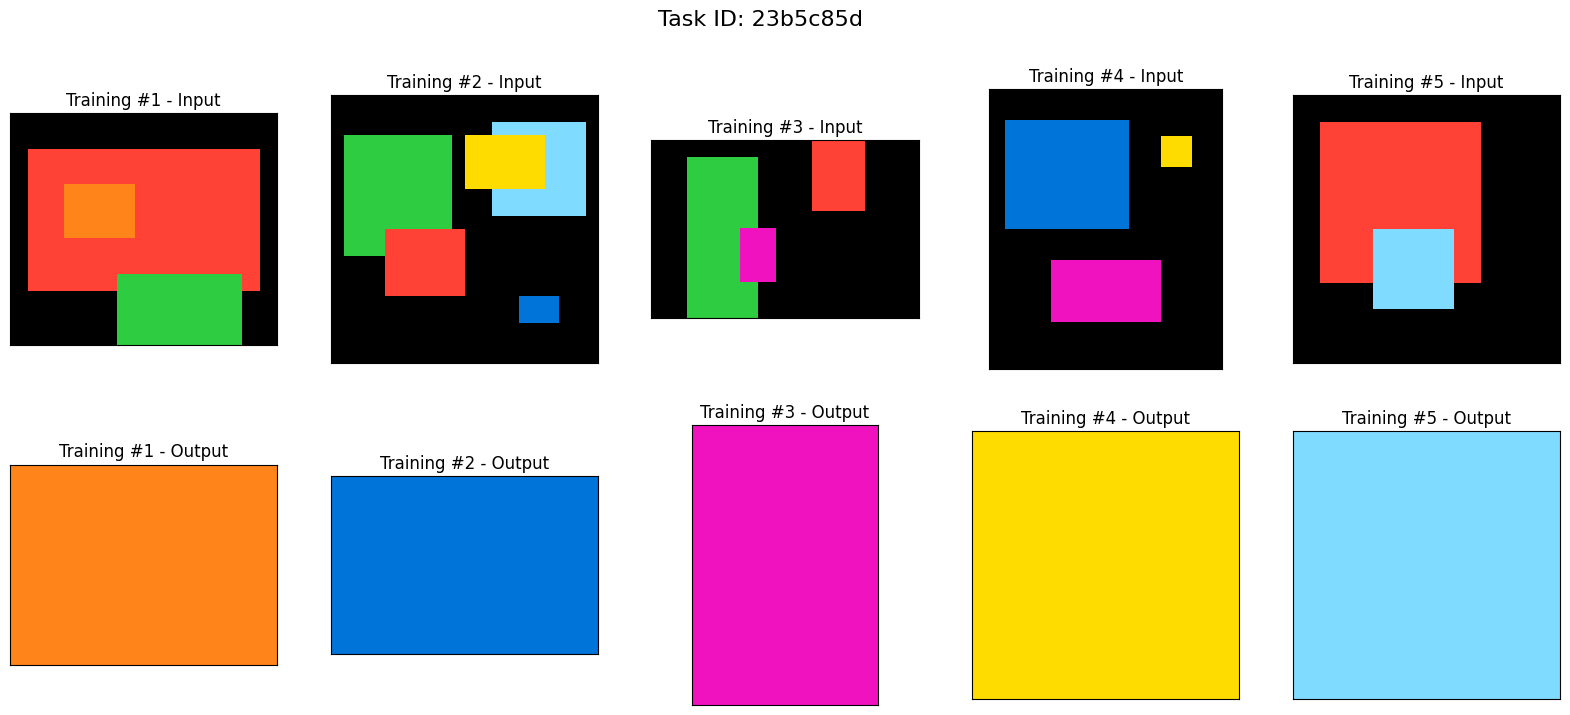

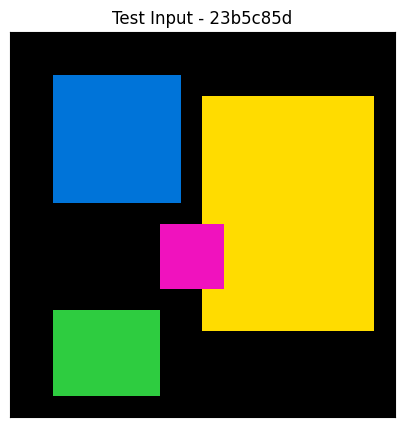

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [0 2 2 7 7 7 7 2 2 2 2 2 2 2 0]
 [0 2 2 7 7 7 7 2 2 2 2 2 2 2 0]
 [0 2 2 7 7 7 7 2 2 2 2 2 2 2 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
 [0 2 2 2 2 2 3 3 3 3 3 3 3 2 0]
 [0 0 0 0 0 0 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 3 3 3 3 3 3 3 0 0]]

Training Output (first example):
[[7 7 7 7]
 [7 7 7 7]
 [7 7 7 7]]
----------------------------------------

GPU 3 Training Data Samples
GPU 3 assigned 60 training tasks

Task: 09c534e7


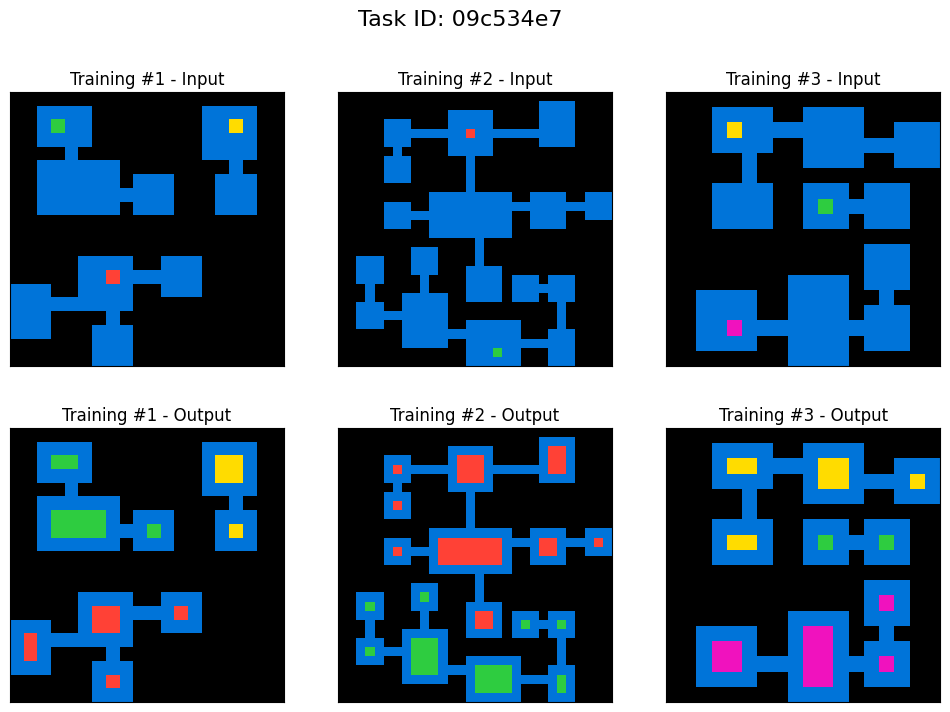

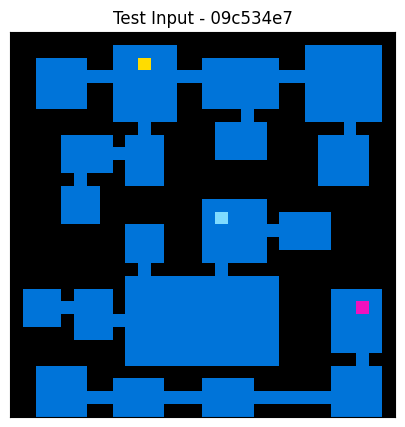

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [0 0 1 3 1 1 0 0 0 0 0 0 0 0 1 1 4 1 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0]
 [0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 2 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]]

Training Output (first example):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 

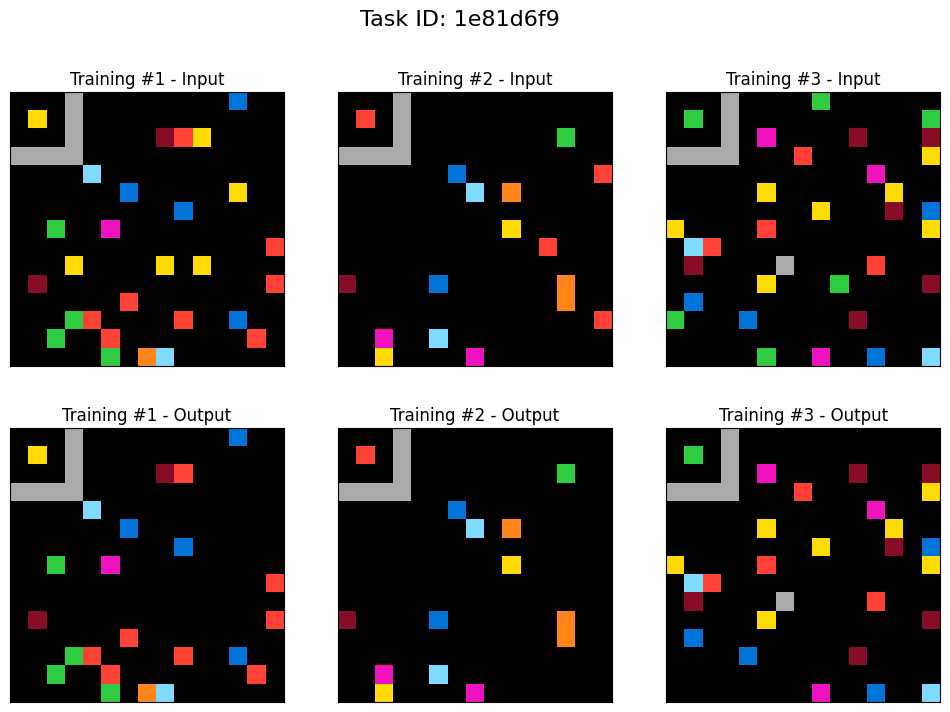

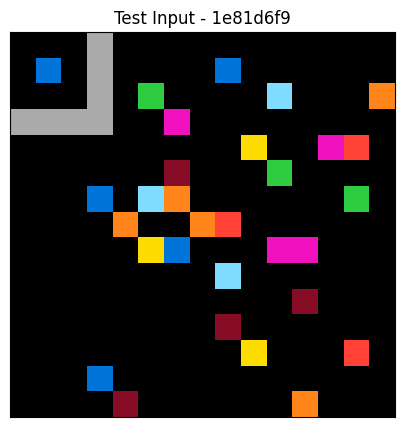

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[0 0 0 5 0 0 0 0 0 0 0 0 1 0 0]
 [0 4 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 9 2 4 0 0 0 0]
 [5 5 5 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 3 0 0 6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 4 0 0 0 0 4 0 4 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 3 2 0 0 0 0 2 0 0 1 0 0]
 [0 0 3 0 0 2 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 3 0 7 8 0 0 0 0 0 0]]

Training Output (first example):
[[0 0 0 5 0 0 0 0 0 0 0 0 1 0 0]
 [0 4 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 9 2 0 0 0 0 0]
 [5 5 5 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 3 0 0 6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 3 2 0 0 0 0 2 0 0 1 0 0]
 [0 0 3 0

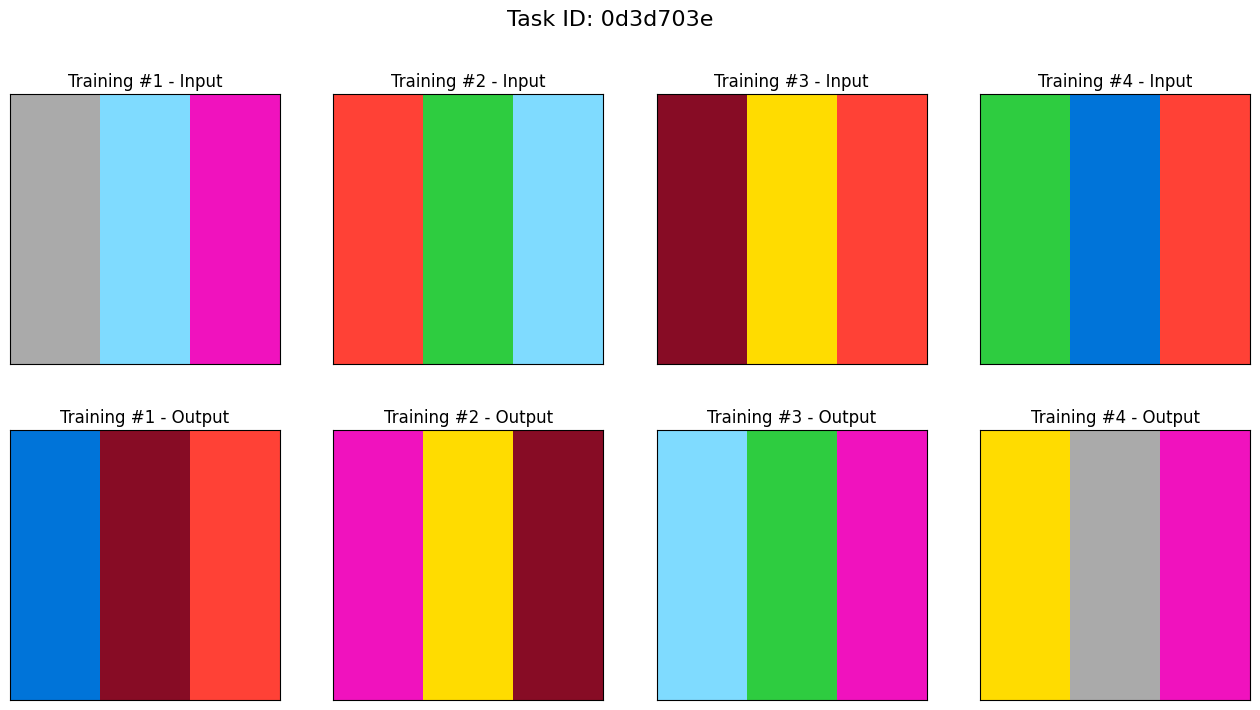

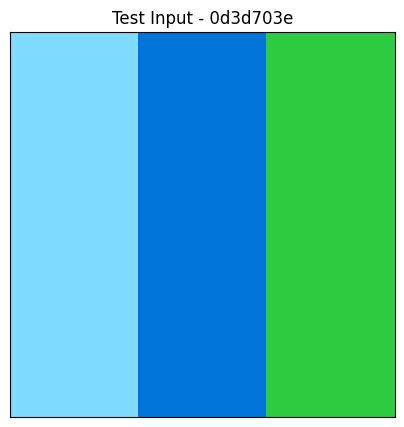

<Figure size 640x480 with 0 Axes>

Training Input (first example):
[[5 8 6]
 [5 8 6]
 [5 8 6]]

Training Output (first example):
[[1 9 2]
 [1 9 2]
 [1 9 2]]
----------------------------------------


In [9]:
# Simplified ARC data visualization script (English version)
from arc_loader import *
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import json
import os

# Create ARC color map
cmap = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

# Load data directly from file
arc_challenge_file = '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'

# Load original data
with open(arc_challenge_file, 'r') as f:
    arc_data = json.load(f)

# Set random seeds
np.random.seed(42)
random.seed(42)

def visualize_arc_example(train_data, test_data, task_id):
    """Visualize training and test data for an ARC task"""
    # Get number of training and test examples
    n_train = len(train_data)
    n_test = len(test_data)
    
    # Create figure large enough for all examples
    fig, axes = plt.subplots(2, max(n_train, n_test), figsize=(4*max(n_train, n_test), 8))
    fig.suptitle(f"Task ID: {task_id}", fontsize=16)
    
    # Visualize training data
    for i in range(n_train):
        # Input
        axes[0, i].imshow(train_data[i]['input'], cmap=cmap, norm=norm)
        axes[0, i].grid(True, which='both', color='lightgrey', linewidth=0.5)
        axes[0, i].set_title(f"Training #{i+1} - Input")
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        
        # Output
        axes[1, i].imshow(train_data[i]['output'], cmap=cmap, norm=norm)
        axes[1, i].grid(True, which='both', color='lightgrey', linewidth=0.5)
        axes[1, i].set_title(f"Training #{i+1} - Output")
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
    
    # Handle test data visualization
    for i in range(n_test):
        if i < n_train:
            # Already have training data in this column
            pass
        else:
            # Hide unused training cells
            if i >= n_train:
                axes[0, i].axis('off')
                axes[1, i].axis('off')
    
    # Show first test input
    if n_test > 0:
        # Create separate figure for test input
        plt.figure(figsize=(5, 5))
        plt.imshow(test_data[0]['input'], cmap=cmap, norm=norm)
        plt.grid(True, which='both', color='lightgrey', linewidth=0.5)
        plt.title(f"Test Input - {task_id}")
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Simulate 4 GPU data splitting
task_ids = list(arc_data.keys())
random.shuffle(task_ids)  # Shuffle task order

# Assign tasks to each GPU
gpu_tasks = {}
for gpu_id in range(4):
    # Simple equal division - each GPU gets 1/4 of tasks
    start_idx = gpu_id * len(task_ids) // 4
    end_idx = (gpu_id + 1) * len(task_ids) // 4
    gpu_tasks[gpu_id] = task_ids[start_idx:end_idx]

# Display training data samples for each GPU
for gpu_id in range(4):
    assigned_tasks = gpu_tasks[gpu_id]
    print(f"\n{'='*40}\nGPU {gpu_id} Training Data Samples\n{'='*40}")
    print(f"GPU {gpu_id} assigned {len(assigned_tasks)} training tasks")
    
    # Show only first 3 examples
    samples = assigned_tasks[:3]
    
    for task_id in samples:
        print(f"\nTask: {task_id}")
        
        # Get training and test data for this task
        train_data = arc_data[task_id]['train']
        test_data = arc_data[task_id]['test']
        
        # Visualize
        visualize_arc_example(train_data, test_data, task_id)
        
        # Print data matrices
        print("Training Input (first example):")
        print(np.array(train_data[0]['input']))
        print("\nTraining Output (first example):")
        print(np.array(train_data[0]['output']))
        print("-" * 40)

In [10]:
%%python --bg --proc train_proc0
from common_stuff import *
start_training(gpu=0)

In [11]:
%%python --bg --proc train_proc1
from common_stuff import *
start_training(gpu=1)

In [12]:
%%python --bg --proc train_proc2
from common_stuff import *
start_training(gpu=2)

In [13]:
%%python --bg --proc train_proc3
from common_stuff import *
start_training(gpu=3)

In [14]:
%%python --bg --proc infer_proc0
from common_stuff import *
start_inference(gpu=0)

In [15]:
%%python --bg --proc infer_proc1
from common_stuff import *
start_inference(gpu=1)

In [16]:
%%python --bg --proc infer_proc2
from common_stuff import *
start_inference(gpu=2)

In [17]:
%%python --bg --proc infer_proc3
from common_stuff import *
start_inference(gpu=3)

In [18]:
proc_exit_codes = await wait_for_subprocesses(
    train_proc0, train_proc1, train_proc2, train_proc3,
    infer_proc0, infer_proc1, infer_proc2, infer_proc3,
    print_output=True or arc_test_set.is_fake
)
print(f'*** Subprocesses exit codes: {proc_exit_codes}')
assert all(x==0 for x in proc_exit_codes)

3. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
1. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
0. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
2. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
3. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_

0. *** Load challanges from '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'...
0. *** -> Fake test set detected, setting flag 'is_fake' to True.
0. *** Load solutions from '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'...
0. *** Load base model and tokenizer from '/kaggle/input/wb55l_nemomini_fulleval/transformers/default/1'...
0. 🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
0. ==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.0.
0.    \\   /|    GPU: NVIDIA L4. Max memory: 22.278 GB. Platform = Linux.
0. O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
0. \        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
0.  "-____-"     Free Apache license: http://github.com/unslothai/unsloth
0. Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
0. *** Create new peft model...
0. Unsloth: Casting embed_tokens to float32
0. Unsloth: Casting 

2. Map: 100%|██████████| 320/320 [00:00<00:00, 1392.12 examples/s]
2. max_steps is given, it will override any value given in num_train_epochs


3.  98%|█████████▊| 943/960 [00:02<00:00, 412.38it/s]


1. Map: 100%|██████████| 480/480 [00:00<00:00, 1358.54 examples/s]
1. max_steps is given, it will override any value given in num_train_epochs
2. ==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
2.    \\   /|    Num examples = 320 | Num Epochs = 1
2. O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 1
2. \        /    Total batch size = 8 | Total steps = 5
2.  "-____-"     Number of trainable parameters = 188,760,064
1. ==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
1.    \\   /|    Num examples = 480 | Num Epochs = 1
1. O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 1
1. \        /    Total batch size = 8 | Total steps = 5
1.  "-____-"     Number of trainable parameters = 188,760,064


2. *** Start training run...
2. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for embed_tokens.
2. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for lm_head.
3. 100%|██████████| 960/960 [00:02<00:00, 409.14it/s]


0. Map: 100%|██████████| 960/960 [00:00<00:00, 1044.45 examples/s]
0. max_steps is given, it will override any value given in num_train_epochs


1. *** Start training run...
1. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for embed_tokens.
1. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for lm_head.


3. Map: 100%|██████████| 960/960 [00:00<00:00, 1217.54 examples/s]
3. max_steps is given, it will override any value given in num_train_epochs
0. ==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
0.    \\   /|    Num examples = 960 | Num Epochs = 1
0. O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 1
0. \        /    Total batch size = 8 | Total steps = 5
0.  "-____-"     Number of trainable parameters = 188,760,064
3. ==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
3.    \\   /|    Num examples = 960 | Num Epochs = 1
3. O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 1
3. \        /    Total batch size = 8 | Total steps = 5
3.  "-____-"     Number of trainable parameters = 188,760,064


0. *** Start training run...
0. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for embed_tokens.
0. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for lm_head.
3. *** Start training run...
3. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for embed_tokens.
3. Unsloth: Setting lr = 1.00e-05 instead of 2.00e-04 for lm_head.


2.   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
2.   with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
1.   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
1.   with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
2. /opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
2.   with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(

2. {'train_runtime': 122.1689, 'train_samples_per_second': 0.327, 'train_steps_per_second': 0.041, 'train_loss': 0.07319400310516358, 'epoch': 0.12}
2. *** -> Training took 122.1689 seconds.
2. *** Saving model/tokenizer to '/kaggle/temp/finetuned_model_gpu2'...
2. *** GPU: NVIDIA L4, used 19.3 / 22.3 GB.


0.  60%|██████    | 3/5 [01:45<01:09, 34.51s/it]
6. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
6. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
6. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


6. *** Load challanges from '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'...
6. *** -> Fake test set detected, setting flag 'is_fake' to True.
6. *** Load solutions from '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'...
6. *** Load base model and tokenizer from '/kaggle/temp/finetuned_model_gpu2'...
6. 🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
6. ==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.0.
6.    \\   /|    GPU: NVIDIA L4. Max memory: 22.278 GB. Platform = Linux.
6. O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
6. \        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
6.  "-____-"     Free Apache license: http://github.com/unslothai/unsloth
6. Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
6. *** Augment dataset...
6. *** Reducing task size to max. 8192 tokens (7260 input + 932 generated)...
6. 100%|██████████|

1. 100%|██████████| 5/5 [02:36<00:00, 31.26s/it]


6.   0%|          | 0/8 [00:10<?, ?it/s]
6.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 349+ 58> 58 ALL_CORRECT:0.00004|0.00004 [3aa6fb7a_0.rot90.rot90.rot90.permute6019845237.ex01.out0]
6.   0%|          | 0/8 [00:10<?, ?it/s]
6.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 349+ 58> 58 ALL_CORRECT:0.00006|0.00007 [3aa6fb7a_0.transpose.rot90.rot90.rot90.permute0372196854.ex10.out0]
6.   0%|          | 0/8 [00:10<?, ?it/s]


3. 100%|██████████| 5/5 [02:34<00:00, 30.88s/it]


1. {'train_runtime': 156.2963, 'train_samples_per_second': 0.256, 'train_steps_per_second': 0.032, 'train_loss': 0.062105697393417356, 'epoch': 0.08}
1. *** -> Training took 156.2963 seconds.
1. *** Saving model/tokenizer to '/kaggle/temp/finetuned_model_gpu1'...
1. *** GPU: NVIDIA L4, used 19.3 / 22.3 GB.
6.  12%|█▎        | 1/8 [00:10<01:14, 10.65s/it]
6.  acc:   2/  2=99.9% (2-guess),   2/  2=99.9% (any); tok: 427+ 23> 23 ALL_CORRECT:0.00006|0.00006 [28bf18c6_0.permute0185347962.ex120.out0]
6.  12%|█▎        | 1/8 [00:12<01:14, 10.65s/it]
6.  acc:   2/  2=99.9% (2-guess),   2/  2=99.9% (any); tok: 436+ 26> 26 ALL_CORRECT:0.00000|0.00001 [28bf18c6_0.transpose.permute7916520438.ex021.out0]
3. {'train_runtime': 154.3865, 'train_samples_per_second': 0.259, 'train_steps_per_second': 0.032, 'train_loss': 0.04558286666870117, 'epoch': 0.04}
3. *** -> Training took 154.3865 seconds.
3. *** Saving model/tokenizer to '/kaggle/temp/finetuned_model_gpu3'...
3. *** GPU: NVIDIA L4, used 19.3 / 22

0. 100%|██████████| 5/5 [02:41<00:00, 32.32s/it]
5. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
5. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


0. {'train_runtime': 161.5994, 'train_samples_per_second': 0.248, 'train_steps_per_second': 0.031, 'train_loss': 0.07723459005355834, 'epoch': 0.04}
0. *** -> Training took 161.5994 seconds.
0. *** Saving model/tokenizer to '/kaggle/temp/finetuned_model_gpu0'...
0. *** GPU: NVIDIA L4, used 20.0 / 22.3 GB.


5. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


6.  25%|██▌       | 2/8 [00:17<00:49,  8.22s/it]
6.  acc:   3/  3=99.9% (2-guess),   3/  3=99.9% (any); tok: 468+ 58> 58 ALL_CORRECT:0.54873|0.54883 [05269061_0.permute9206853714.ex012.out0]
6.  25%|██▌       | 2/8 [00:27<00:49,  8.22s/it]
6.  acc:   3/  3=99.9% (2-guess),   3/  3=99.9% (any); tok: 468+ 58> 58 bad_content:0.98729|0.98740 [05269061_0.permute9206853714.ex012.out1]
5. *** Load challanges from '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'...
5. *** -> Fake test set detected, setting flag 'is_fake' to True.
5. *** Load solutions from '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'...
5. *** Load base model and tokenizer from '/kaggle/temp/finetuned_model_gpu1'...
5. 🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
5. ==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.0.
5.    \\   /|    GPU: NVIDIA L4. Max memory: 22.278 GB. Platform = Linux.
5. O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.9. C

7. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
4. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
7. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
4. Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


5.   0%|          | 0/8 [00:00<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 280+ 38> 38 ALL_CORRECT:0.14896|0.16825 [017c7c7b_0.permute8150729436.ex012.out0]
5.   0%|          | 0/8 [00:05<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 250+ 32> 32 ALL_CORRECT:0.00144|0.06342 [017c7c7b_0.transpose.permute6491583207.ex201.out0]
5.   0%|          | 0/8 [00:05<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 250+ 32> 32 ALL_CORRECT:0.00164|0.00174 [017c7c7b_0.rot90.permute5629138470.ex120.out0]
5.   0%|          | 0/8 [00:05<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 280+ 38> 38 ALL_CORRECT:0.02004|0.02054 [017c7c7b_0.transpose.rot90.permute1957340628.ex012.out0]
5.   0%|          | 0/8 [00:05<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 280+ 38> 38 ALL_CORRECT:0.16096|0.16336 [017c7c7b_0.rot90.rot90.permute8265403971.ex021.out0]
5.   0%|          | 0/8 [00:06<?, ?it/s]


7. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


5.   0%|          | 0/8 [00:08<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 250+ 32> 32 bad_content:0.16432|0.16438 [017c7c7b_0.transpose.rot90.rot90.permute3694028715.ex021.out0]


4. Unsloth 2024.9.post4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


5.   0%|          | 0/8 [00:11<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 250+ 32> 32 ALL_CORRECT:0.08918|0.08923 [017c7c7b_0.rot90.rot90.rot90.permute6157849023.ex210.out0]
5.   0%|          | 0/8 [00:12<?, ?it/s]
5.  acc:   1/  1=99.9% (2-guess),   1/  1=99.9% (any); tok: 280+ 38> 38 ALL_CORRECT:0.07004|0.07177 [017c7c7b_0.transpose.rot90.rot90.rot90.permute4156892370.ex021.out0]
5.   0%|          | 0/8 [00:12<?, ?it/s]
7. *** Load challanges from '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'...
7. *** -> Fake test set detected, setting flag 'is_fake' to True.
7. *** Load solutions from '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'...
7. *** Load base model and tokenizer from '/kaggle/temp/finetuned_model_gpu3'...
7. 🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
7. ==((====))==  Unsloth 2024.9.post4: Fast Mistral patching. Transformers = 4.44.0.
7.    \\   /|    GPU: NVIDIA L4. Max memory: 22.278 GB.

In [19]:
# write submission
from common_stuff import *
with RemapCudaOOM():
    model, formatter, dataset = None, MyFormatter(), None
    decoder = Decoder(formatter, arc_test_set.split_multi_replies(), n_guesses=2, frac_score=True).from_store(infer_params['store'])
    if use_aug_score or arc_test_set.is_fake: decoder.calc_augmented_scores(model=model, store=score_temp_storage, **aug_score_params)
    submission = arc_test_set.get_submission(decoder.run_selection_algo(submission_select_algo))
    with open('submission.json', 'w') as f: json.dump(submission, f)
    if arc_test_set.is_fake:
        decoder.benchmark_selection_algos(selection_algorithms)
        with open('submission.json') as f: reload_submission = json.load(f)
        print('*** Reload score:', arc_test_set.validate_submission(reload_submission))

 acc:   1.0/  1=99.9% (2-guess),   1.0/  1=99.9% (any); tok:   ?+  ?> 22 ALL_CORRECT:0.15659|0.29427 [3cd86f4f_0.transpose.rot90.rot90.rot90.permute7583469012.ex102.out0]
 acc:   2.0/  2=99.9% (2-guess),   2.0/  2=99.9% (any); tok:   ?+  ?> 14 ALL_CORRECT:0.00018|0.00018 [3c9b0459_0.rot90.rot90.permute6081957432.ex1023.out0]
 acc:   3.0/  3=99.9% (2-guess),   3.0/  3=99.9% (any); tok:   ?+  ?> 32 ALL_CORRECT:0.00075|0.31407 [2dee498d_0.transpose.rot90.rot90.rot90.permute2087634195.ex021.out0]
 acc:   4.0/  4=99.9% (2-guess),   4.0/  4=99.9% (any); tok:   ?+  ?> 44 ALL_CORRECT:0.00018|0.00018 [2072aba6_0.transpose.rot90.permute6720348519.ex012.out0]
 acc:   5.0/  5=99.9% (2-guess),   5.0/  5=99.9% (any); tok:   ?+  ?> 14 ALL_CORRECT:0.90003|0.90005 [0d3d703e_0.rot90.rot90.rot90.permute3694028715.ex2130.out0]
 acc:   5.0/  5=99.9% (2-guess),   5.0/  5=99.9% (any); tok:   ?+  ?> 14 bad_content:1.33753|1.33755 [0d3d703e_0.rot90.rot90.rot90.permute3694028715.ex2130.out1]
 acc:   6.0/  6=99.


VISUALIZING RESULTS FROM SUBMISSION.JSON
Found submission file: submission.json
Loaded submission with 240 tasks

Found 259 total predictions to visualize

Task: 017c7c7b - Test #1 (Score: 1/2)


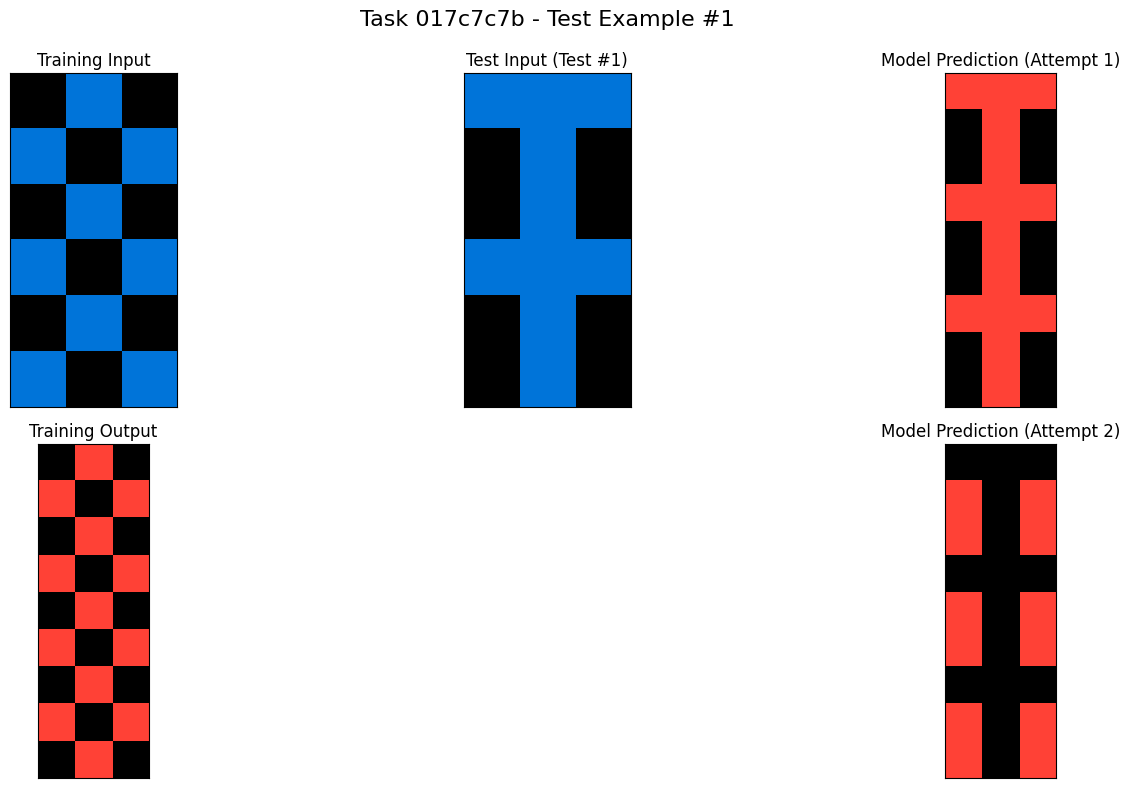



Task: 05269061 - Test #1 (Score: 1/2)


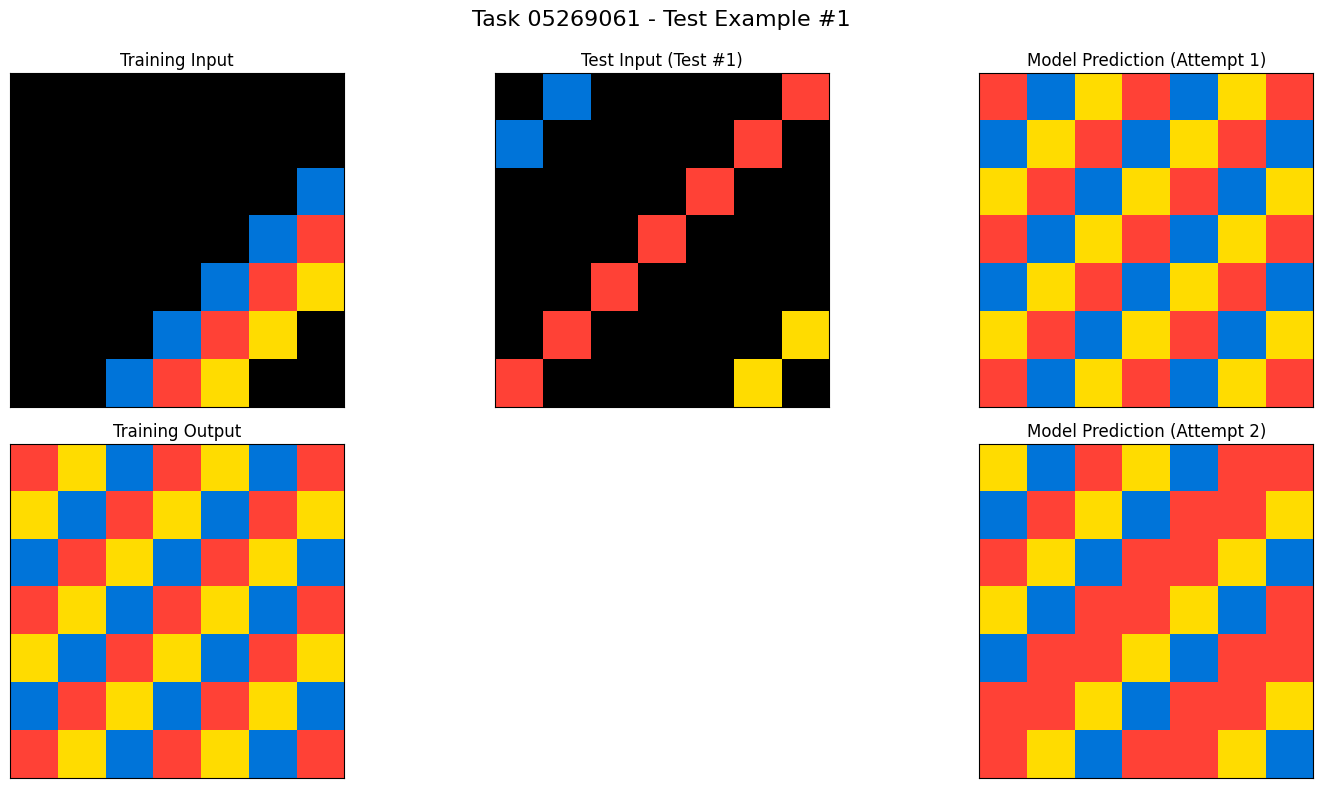



Task: 0bb8deee - Test #1 (Score: 1/2)


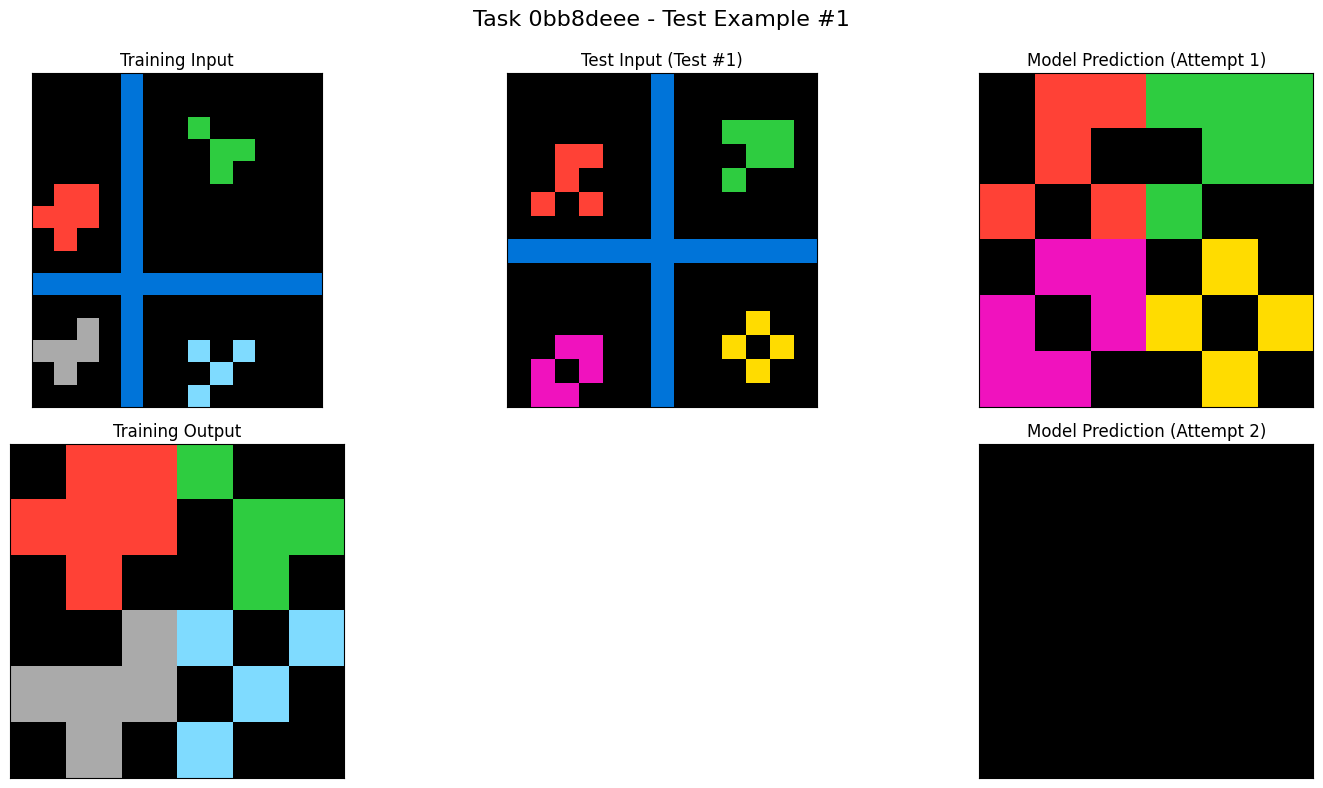



Task: 0d3d703e - Test #1 (Score: 1/2)


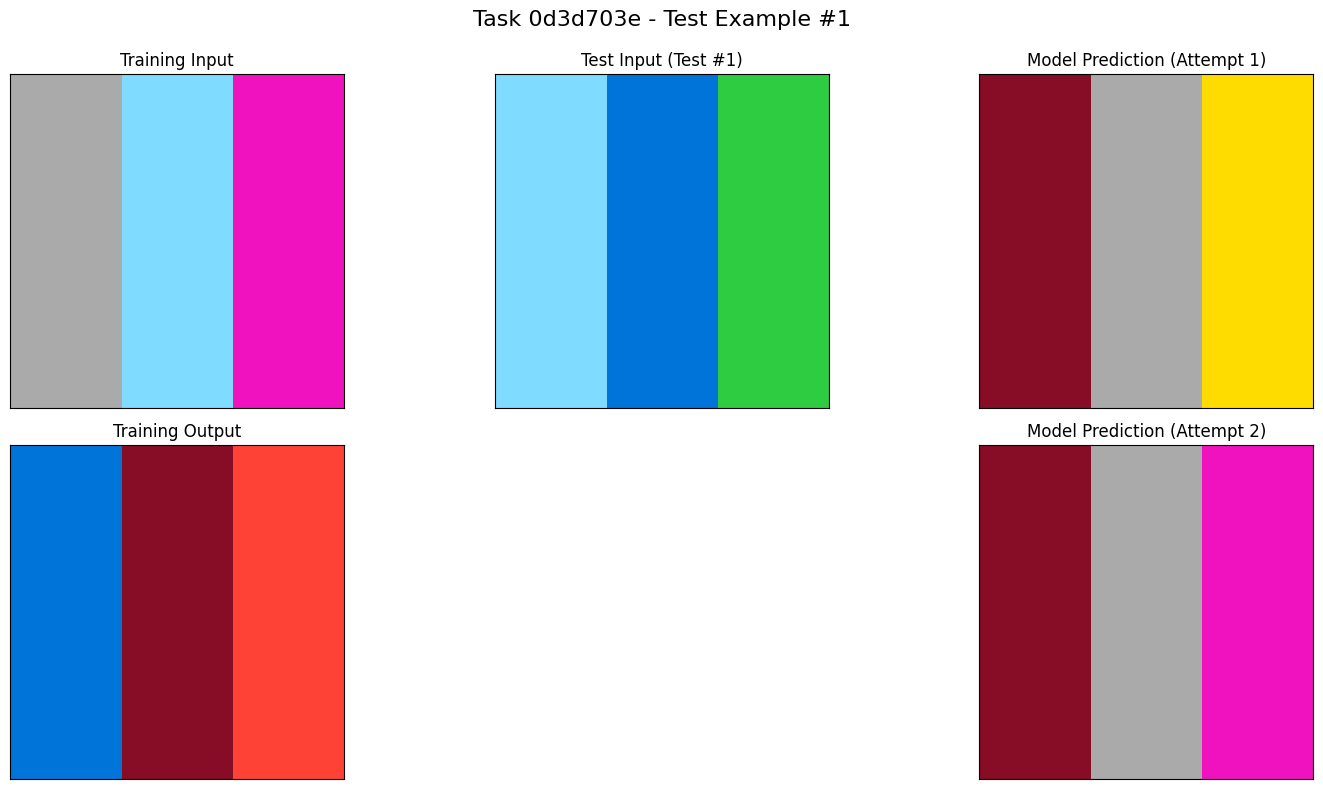



Task: 150deff5 - Test #1 (Score: 1/2)


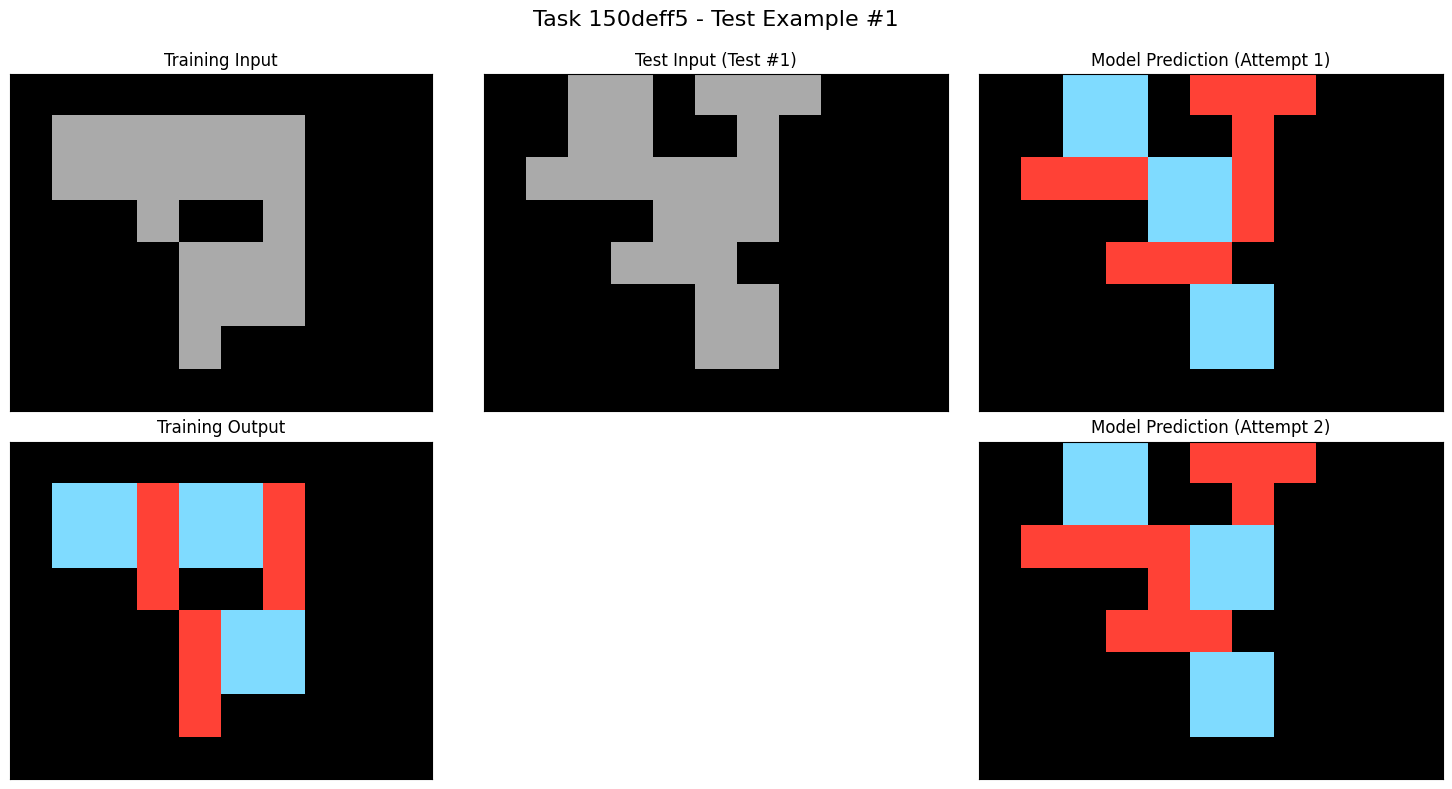



Task: 19bb5feb - Test #1 (Score: 1/2)


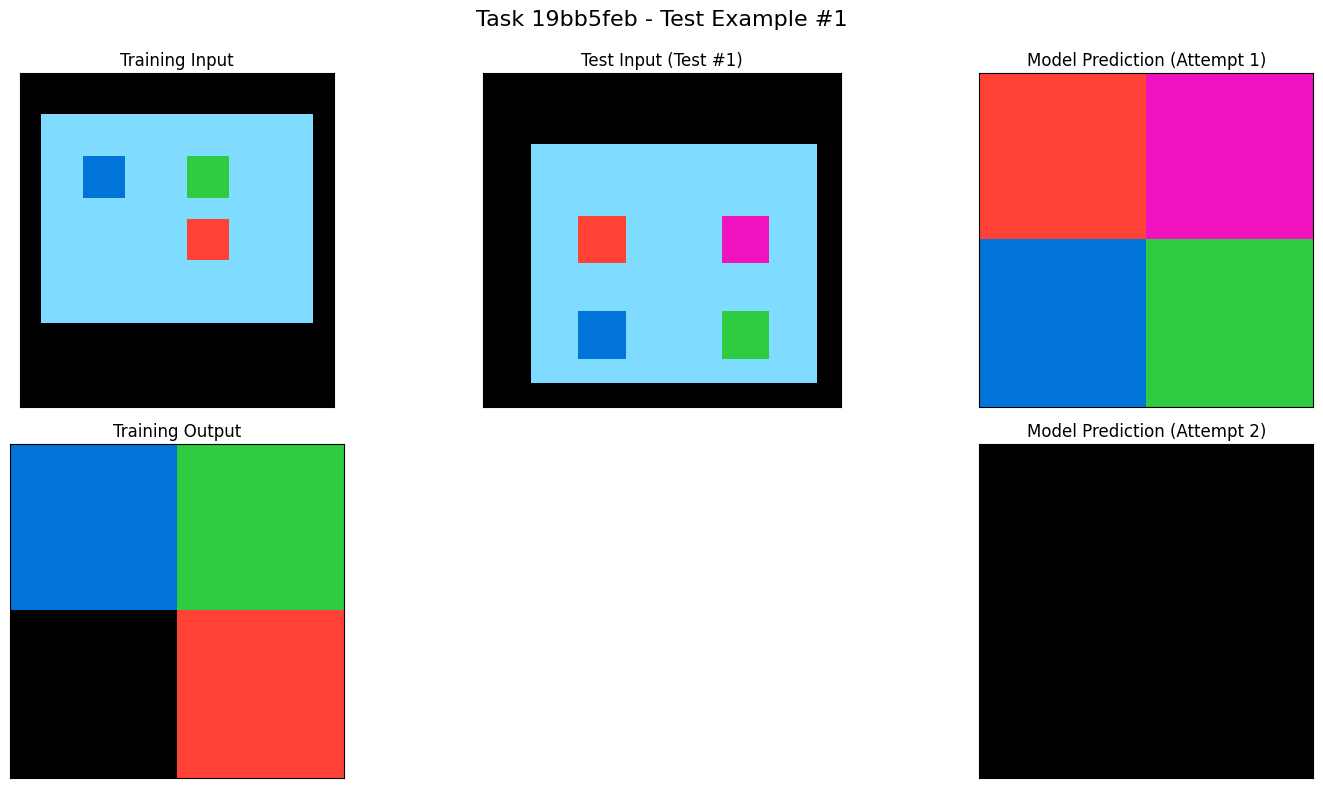



Task: 2072aba6 - Test #1 (Score: 1/2)


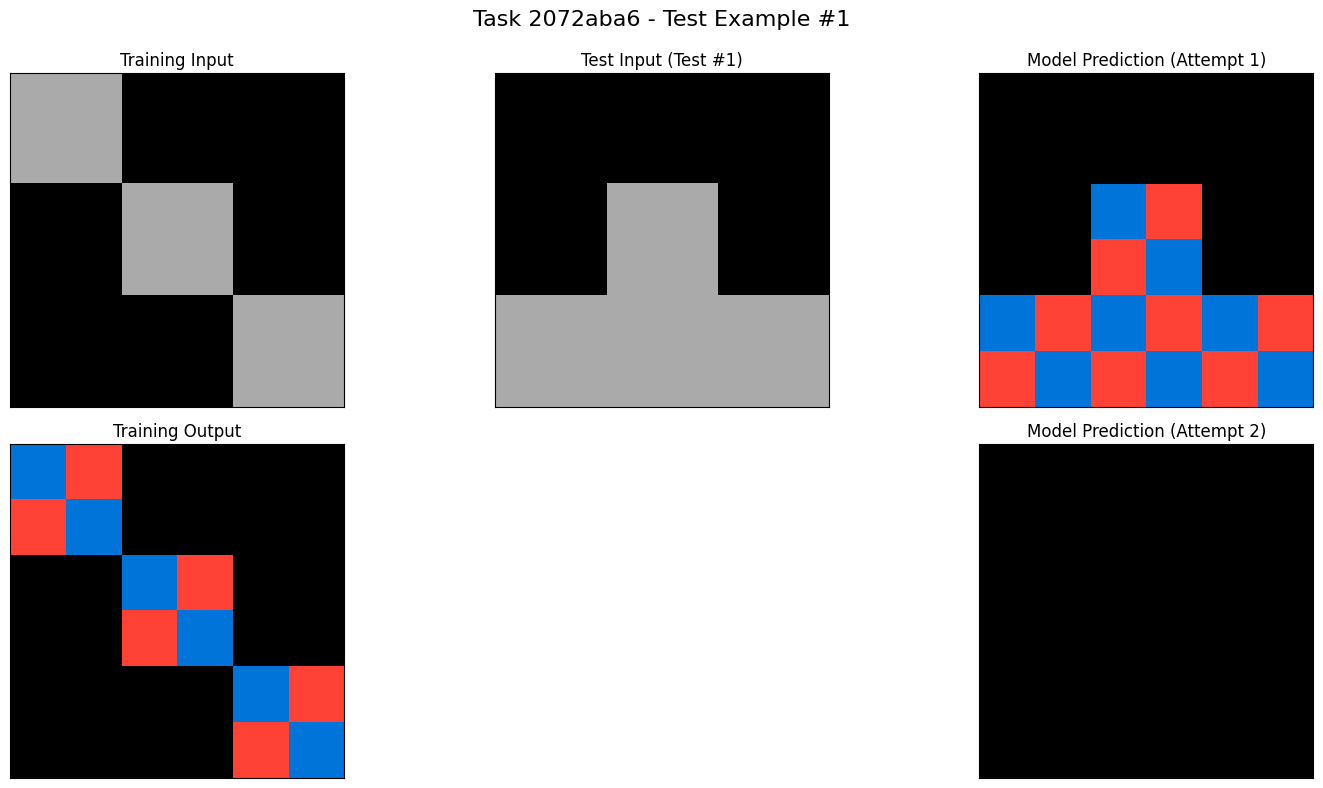



Task: 22eb0ac0 - Test #1 (Score: 1/2)


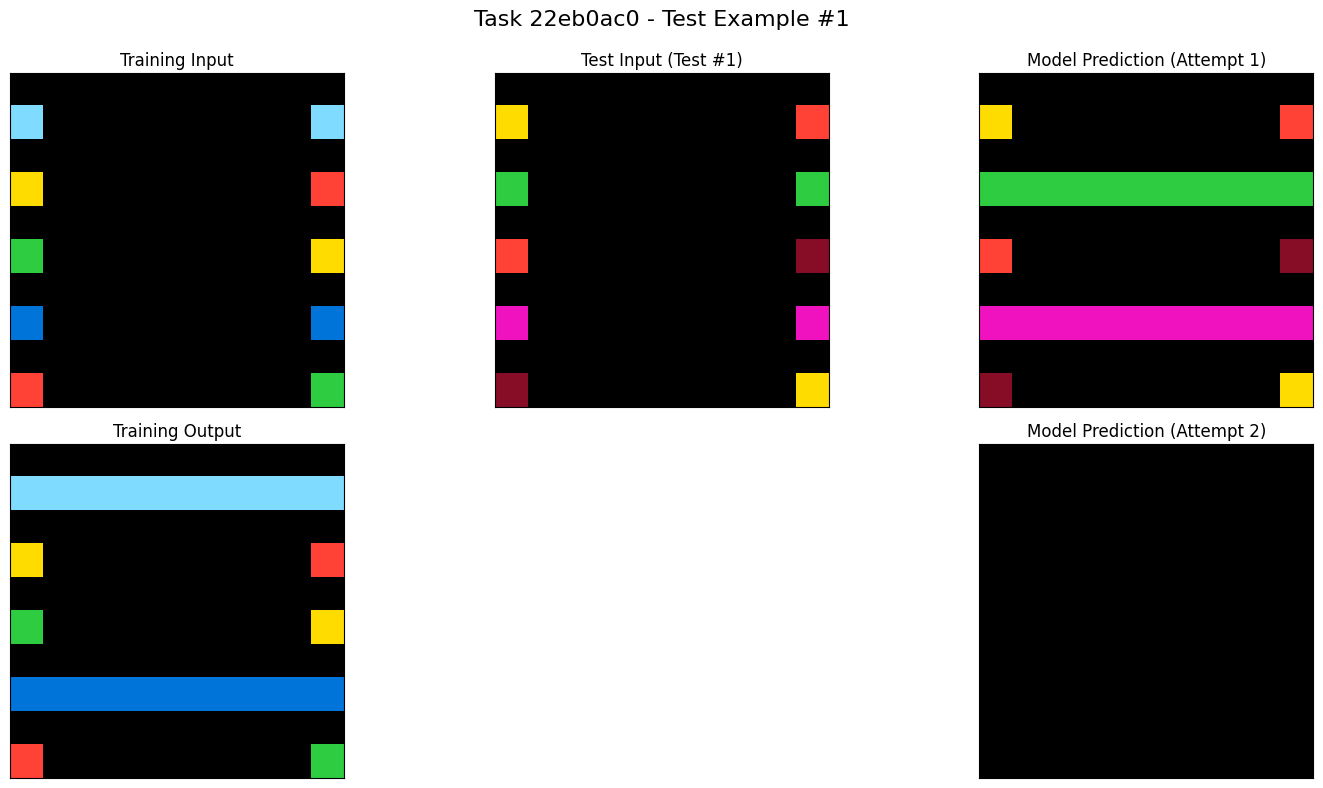



Task: 239be575 - Test #2 (Score: 1/2)


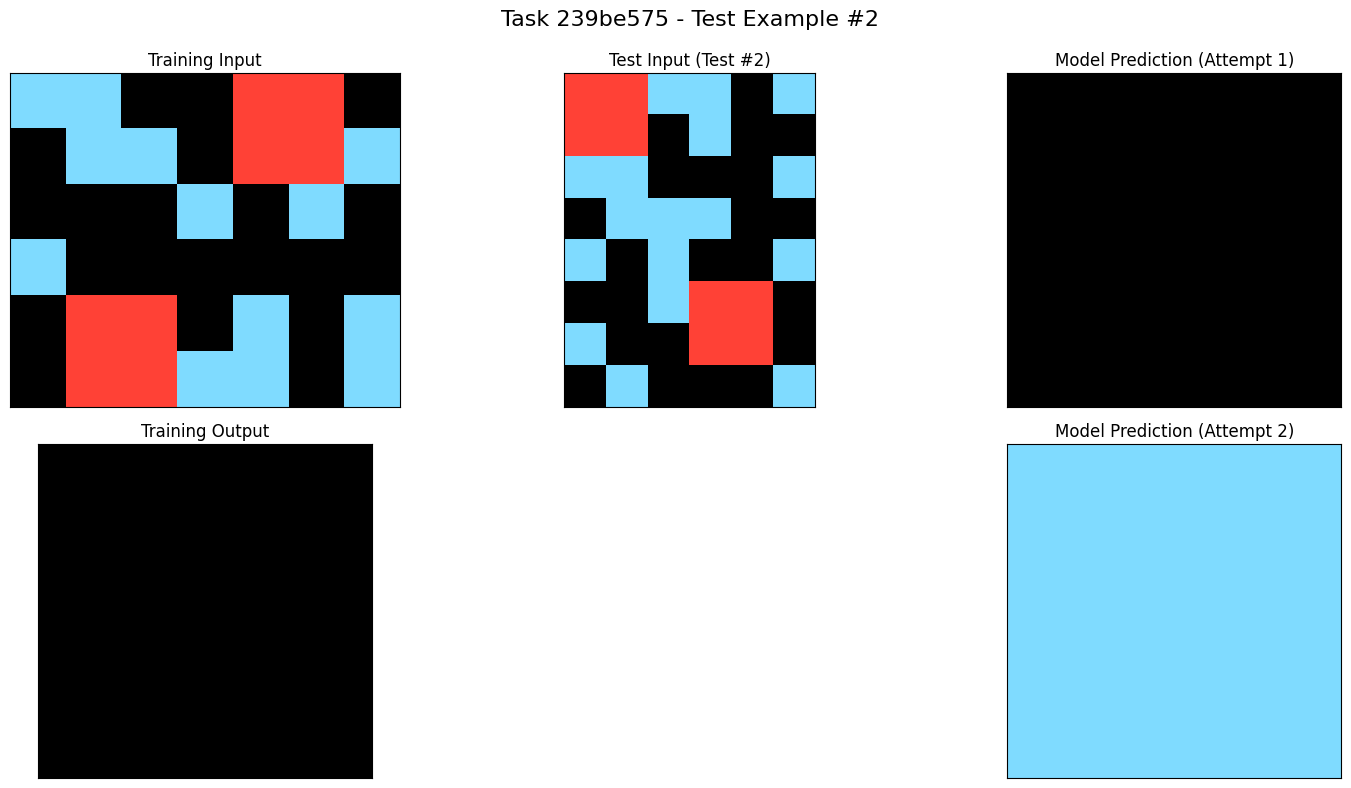



Task: 252143c9 - Test #1 (Score: 1/2)


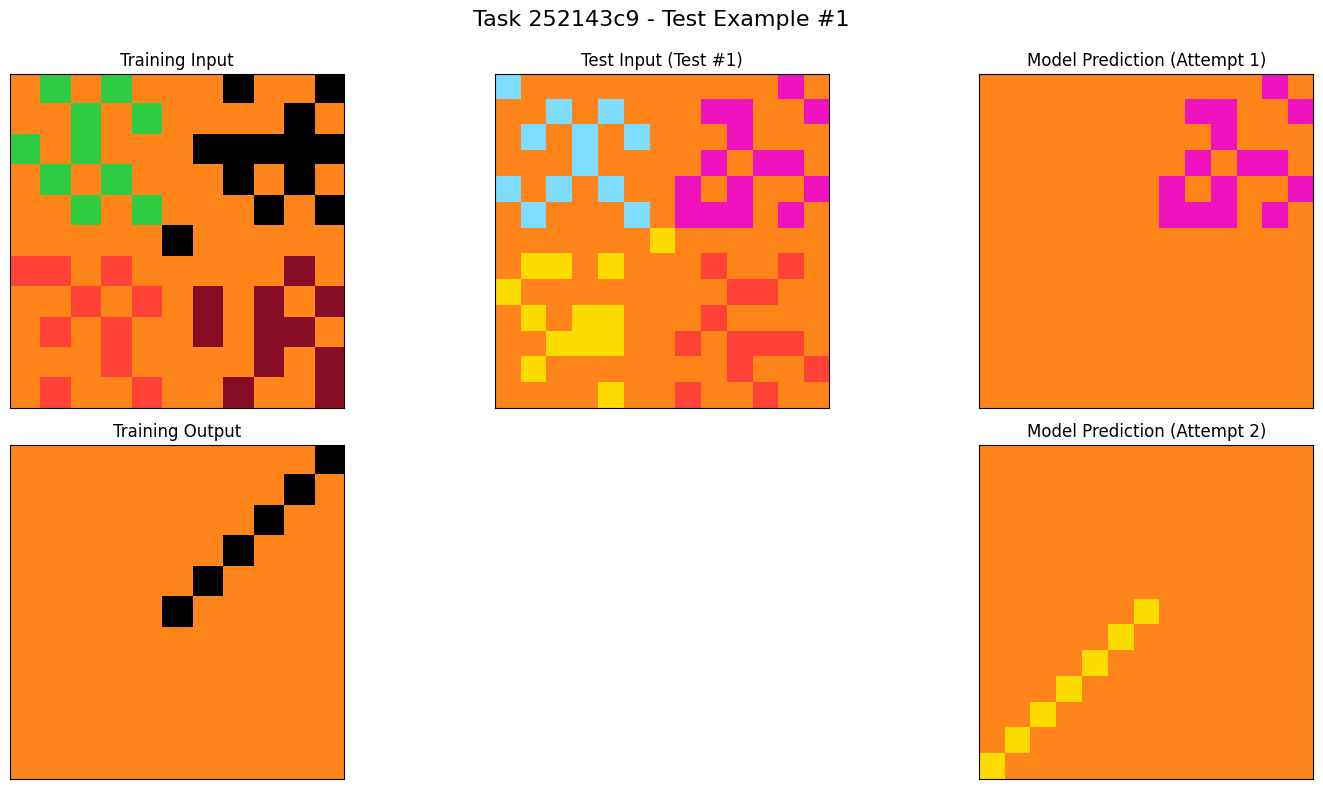



Task: 25ff71a9 - Test #1 (Score: 1/2)


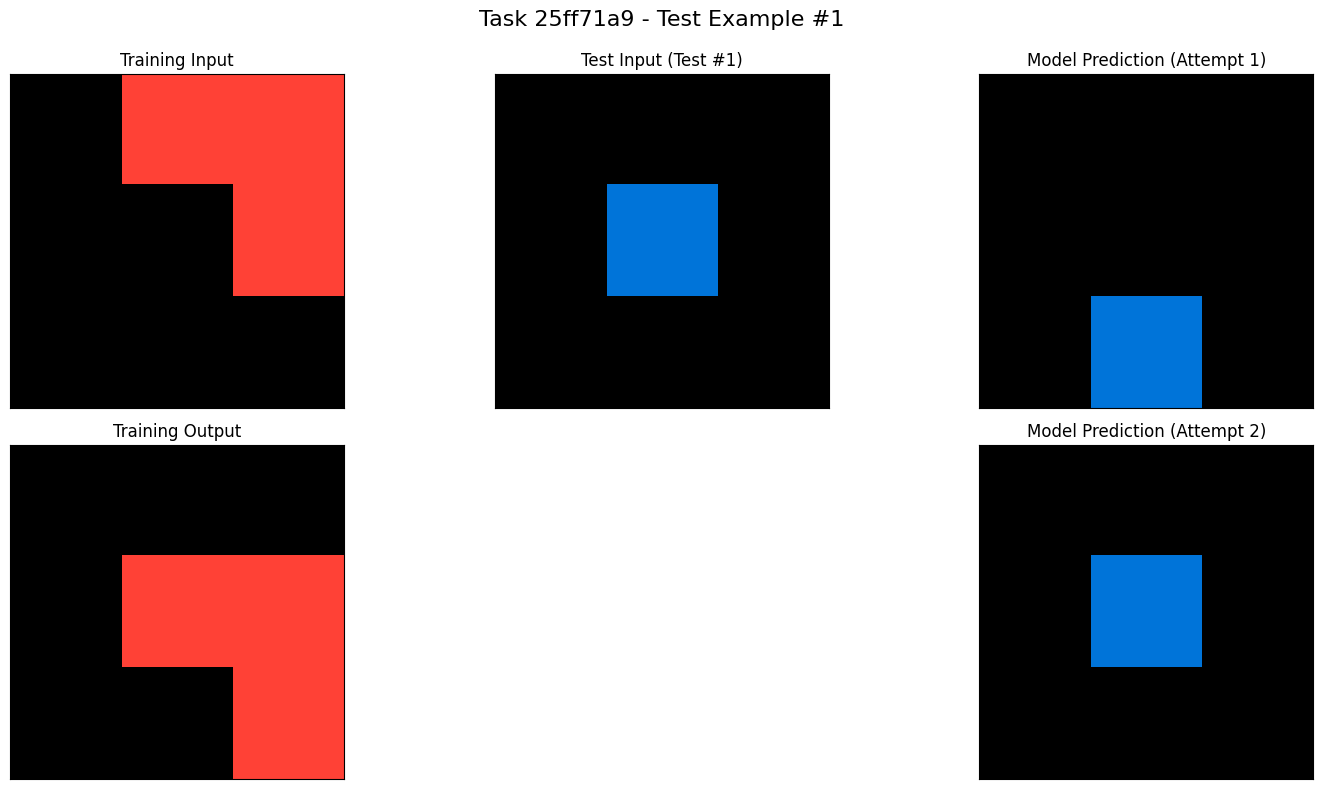



Task: 25ff71a9 - Test #2 (Score: 1/2)


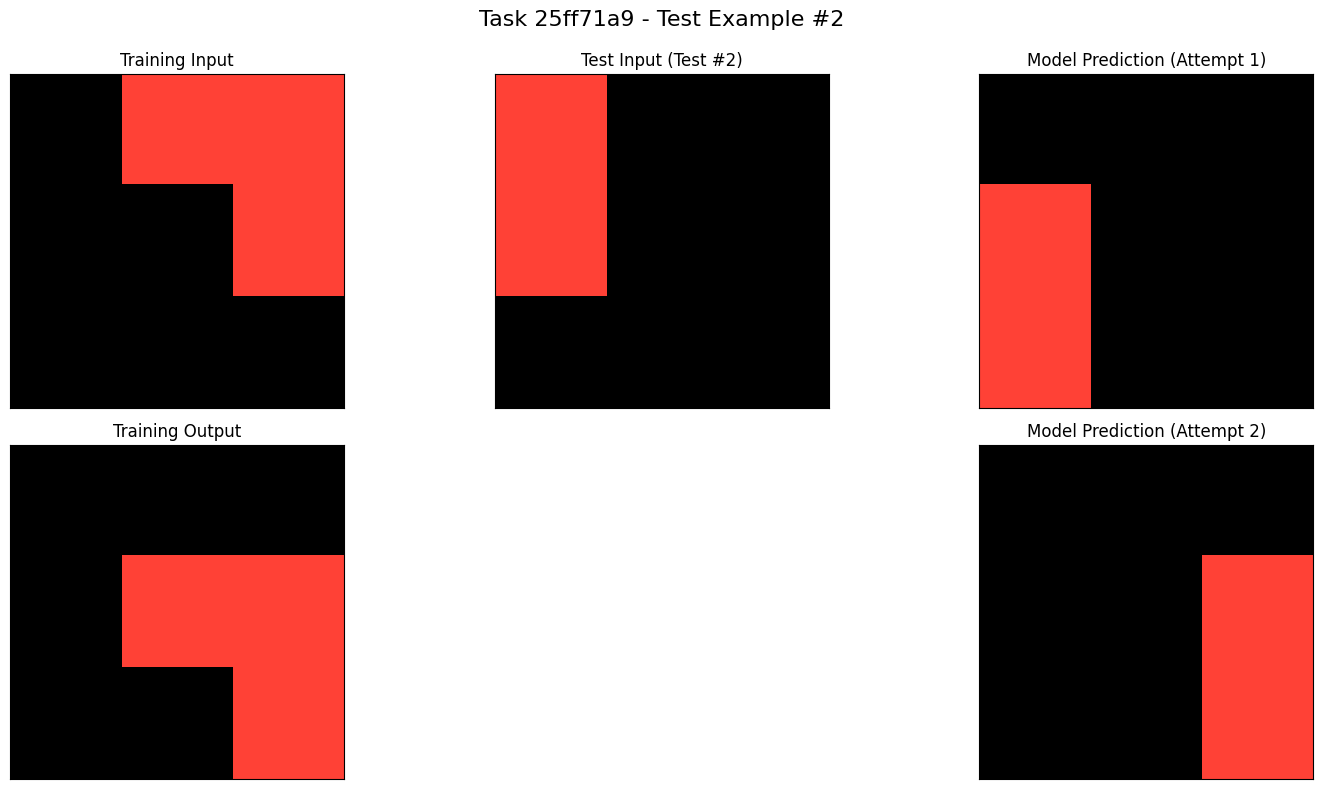



Task: 28bf18c6 - Test #1 (Score: 1/2)


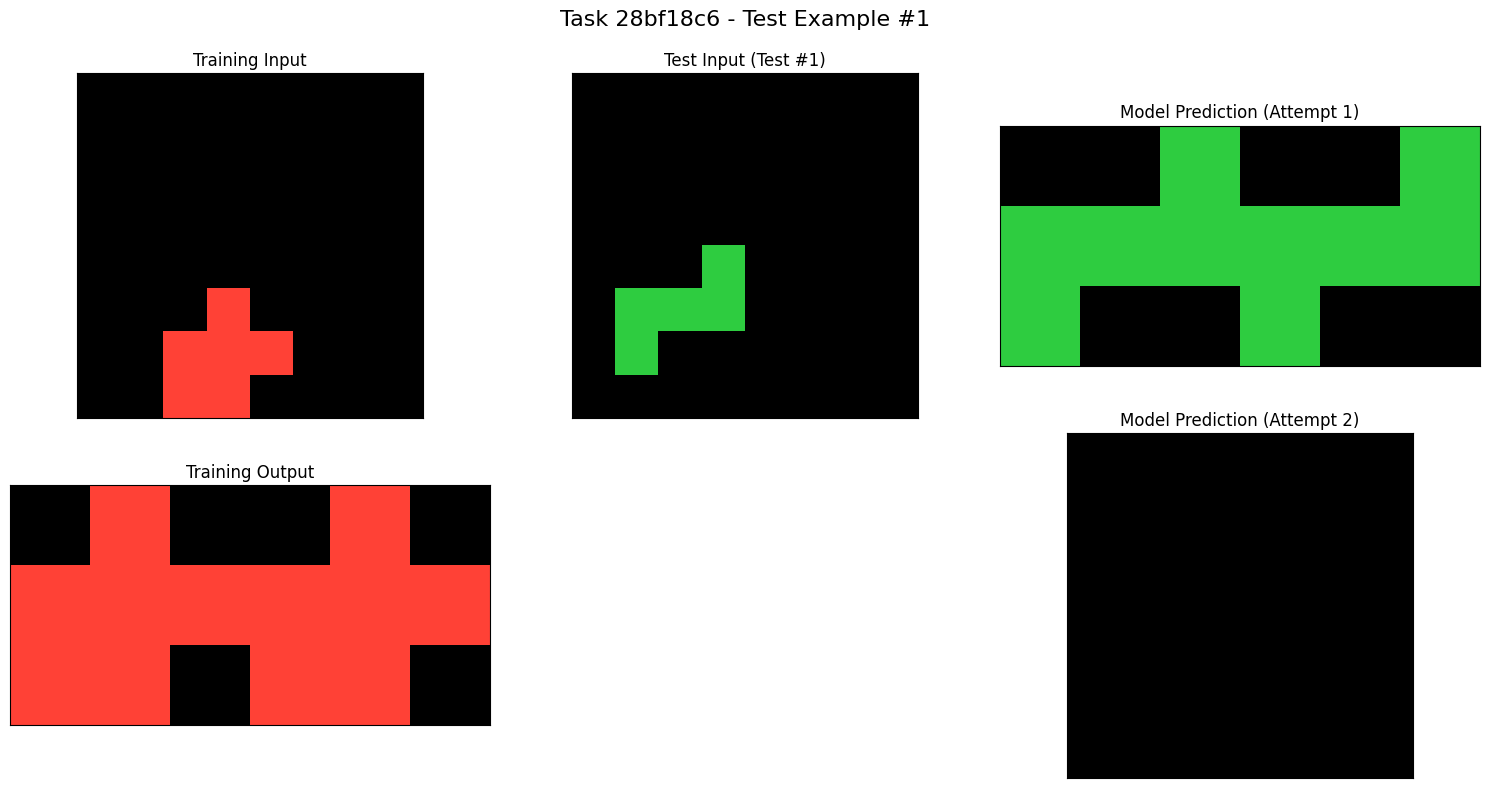



Task: 2dee498d - Test #1 (Score: 1/2)


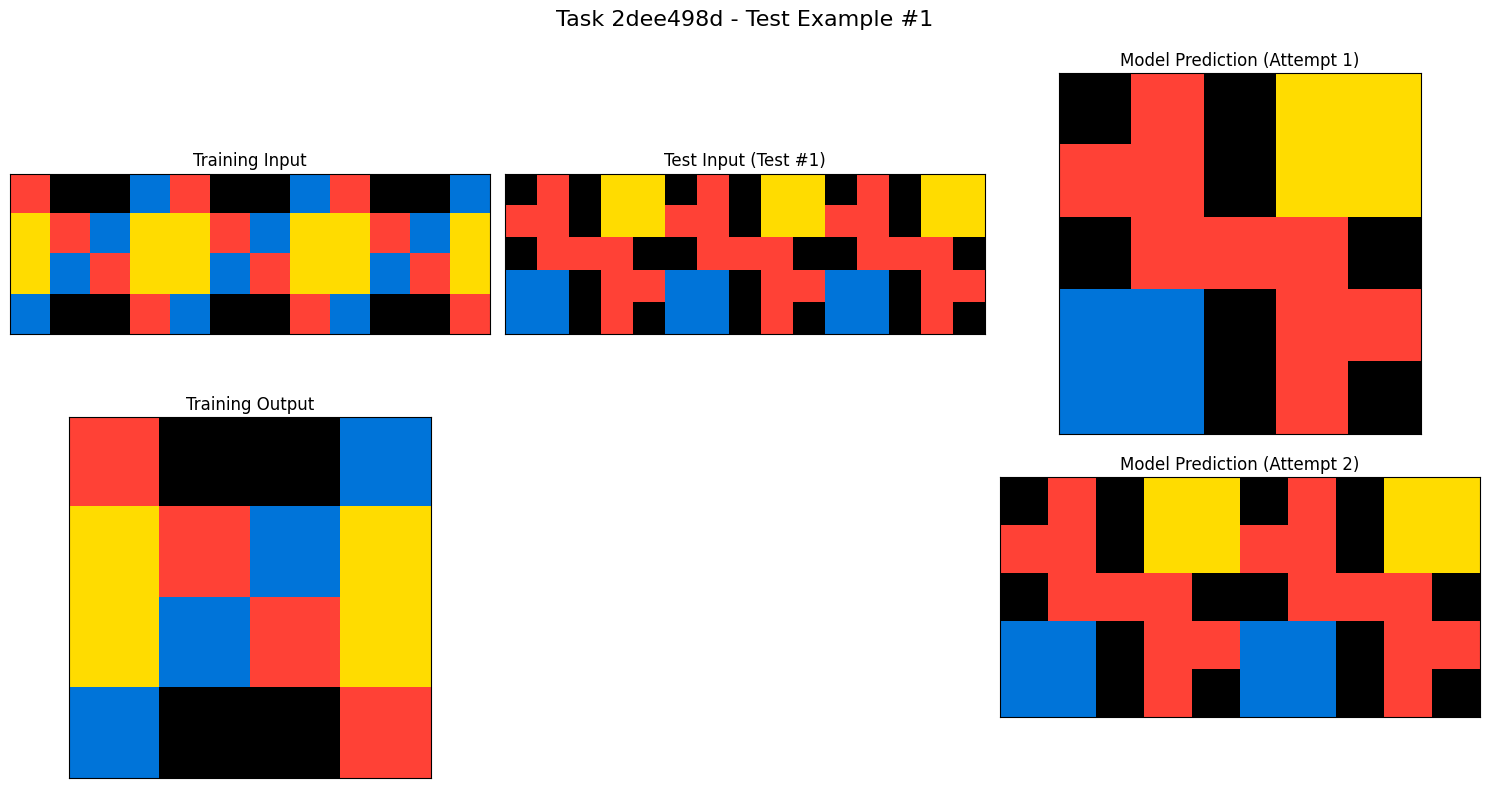



Task: 31d5ba1a - Test #1 (Score: 1/2)


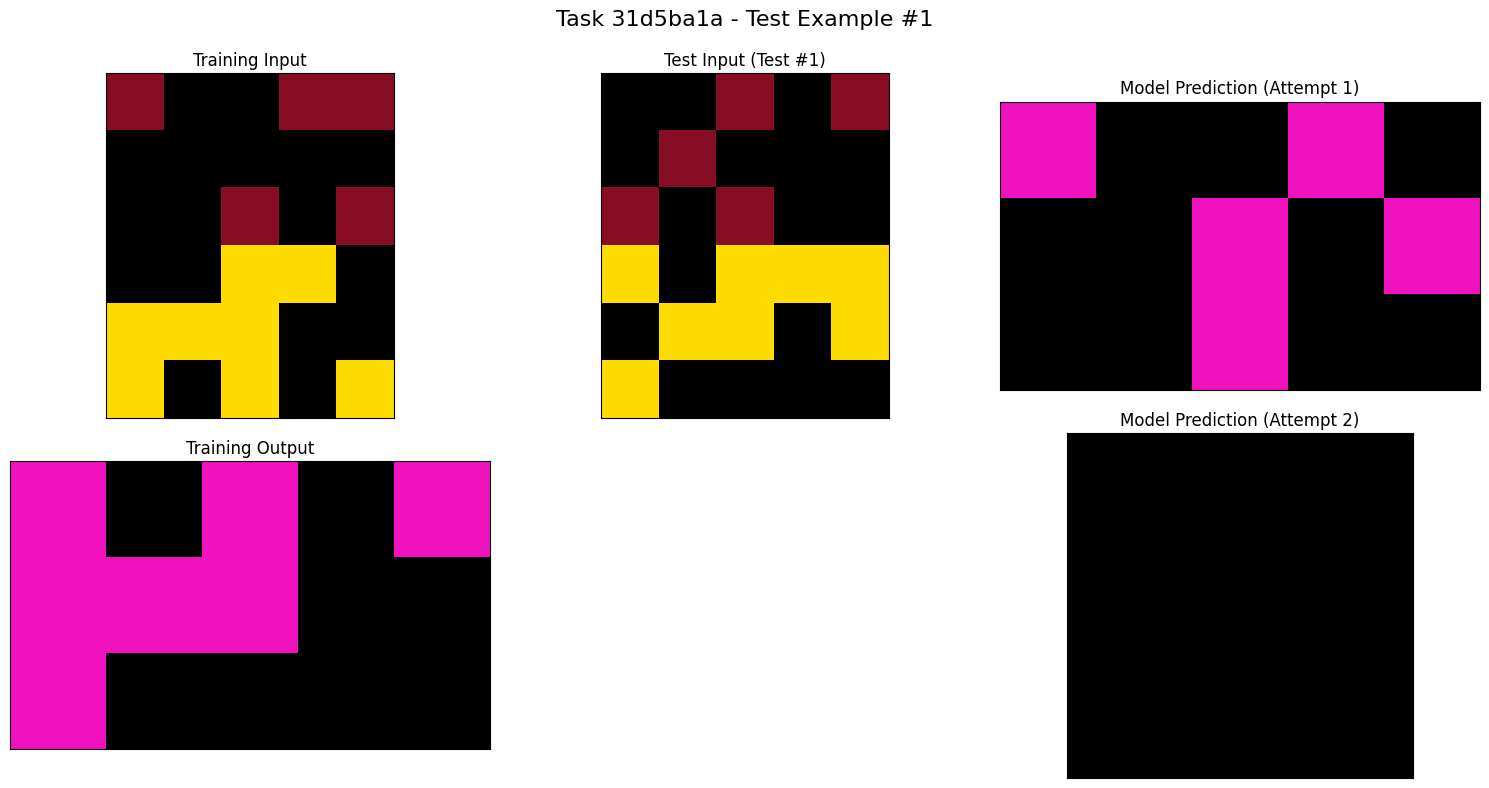



Task: 3979b1a8 - Test #1 (Score: 1/2)


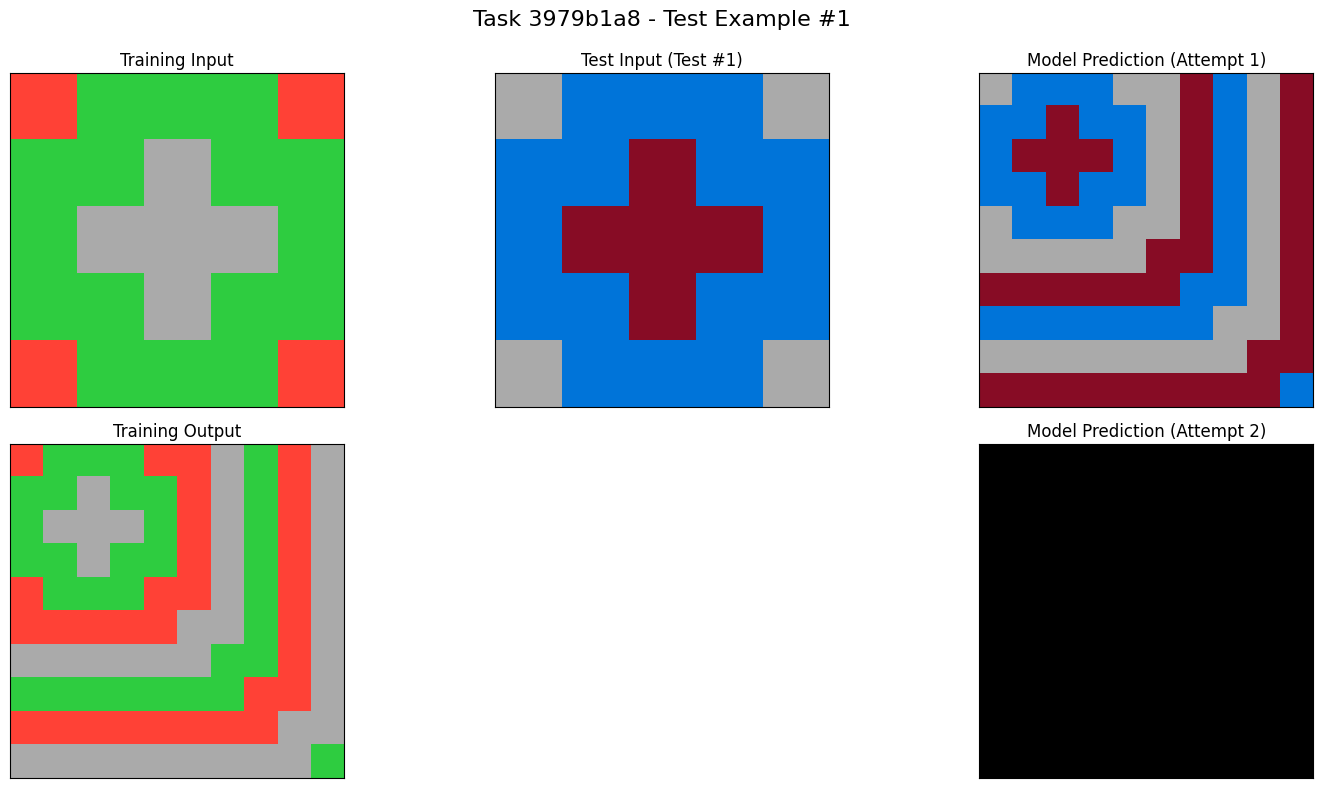



Task: 3aa6fb7a - Test #1 (Score: 1/2)


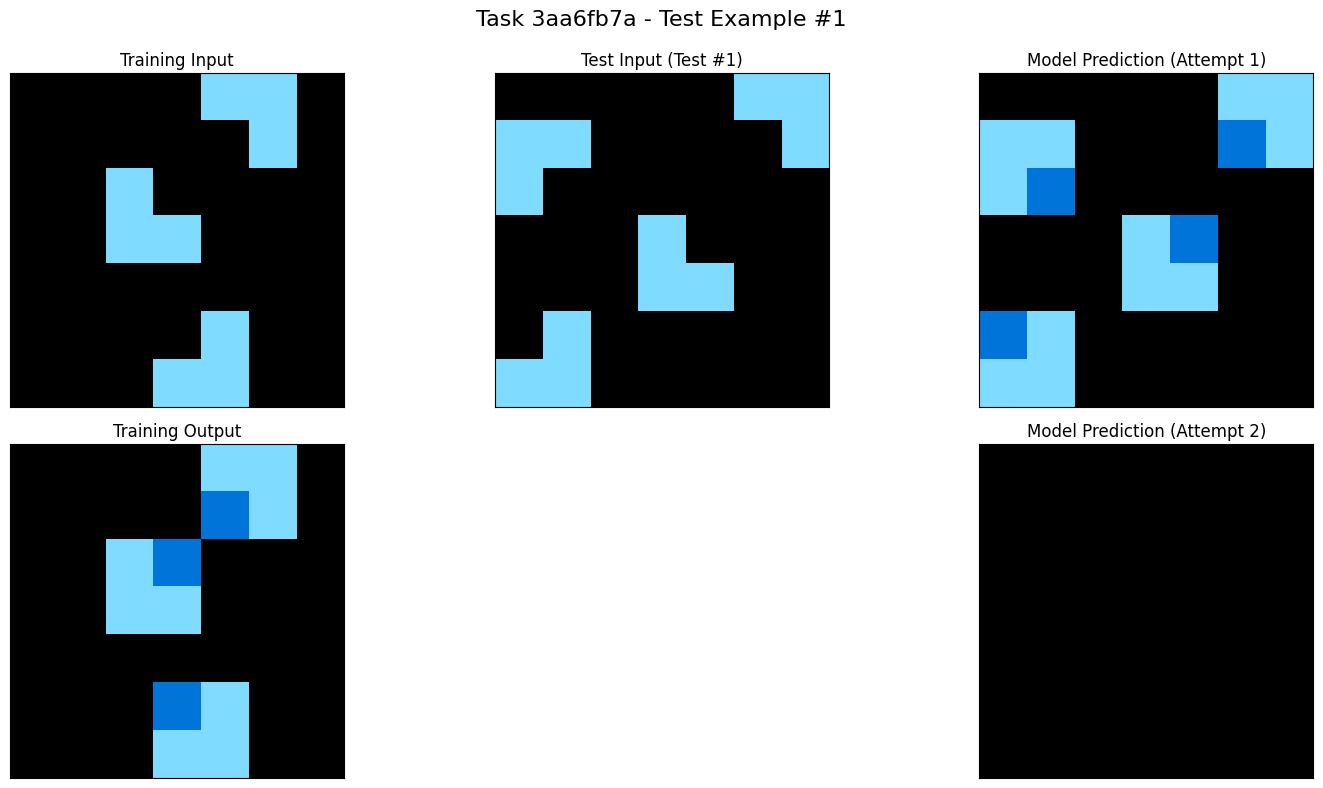



Task: 3c9b0459 - Test #1 (Score: 1/2)


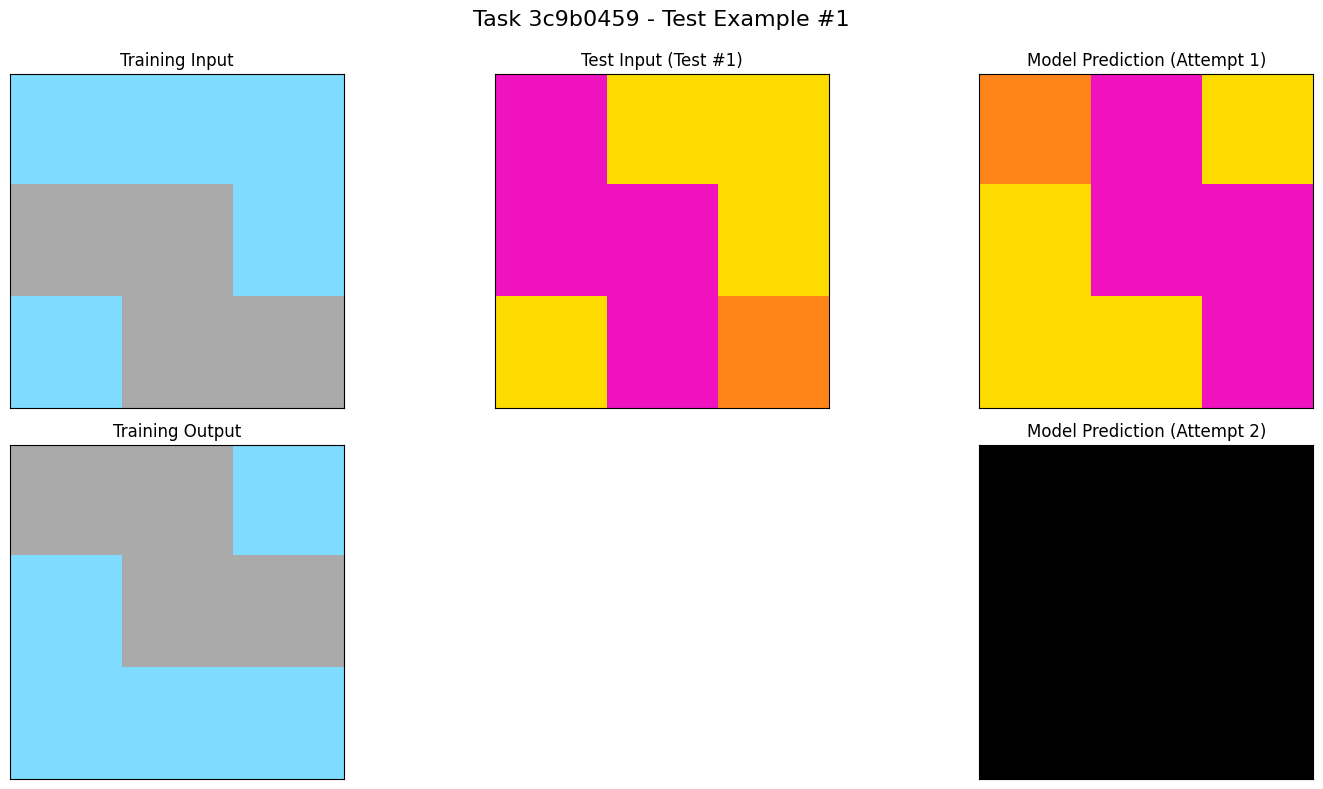



Task: 3cd86f4f - Test #1 (Score: 1/2)


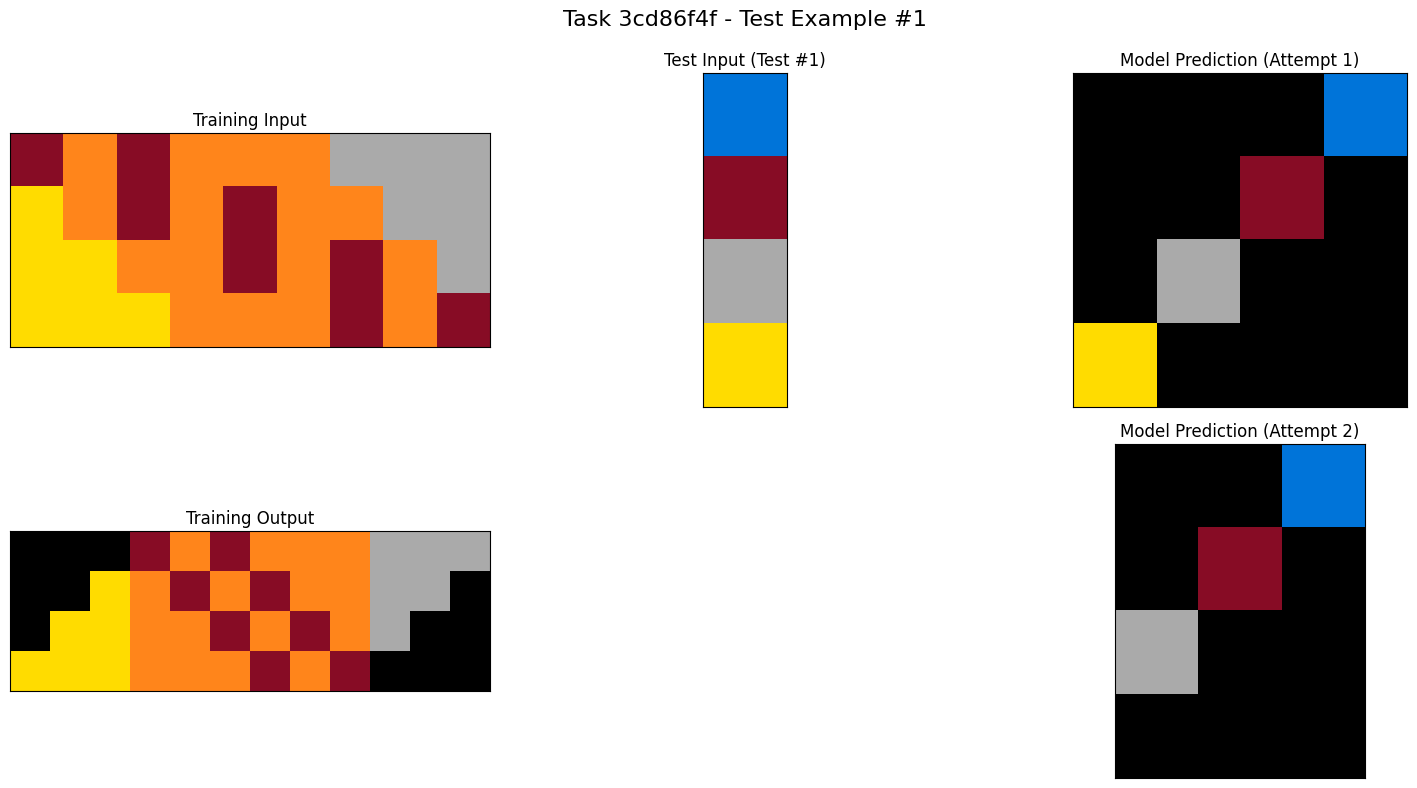



Task: 00576224 - Test #1 (all zeros - no score)
  Skipping visualization for Task 00576224 - Test #1 (all predictions are zeros)

Task: 007bbfb7 - Test #1 (all zeros - no score)
  Skipping visualization for Task 007bbfb7 - Test #1 (all predictions are zeros)

Task: 009d5c81 - Test #1 (all zeros - no score)
  Skipping visualization for Task 009d5c81 - Test #1 (all predictions are zeros)

Task: 00d62c1b - Test #1 (all zeros - no score)
  Skipping visualization for Task 00d62c1b - Test #1 (all predictions are zeros)

Task: 00dbd492 - Test #1 (all zeros - no score)
  Skipping visualization for Task 00dbd492 - Test #1 (all predictions are zeros)

Task: 025d127b - Test #1 (all zeros - no score)
  Skipping visualization for Task 025d127b - Test #1 (all predictions are zeros)

Task: 03560426 - Test #1 (all zeros - no score)
  Skipping visualization for Task 03560426 - Test #1 (all predictions are zeros)

Task: 045e512c - Test #1 (all zeros - no score)
  Skipping visualization for Task 045e51

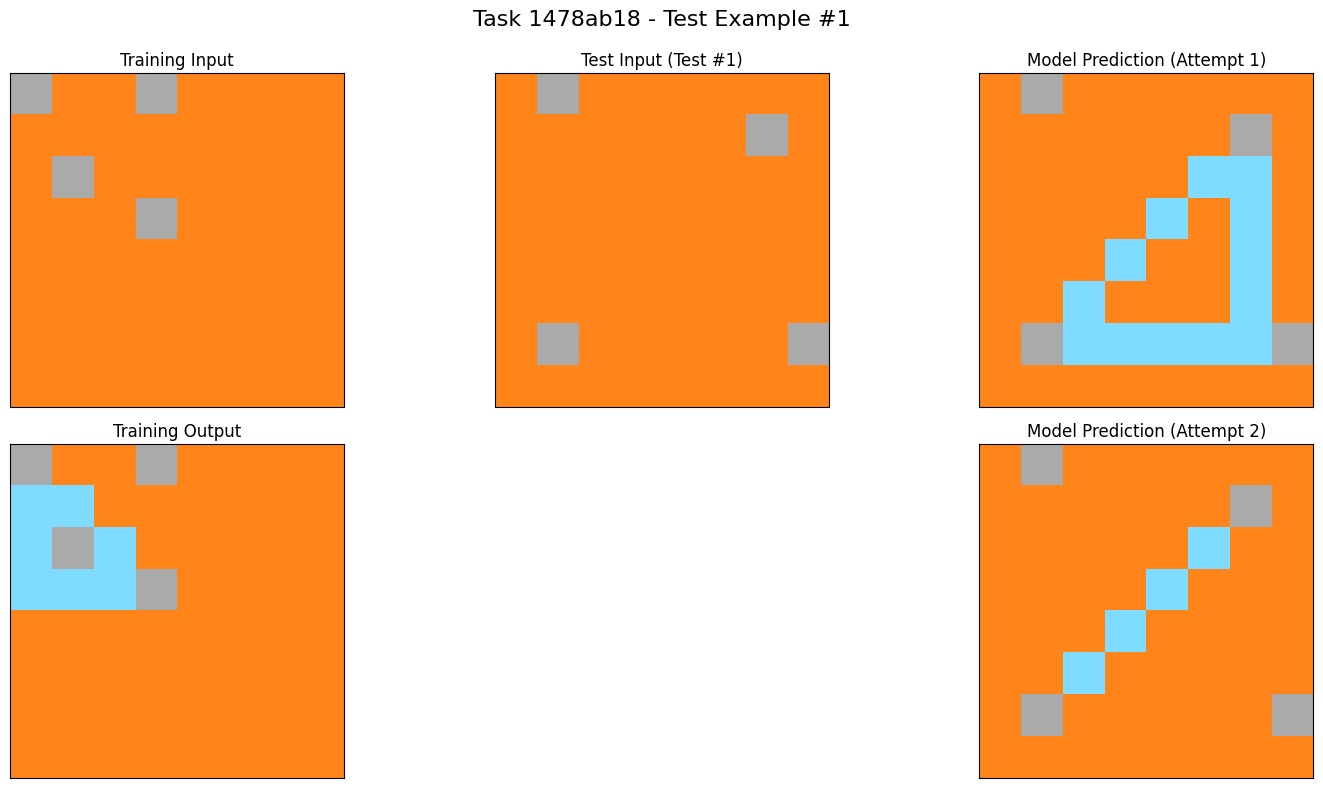



Task: 14b8e18c - Test #1 (all zeros - no score)
  Skipping visualization for Task 14b8e18c - Test #1 (all predictions are zeros)

Task: 15113be4 - Test #1 (all zeros - no score)
  Skipping visualization for Task 15113be4 - Test #1 (all predictions are zeros)

Task: 15660dd6 - Test #1 (all zeros - no score)
  Skipping visualization for Task 15660dd6 - Test #1 (all predictions are zeros)

Task: 15663ba9 - Test #1 (all zeros - no score)
  Skipping visualization for Task 15663ba9 - Test #1 (all predictions are zeros)

Task: 15696249 - Test #1 (all zeros - no score)
  Skipping visualization for Task 15696249 - Test #1 (all predictions are zeros)

Task: 17829a00 - Test #1 (all zeros - no score)
  Skipping visualization for Task 17829a00 - Test #1 (all predictions are zeros)

Task: 178fcbfb - Test #1 (all zeros - no score)
  Skipping visualization for Task 178fcbfb - Test #1 (all predictions are zeros)

Task: 17b80ad2 - Test #1 (all zeros - no score)
  Skipping visualization for Task 17b80a

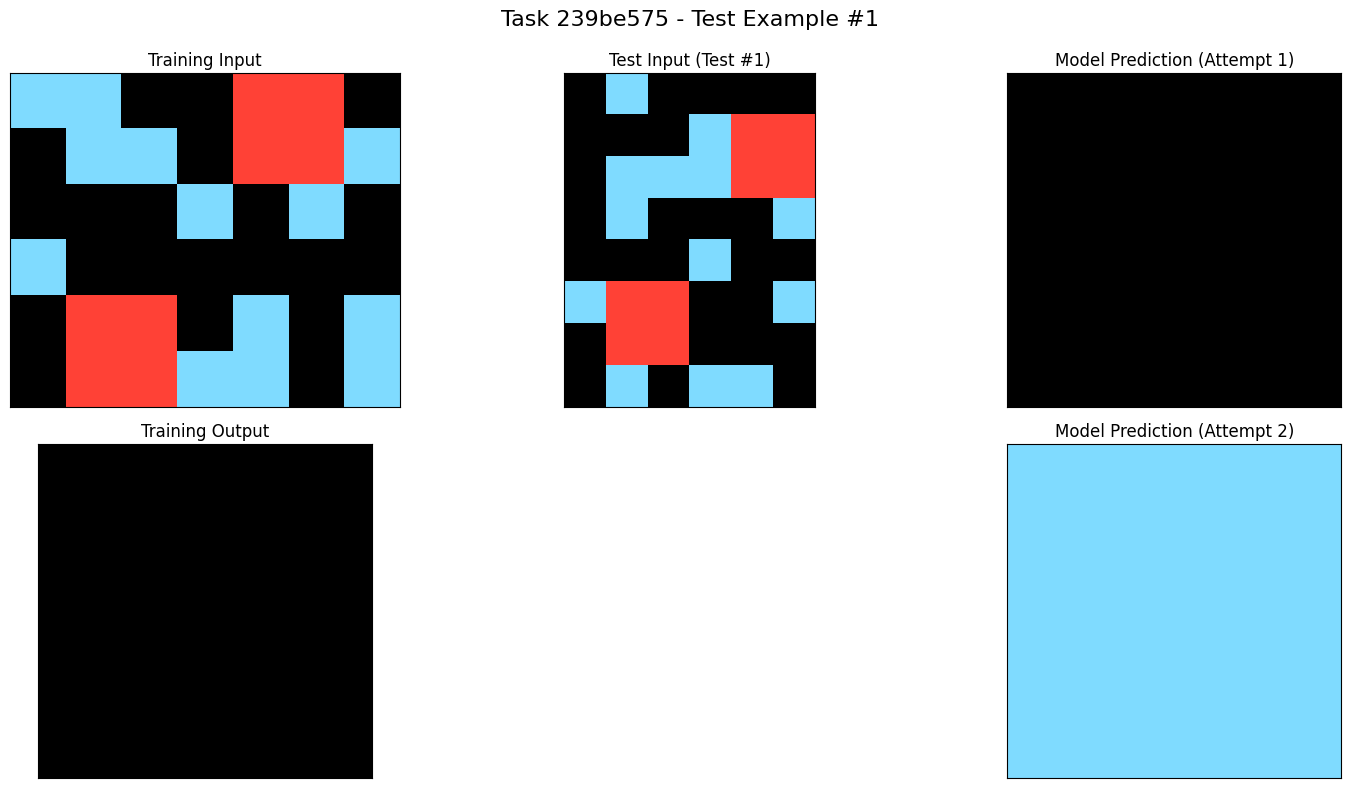



Task: 23b5c85d - Test #1 (all zeros - no score)
  Skipping visualization for Task 23b5c85d - Test #1 (all predictions are zeros)

Task: 25094a63 - Test #1 (all zeros - no score)
  Skipping visualization for Task 25094a63 - Test #1 (all predictions are zeros)

Task: 253bf280 - Test #1 (all zeros - no score)
  Skipping visualization for Task 253bf280 - Test #1 (all predictions are zeros)

Task: 2546ccf6 - Test #1 (all zeros - no score)
  Skipping visualization for Task 2546ccf6 - Test #1 (all predictions are zeros)

Task: 256b0a75 - Test #1 (all zeros - no score)
  Skipping visualization for Task 256b0a75 - Test #1 (all predictions are zeros)

Task: 25c199f5 - Test #1 (all zeros - no score)
  Skipping visualization for Task 25c199f5 - Test #1 (all predictions are zeros)

Task: 25c199f5 - Test #2 (all zeros - no score)
  Skipping visualization for Task 25c199f5 - Test #2 (all predictions are zeros)

Task: 25d487eb - Test #1 (all zeros - no score)
  Skipping visualization for Task 25d487

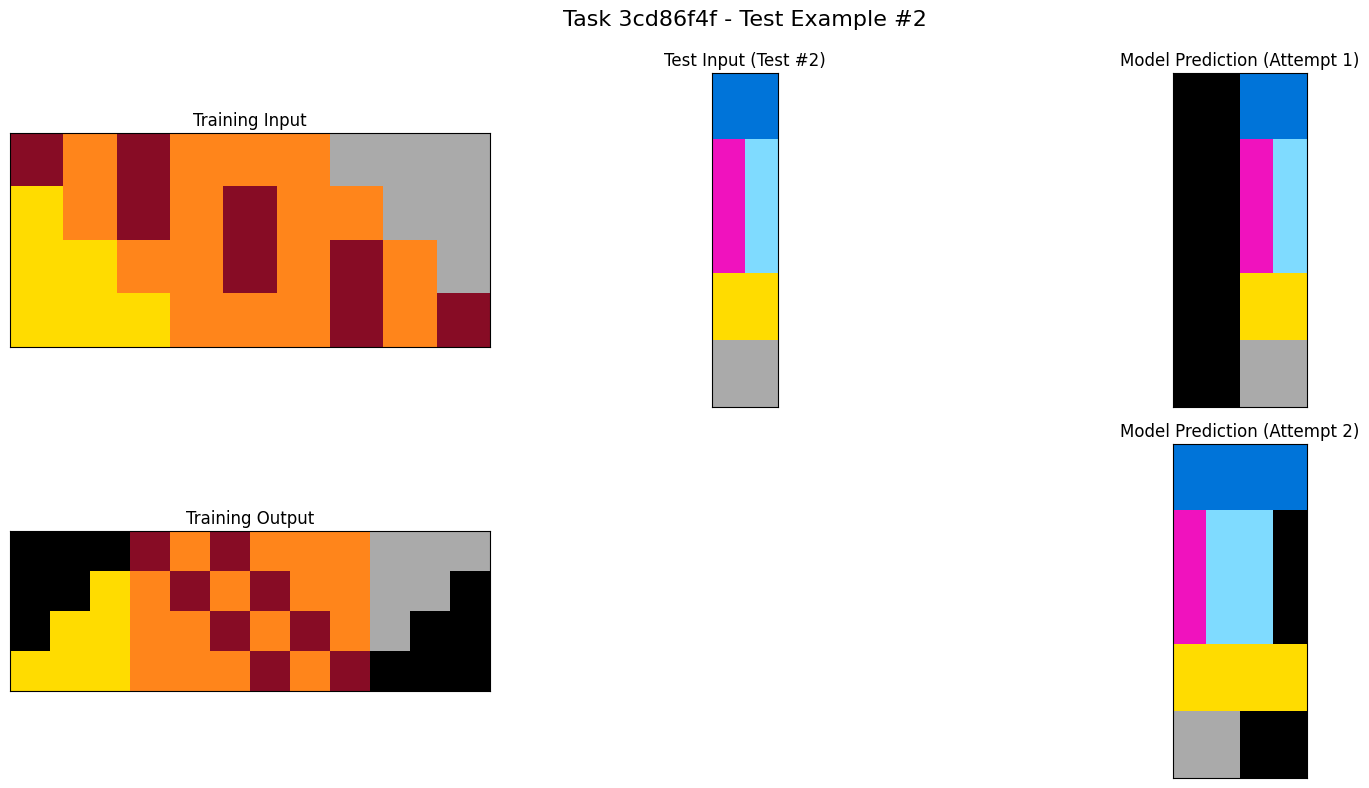



Task: 3cd86f4f - Test #3 (Score: 0/2)


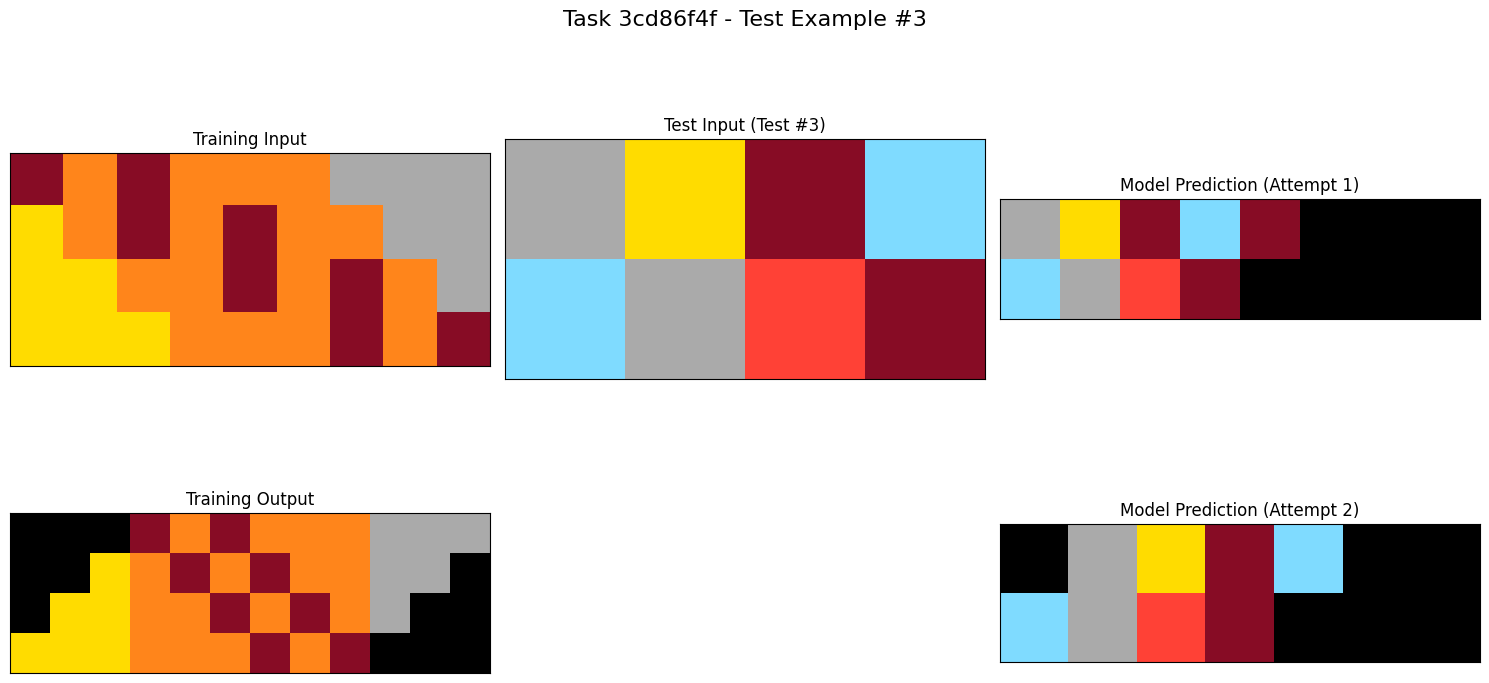



Task: 3d31c5b3 - Test #1 (all zeros - no score)
  Skipping visualization for Task 3d31c5b3 - Test #1 (all predictions are zeros)

Task: 3d588dc9 - Test #1 (all zeros - no score)
  Skipping visualization for Task 3d588dc9 - Test #1 (all predictions are zeros)

Task: 3d6c6e23 - Test #1 (all zeros - no score)
  Skipping visualization for Task 3d6c6e23 - Test #1 (all predictions are zeros)

Task: 3de23699 - Test #1 (all zeros - no score)
  Skipping visualization for Task 3de23699 - Test #1 (all predictions are zeros)

Task: 3e980e27 - Test #1 (all zeros - no score)
  Skipping visualization for Task 3e980e27 - Test #1 (all predictions are zeros)

Task: 3eda0437 - Test #1 (all zeros - no score)
  Skipping visualization for Task 3eda0437 - Test #1 (all predictions are zeros)

Task: 3ee1011a - Test #1 (all zeros - no score)
  Skipping visualization for Task 3ee1011a - Test #1 (all predictions are zeros)

Task: 3f23242b - Test #1 (all zeros - no score)
  Skipping visualization for Task 3f2324

In [20]:
# Visualization for inference results from submission.json
if arc_test_set.is_fake:
    from common_stuff import *
    import matplotlib.pyplot as plt
    from matplotlib import colors
    import json
    import os
    import numpy as np
    
    print("\n" + "="*80)
    print("VISUALIZING RESULTS FROM SUBMISSION.JSON")
    print("="*80)
    
    # Check if submission file exists
    submission_path = 'submission.json'
    if not os.path.exists(submission_path):
        print(f"Submission file not found at {submission_path}")
    else:
        print(f"Found submission file: {submission_path}")
        
        # Load submission data
        with open(submission_path, 'r') as f:
            submission_data = json.load(f)
        
        print(f"Loaded submission with {len(submission_data)} tasks")
        
        # ARC color map
        cmap = colors.ListedColormap(
            ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        norm = colors.Normalize(vmin=0, vmax=9)
        
        # Function to check if prediction is non-trivial (not just zeros)
        def is_non_trivial_prediction(pred_array):
            # Check if the prediction contains any non-zero values
            return np.any(np.array(pred_array) > 0)
        
        # Function to visualize a single task result
        def visualize_submission_result(task_id, task_data, submission_output, test_idx):
            # Skip visualization if both predictions are just zeros
            pred_1 = np.array(submission_output['attempt_1'])
            pred_2 = np.array(submission_output['attempt_2'])
            
            if not is_non_trivial_prediction(pred_1) and not is_non_trivial_prediction(pred_2):
                print(f"  Skipping visualization for Task {task_id} - Test #{test_idx+1} (all predictions are zeros)")
                return False
            
            # Create visualization
            fig = plt.figure(figsize=(15, 8))
            grid_spec = plt.GridSpec(2, 3, width_ratios=[1, 1, 1])
            
            # Training examples (first one only for simplicity)
            if task_data['train']:
                # Train Input
                ax1 = fig.add_subplot(grid_spec[0, 0])
                ax1.imshow(task_data['train'][0]['input'], cmap=cmap, norm=norm)
                ax1.grid(True, which='both', color='lightgrey', linewidth=0.5)
                ax1.set_title("Training Input")
                ax1.set_xticks([])
                ax1.set_yticks([])
                
                # Train Output
                ax2 = fig.add_subplot(grid_spec[1, 0])
                ax2.imshow(task_data['train'][0]['output'], cmap=cmap, norm=norm)
                ax2.grid(True, which='both', color='lightgrey', linewidth=0.5)
                ax2.set_title("Training Output")
                ax2.set_xticks([])
                ax2.set_yticks([])
            
            # Test Input
            if test_idx < len(task_data['test']):
                ax3 = fig.add_subplot(grid_spec[0, 1])
                ax3.imshow(task_data['test'][test_idx]['input'], cmap=cmap, norm=norm)
                ax3.grid(True, which='both', color='lightgrey', linewidth=0.5)
                ax3.set_title(f"Test Input (Test #{test_idx+1})")
                ax3.set_xticks([])
                ax3.set_yticks([])
                
                # Ground Truth (if available)
                if 'output' in task_data['test'][test_idx]:
                    ax4 = fig.add_subplot(grid_spec[1, 1])
                    ax4.imshow(task_data['test'][test_idx]['output'], cmap=cmap, norm=norm)
                    ax4.grid(True, which='both', color='lightgrey', linewidth=0.5)
                    ax4.set_title("Ground Truth")
                    ax4.set_xticks([])
                    ax4.set_yticks([])
            
            # Model Predictions
            # Attempt 1
            ax5 = fig.add_subplot(grid_spec[0, 2])
            ax5.imshow(pred_1, cmap=cmap, norm=norm)
            ax5.grid(True, which='both', color='lightgrey', linewidth=0.5)
            ax5.set_title("Model Prediction (Attempt 1)")
            ax5.set_xticks([])
            ax5.set_yticks([])
            
            # Attempt 2
            ax6 = fig.add_subplot(grid_spec[1, 2])
            ax6.imshow(pred_2, cmap=cmap, norm=norm)
            ax6.grid(True, which='both', color='lightgrey', linewidth=0.5)
            ax6.set_title("Model Prediction (Attempt 2)")
            ax6.set_xticks([])
            ax6.set_yticks([])
            
            plt.suptitle(f"Task {task_id} - Test Example #{test_idx+1}", fontsize=16)
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()
            
            # Calculate accuracy if ground truth is available
            if 'output' in task_data['test'][test_idx]:
                ground_truth = np.array(task_data['test'][test_idx]['output'])
                
                # Check accuracy of both attempts
                results = []
                match_1 = np.array_equal(pred_1, ground_truth) if is_non_trivial_prediction(pred_1) else False
                results.append(f"Attempt 1: {'✓' if match_1 else '✗'}{' (zeros)' if not is_non_trivial_prediction(pred_1) else ''}")
                
                match_2 = np.array_equal(pred_2, ground_truth) if is_non_trivial_prediction(pred_2) else False
                results.append(f"Attempt 2: {'✓' if match_2 else '✗'}{' (zeros)' if not is_non_trivial_prediction(pred_2) else ''}")
                
                print(f"  Results: {', '.join(results)}")
                
                # Display task statistics
                print(f"  Shape - Ground Truth: {ground_truth.shape}, Prediction 1: {pred_1.shape}, Prediction 2: {pred_2.shape}")
                print(f"  Values - Ground Truth unique values: {np.unique(ground_truth)}")
                print(f"          Prediction 1 unique values: {np.unique(pred_1)}")
                print(f"          Prediction 2 unique values: {np.unique(pred_2)}")
            print()
            return True
        
        # Process ALL results from submission (no limit)
        visualized_count = 0
        skipped_count = 0
        
        # Get a list of tasks in the submission
        task_ids = list(submission_data.keys())
        
        # Collect all task/test combinations
        all_predictions = []
        for task_id in task_ids:
            if task_id in arc_test_set.queries:
                task_data = arc_test_set.queries[task_id]
                for test_idx, test_prediction in enumerate(submission_data[task_id]):
                    # Check if we have ground truth available
                    has_ground_truth = (task_id in arc_test_set.replies and 
                                        test_idx < len(arc_test_set.replies[task_id]))
                    
                    # Check if predictions are non-trivial
                    pred_1 = np.array(test_prediction['attempt_1'])
                    pred_2 = np.array(test_prediction['attempt_2'])
                    has_non_zero_pred = is_non_trivial_prediction(pred_1) or is_non_trivial_prediction(pred_2)
                    
                    # Score based on correctness if ground truth is available
                    score = 0
                    if has_ground_truth and has_non_zero_pred:
                        ground_truth = np.array(arc_test_set.replies[task_id][test_idx])
                        
                        match_1 = np.array_equal(pred_1, ground_truth) if is_non_trivial_prediction(pred_1) else False
                        match_2 = np.array_equal(pred_2, ground_truth) if is_non_trivial_prediction(pred_2) else False
                        score = match_1 + match_2
                        
                    all_predictions.append((task_id, test_idx, score, has_ground_truth, has_non_zero_pred))
        
        # Sort by whether they have ground truth first, then by score
        all_predictions.sort(key=lambda x: (-int(x[3]), -x[2]))
        
        # Print summary before visualization
        print(f"\nFound {len(all_predictions)} total predictions to visualize")
        
        # Visualize all tasks
        for task_id, test_idx, score, has_ground_truth, has_non_zero_pred in all_predictions:
            # Get task data and predictions
            task_data = arc_test_set.queries[task_id]
            submission_output = submission_data[task_id][test_idx]
            
            # Visualize this task
            score_info = f" (Score: {score}/2)" if has_ground_truth and has_non_zero_pred else " (no ground truth)" if not has_ground_truth else " (all zeros - no score)"
            print(f"\nTask: {task_id} - Test #{test_idx+1}{score_info}")
            
            # Only increment visualized_count if actually visualized
            if visualize_submission_result(task_id, task_data, submission_output, test_idx):
                visualized_count += 1
            else:
                skipped_count += 1
        
        print(f"\nVisualized {visualized_count} inference results (skipped {skipped_count} with all-zero predictions)")
        
        # Calculate overall accuracy statistics
        if arc_test_set.is_fake:
            total_tests = 0
            total_scored_tests = 0
            correct_attempt1 = 0
            correct_attempt2 = 0
            correct_any = 0
            zero_predictions = 0
            
            for task_id, test_predictions in submission_data.items():
                if task_id in arc_test_set.replies:
                    for test_idx, test_prediction in enumerate(test_predictions):
                        if test_idx < len(arc_test_set.replies[task_id]):
                            total_tests += 1
                            
                            ground_truth = np.array(arc_test_set.replies[task_id][test_idx])
                            pred_1 = np.array(test_prediction['attempt_1'])
                            pred_2 = np.array(test_prediction['attempt_2'])
                            
                            # Check if both predictions are all zeros
                            if not is_non_trivial_prediction(pred_1) and not is_non_trivial_prediction(pred_2):
                                zero_predictions += 1
                                continue
                            
                            # Only count tests with at least one non-zero prediction
                            total_scored_tests += 1
                            
                            match_1 = np.array_equal(pred_1, ground_truth) if is_non_trivial_prediction(pred_1) else False
                            match_2 = np.array_equal(pred_2, ground_truth) if is_non_trivial_prediction(pred_2) else False
                            
                            if match_1: correct_attempt1 += 1
                            if match_2: correct_attempt2 += 1
                            if match_1 or match_2: correct_any += 1
            
            if total_tests > 0:
                print("\n" + "="*80)
                print("OVERALL ACCURACY STATISTICS")
                print("="*80)
                print(f"Total test examples: {total_tests}")
                print(f"Test examples with zero predictions (excluded from accuracy): {zero_predictions}")
                print(f"Test examples included in accuracy calculation: {total_scored_tests}")
                
                if total_scored_tests > 0:
                    print(f"Correct on attempt 1: {correct_attempt1}/{total_scored_tests} ({correct_attempt1/total_scored_tests:.2%})")
                    print(f"Correct on attempt 2: {correct_attempt2}/{total_scored_tests} ({correct_attempt2/total_scored_tests:.2%})")
                    print(f"Correct on either attempt: {correct_any}/{total_scored_tests} ({correct_any/total_scored_tests:.2%})")
                else:
                    print("No non-zero predictions to calculate accuracy")
                    
                print(f"Overall completion rate: {total_scored_tests/total_tests:.2%} of tests have non-zero predictions")
                print("="*80)
else:
    print("Skipping inference visualization - not in fake test mode")